In [5]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any
import shap
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, TargetEncoder, OneHotEncoder
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    classification_report
 )
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
import collections
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# !pip install ipykernel shap category_encoders imbalanced-learn xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn scipy catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.3 MB/s eta 0:00:00


In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
filepath = '/content/drive/MyDrive/Colab Notebooks/diabetic_data.csv'
# filepath = "diabetic_data.csv"
df = pd.read_csv(filepath)
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [8]:
# Mapping for categorical features from IDS_mapping
discharge_disposition_id_mapping = {
1: "Discharged to home",
2: "Discharged/transferred to another short term hospital",
3: "Discharged/transferred to SNF",
4: "Discharged/transferred to ICF",
5: "Discharged/transferred to another type of inpatient care institution",
6: "Discharged/transferred to home with home health service",
7: "Left AMA",
8: "Discharged/transferred to home under care of Home IV provider",
9: "Admitted as an inpatient to this hospital",
10: "Neonate discharged to another hospital for neonatal aftercare",
11: "Expired",
12: "Still patient or expected to return for outpatient services",
13: "Hospice / home",
14: "Hospice / medical facility",
15: "Discharged/transferred within this institution to Medicare approved swing bed",
16: "Discharged/transferred/referred another institution for outpatient services",
17: "Discharged/transferred/referred to this institution for outpatient services",
18: "NULL",
19: "Expired at home. Medicaid only, hospice.",
20: "Expired in a medical facility. Medicaid only, hospice.",
21: "Expired, place unknown. Medicaid only, hospice.",
22: "Discharged/transferred to another rehab fac including rehab units of a hospital.",
23: "Discharged/transferred to a long term care hospital.",
24: "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.",
25: "Not Mapped",
26: "Unknown/Invalid",
30: "Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere",
27: "Discharged/transferred to a federal health care facility.",
28: "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital.",
29: "Discharged/transferred to a Critical Access Hospital (CAH)."
}

admission_type_id_mapping = {
1 : 'Emergency',
2 : 'Urgent',
3 : 'Elective',
4 : 'Newborn',
5 : 'Not Available',
6 : 'NULL',
7 : 'Trauma Center',
8 : 'Not Mapped' }

admission_source_id = {
1 : 'Physician Referral',
2 : 'Clinic Referral',
3 : 'HMO Referral',
4 : 'Transfer from a hospital',
5 : 'Transfer from a Skilled Nursing Facility (SNF)',
6 : 'Transfer from another health care facility',
7 : 'Emergency Room',
8 : 'Court/Law Enforcement',
9 :  'Not Available',
10 : 'Transfer from critical access hospital',
11 : 'Normal Delivery',
12 : 'Premature Delivery',
13 : 'Sick Baby',
14 : 'Extramural Birth',
15 : 'Not Available',
17 : 'NULL',
18 : 'Transfer From Another Home Health Agency',
19 : 'Readmission to Same Home Health Agency',
20 : 'Not Mapped',
21 : 'Unknown/Invalid',
22 : 'Transfer from hospital inpt/same fac reslt in a sep claim',
23 : 'Born inside this hospital',
24 : 'Born outside this hospital',
25 : 'Transfer from Ambulatory Surgery Center',
26 : 'Transfer from Hospice'}

def map_icd9_to_group(code):
    """Map ICD-9 diagnosis codes to diagnostic groups"""
    if pd.isna(code) or code == '' or str(code).lower() == 'nan':
        return 'Unknown'

    # Convert to string and handle various formats
    code_str = str(code).strip()

    # Remove any trailing decimals like .0
    if '.' in code_str:
        try:
            # Handle decimal codes
            code_num = float(code_str)
        except:
            return 'Other'
    else:
        try:
            # Handle integer codes
            code_num = float(code_str)
        except:
            return 'Other'

    # Apply ICD-9 grouping rules
    if 250.0 <= code_num < 251.0:  # Diabetes: 250.xx
        return 'Diabetes'
    elif 1 <= code_num <=129:
        return 'Infectious and parasitic diseases'
    elif 140 <= code_num <= 239:  # Neoplasms
        return 'Neoplasms'
    elif 240 <= code_num <= 279:
        return 'Endocrine, nutritional and metabolic diseases, and immunity disorders'
    elif 280 <= code_num <= 289:
        return 'diseases of the blood and blood-forming organs'
    elif 290 <= code_num <= 319:
        return 'mental disorders'
    elif 320 <= code_num <= 389:
        return 'diseases of the nervous system and sense organs'
    elif (390 <= code_num <= 459) or code_num == 785:  # Circulatory
        return 'Circulatory'
    elif (460 <= code_num <= 519) or code_num == 786:  # Respiratory
        return 'Respiratory'
    elif (520 <= code_num <= 579) or code_num == 787:  # Digestive
        return 'Digestive'
    elif (580 <= code_num <= 629) or code_num == 788:  # Genitourinary
        return 'Genitourinary'
    elif 630 <= code_num <= 679:
        return 'complications of pregnancy, childbirth, and the puerperium'
    elif 680 <= code_num <= 709:
        return 'diseases of the skin and subcutaneous tissue'
    elif 710 <= code_num <= 739:
        return 'Musculoskeletal'
    elif 740 <= code_num <= 759:
        return 'congenital anomalies'
    elif 760 <= code_num <= 779:
        return 'certain conditions originating in the perinatal period'
    elif 780 <= code_num <= 799:
        return 'symptoms, signs, and ill-defined conditions'
    elif 800 <= code_num <= 999:  # Injury
        return 'Injury'
    else:
        return 'Other'

In [9]:
# Apply the ID mappings to make categorical features more interpretable
df['discharge_disposition_desc'] = df['discharge_disposition_id'].map(discharge_disposition_id_mapping)
df['admission_type_desc'] = df['admission_type_id'].map(admission_type_id_mapping)
df['admission_source_desc'] = df['admission_source_id'].map(admission_source_id)

# Map ICD-9 diagnosis codes to diagnostic groups
df['diag_1_group'] = df['diag_1'].apply(map_icd9_to_group)
df['diag_2_group'] = df['diag_2'].apply(map_icd9_to_group)
df['diag_3_group'] = df['diag_3'].apply(map_icd9_to_group)

# Convert readmitted to binary target
# <30 days = 1 (high risk, needs intervention)
# NO or >30 days = 0 (lower risk)
print("\nOriginal 'readmitted' column distribution:")
print(df['readmitted'].value_counts())

df['readmitted_binary'] = (df['readmitted'] == '<30').astype(int)

print("\nTarget 'readmitted_binary' encoding:")
print(df[['readmitted', 'readmitted_binary']].drop_duplicates().sort_values('readmitted'))


Original 'readmitted' column distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Target 'readmitted_binary' encoding:
   readmitted  readmitted_binary
11        <30                  1
1         >30                  0
0          NO                  0


In [10]:
def create_safe_patient_history_features(df):
    """
    Create patient history features WITHOUT data leakage

    Key principles to avoid leakage:
    1. Only use information from PRIOR encounters (not current or future)
    2. Use temporal ordering (encounter_id as proxy for time)
    3. Use .shift() to exclude current encounter from aggregations

    Returns: DataFrame with new history features
    """
    df = df.copy()
    original_columns = set(df.columns)

    # Sort by patient and encounter (encounter_id is chronological proxy)
    remove_patient_nbr_list = [493038, 23611986, 23738805, 67099194, 84365577, 89947233, 42491844, 33665094, 43466490, 42055272, 108707976, 39583782, 54686619, 33581808, 41325552, 151756061, 94422375, 32337963]
    df = df.sort_values(['patient_nbr', 'encounter_id']).reset_index(drop=True)
    df = df[~df['patient_nbr'].isin(remove_patient_nbr_list)]

    print("Creating patient history features (avoiding temporal leakage)...")

    # 1. Count of prior encounters (excluding current)
    df['prior_encounter_count'] = df.groupby('patient_nbr').cumcount()

    # 2. Prior readmission history (using .shift to exclude current encounter)
    # Use readmitted_binary if available, otherwise create it
    if 'readmitted_binary' not in df.columns:
        print("  ⚠️  Warning: readmitted_binary not found, creating it (<30 days = 1)")
        df['readmitted_binary'] = (df['readmitted'] == '<30').astype(int)

    # # Count of prior 30-day readmissions (high risk - our target)
    # df['prior_30day_readmission_count'] = (
    #     df.groupby('patient_nbr')['readmitted_binary']
    #     .shift(1)  # Exclude current encounter
    #     .fillna(0)
    #     .groupby(df['patient_nbr'])
    #     .cumsum()
    # )

    # Also track any readmission (not just <30 days) for additional context
    df['was_readmitted_any'] = (df['readmitted'] != 'NO').astype(int)
    df['prior_was_readmitted_any'] = (
        df.groupby('patient_nbr')['was_readmitted_any']
        .shift(1)
        .fillna(0)
        .astype(int)
    )
    df['prior_any_readmission_count'] = (
        df.groupby('patient_nbr')['was_readmitted_any']
        .shift(1)  # Exclude current encounter
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # 3. Prior total inpatient visits (cumulative)
    df['prior_total_inpatient'] = (
        df.groupby('patient_nbr')['number_inpatient']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # 4. Prior total emergency visits
    df['prior_total_emergency'] = (
        df.groupby('patient_nbr')['number_emergency']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # 5. Prior total outpatient visits
    df['prior_total_outpatient'] = (
        df.groupby('patient_nbr')['number_outpatient']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # 6. Average time in hospital for prior encounters
    df['prior_avg_time_in_hospital'] = (
        df.groupby('patient_nbr')['time_in_hospital']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 7. Prior medication count (number of medications prescribed)
    df['prior_avg_num_medications'] = (
        df.groupby('patient_nbr')['num_medications']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 8. Prior lab procedures count
    df['prior_avg_num_lab_procedures'] = (
        df.groupby('patient_nbr')['num_lab_procedures']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 9. Prior diagnosis count
    df['prior_avg_number_diagnoses'] = (
        df.groupby('patient_nbr')['number_diagnoses']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 10. Is this a returning patient? (binary flag)
    df['is_returning_patient'] = (df['prior_encounter_count'] > 0).astype(int)

    # # 11. Prior 30-day readmission rate (for returning patients)
    # df['prior_30day_readmission_rate'] = df.apply(
    #     lambda row: row['prior_30day_readmission_count'] / row['prior_encounter_count']
    #     if row['prior_encounter_count'] > 0 else 0, axis=1
    # )

    # ========== NEW ADVANCED FEATURES ==========

    # 12. Polypharmacy risk score (exponential risk above 5 medications)
    df['polypharmacy_risk'] = df['num_medications'].apply(
        lambda x: np.exp((x - 5) / 10) if x > 5 else 0
    )

    # 13. Medication count change from history
    df['medication_count_change'] = (
        df['num_medications'] - df['prior_avg_num_medications']
    )

    # 14. High-risk medication combination (Insulin + diabetes meds + anticoagulants proxy)
    # Using num_medications > 15 as proxy for complex medication regimen
    diabetes_med_cols = ['insulin', 'metformin', 'glipizide', 'glyburide', 'glimepiride']
    if any(col in df.columns for col in diabetes_med_cols):
        df['has_diabetes_meds'] = df[[col for col in diabetes_med_cols if col in df.columns]].apply(
            lambda row: (row != 'No').any() and (row != 'Steady').any(), axis=1
        ).astype(int)
        df['high_risk_med_combo'] = (
            (df['has_diabetes_meds'] == 1) & (df['num_medications'] > 10)
        ).astype(int)
    else:
        # Fallback if medication columns not available
        df['high_risk_med_combo'] = (df['num_medications'] > 15).astype(int)

    # 15. Healthcare utilization trend (acceleration indicator)
    df['healthcare_utilization_trend'] = df.apply(
        lambda row: (row['number_emergency'] + row['number_inpatient']) / max(row['prior_encounter_count'], 1),
        axis=1
    )

    # 16. High-confidence readmission signal
    # Prior 30-day readmission + emergency + long stay + high medications
    # df['high_confidence_readmission'] = (
    #     (df['prior_30day_readmission_count'] > 0) &
    #     (df['admission_type_id'] == 1) &  # Emergency admission
    #     (df['time_in_hospital'] >= 7) &
    #     (df['num_medications'] > 15)
    # ).astype(int)

    # 17. Low-risk exclusion features
    # Young + no complications + short stay + elective
    age_numeric = df['age'].map({
        '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
        '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
        '[80-90)': 85, '[90-100)': 95
    }) if 'age' in df.columns else 50  # Default to middle age if not available

    df['high_risk_profile'] = (
        (age_numeric > 50) &
        (df['number_diagnoses'] > 5) &
        (df['time_in_hospital'] > 3) &
        (df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]))
    ).astype(int)

    # 18. Log transformations for skewed distributions
    df['log_prior_encounter_count'] = np.log1p(df['prior_encounter_count'])
    df['log_num_procedures'] = np.log1p(df['num_procedures'])

    # 19. Cross features between discharge disposition and medications
    # High medication count at risky discharge destinations
    risky_discharge_ids = [1, 6, 7, 13]  # Home, home with service, AMA, hospice/home
    if 'discharge_disposition_id' in df.columns:
        df['risky_discharge_high_meds'] = (
            (df['discharge_disposition_id'].isin(risky_discharge_ids)) &
            (df['num_medications'] > 10)
        ).astype(int)
    else:
        df['risky_discharge_high_meds'] = 0

    # 20. Number of unique diagnosis groups from all historic visits
    # Count unique diagnosis groups seen across patient history
    df['historic_unique_diag_groups'] = 0  # Initialize

    diag_group_cols = ['diag_1_group', 'diag_2_group', 'diag_3_group']
    if all(col in df.columns for col in diag_group_cols):
        # For each patient, track unique diagnosis groups from prior encounters
        for patient in df['patient_nbr'].unique():
            patient_mask = df['patient_nbr'] == patient
            patient_data = df[patient_mask].copy()

            # For each encounter, count unique diagnoses from ALL prior encounters
            unique_counts = []
            for idx in range(len(patient_data)):
                if idx == 0:
                    unique_counts.append(0)  # First encounter has no history
                else:
                    # Get all diagnoses from prior encounters
                    prior_diags = set()
                    for i in range(idx):
                        prior_diags.update([
                            patient_data.iloc[i]['diag_1_group'],
                            patient_data.iloc[i]['diag_2_group'],
                            patient_data.iloc[i]['diag_3_group']
                        ])
                    prior_diags.discard('Unknown')  # Remove unknowns
                    prior_diags.discard(None)
                    unique_counts.append(len(prior_diags))

            df.loc[patient_mask, 'historic_unique_diag_groups'] = unique_counts


    # if all(col in df.columns for col in diag_group_cols):
    #     def _clean_diag(value):
    #         if pd.isna(value):
    #             return np.nan
    #         val = str(value).strip()
    #         if val.lower() in {'unknown', 'nan', 'none', ''}:
    #             return np.nan
    #         return val

    #     records = []
    #     for patient, patient_df in df.groupby('patient_nbr', sort=False):
    #         last_readmitted_diags = [np.nan, np.nan, np.nan]
    #         prior_readmitted_union: set[str] = set()
    #         patient_rows = []
    #         for _, row in patient_df.iterrows():
    #             current_diags = [_clean_diag(row[col]) for col in diag_group_cols]
    #             current_diag_set = {val for val in current_diags if pd.notna(val)}

    #             overlap = prior_readmitted_union & current_diag_set
    #             patient_rows.append({
    #                 'prior_readmitted_diag_1_group': last_readmitted_diags[0],
    #                 'prior_readmitted_diag_2_group': last_readmitted_diags[1],
    #                 'prior_readmitted_diag_3_group': last_readmitted_diags[2],
    #                 'prior_readmitted_diag_match_flag': int(bool(overlap)),
    #                 'prior_readmitted_diag_match_count': len(overlap)
    #             })

    #             if row['readmitted_binary'] == 1:
    #                 last_readmitted_diags = current_diags
    #                 prior_readmitted_union.update(current_diag_set)
    #         records.append(pd.DataFrame(patient_rows, index=patient_df.index))
    #     diag_history = pd.concat(records).sort_index()
    #     df = df.join(diag_history)
    # else:
    #     df['prior_readmitted_diag_1_group'] = np.nan
    #     df['prior_readmitted_diag_2_group'] = np.nan
    #     df['prior_readmitted_diag_3_group'] = np.nan
    #     df['prior_readmitted_diag_match_flag'] = 0
    #     df['prior_readmitted_diag_match_count'] = 0

    new_feature_names = sorted(set(df.columns) - original_columns)
    print(f"✓ Created {len(new_feature_names)} patient history features without data leakage")
    print(f"  - All features use only PRIOR encounters (via .shift(1))")
    print(f"  - First encounter for each patient has 0/NaN values (no prior history)")
    print(f"  - Uses readmitted_binary (30-day readmission) as target-aligned feature")
    print(f"  - Added 9 NEW advanced features for improved F1 score")
    if new_feature_names:
        preview = ", ".join(new_feature_names[:10])
        print(f"  - Sample new features: {preview}")

    # Verification check
    print("\n=== Leakage Check ===")
    first_encounters = df[df['prior_encounter_count'] == 0]
    print(f"First encounters: {len(first_encounters)}")
    # print(f"Prior 30-day readmission count for first encounters (should be 0): {first_encounters['prior_30day_readmission_count'].sum()}")
    print(f"Prior any readmission count for first encounters (should be 0): {first_encounters['prior_any_readmission_count'].sum()}")

    returning_encounters = df[df['prior_encounter_count'] > 0]
    print(f"Returning patients: {len(returning_encounters)}")
    history_features = [col for col in df.columns if 'prior_' in col.lower()]

    for feat in history_features[:5]:
        print(f"\n{feat}:")
        print(f"  Mean: {returning_encounters[feat].mean():.3f}")
        print(f"  Std: {returning_encounters[feat].std():.3f}")
        print(f"  Non-zero: {(returning_encounters[feat] != 0).sum()} / {len(returning_encounters)} ({(returning_encounters[feat] != 0).mean()*100:.1f}%)")

        # For returning patients, history features should NOT be all zeros
        if (returning_encounters[feat] == 0).mean() > 0.95:
            print(f"  WARNING: {feat} is 95%+ zeros for 'returning patients'!")
            print(f"     This suggests feature engineering failed!")

    # Show feature summary
    print("\n=== New Patient History Features ===")
    print("1. prior_encounter_count - Count of previous encounters")
    # print("2. prior_30day_readmission_count - Count of prior <30 day readmissions (TARGET-ALIGNED)")
    print("3. prior_any_readmission_count - Count of any prior readmissions")
    print("4. prior_was_readmitted_any - Whether the patient was readmitted in the immediately previous encounter")
    print("5. prior_readmitted_diag_1_group - Latest diagnosis group 1 from a prior readmitted encounter")
    print("6. prior_readmitted_diag_2_group - Latest diagnosis group 2 from a prior readmitted encounter")
    print("7. prior_readmitted_diag_3_group - Latest diagnosis group 3 from a prior readmitted encounter")
    print("8. prior_readmitted_diag_match_flag - Whether current diagnosis groups overlap with any prior readmitted diagnosis group")
    print("9. prior_readmitted_diag_match_count - Number of overlapping diagnosis groups with prior readmitted encounters")
    print("10. prior_total_inpatient - Cumulative prior inpatient visits")
    print("11. prior_total_emergency - Cumulative prior emergency visits")
    print("12. prior_total_outpatient - Cumulative prior outpatient visits")
    print("13. prior_avg_time_in_hospital - Average prior hospital stay")
    print("14. prior_avg_num_medications - Average prior medications")
    print("15. prior_avg_num_lab_procedures - Average prior lab procedures")
    print("16. prior_avg_number_diagnoses - Average prior diagnoses")
    print("17. is_returning_patient - Binary flag for returning patients")
    # print("18. prior_30day_readmission_rate - Rate of 30-day readmissions")

    print("\n=== NEW Advanced Features (for F1 improvement) ===")
    print("19. polypharmacy_risk - Exponential risk score for high medication counts (>5)")
    print("20. medication_count_change - Change from historical average medications")
    print("21. high_risk_med_combo - Diabetes meds + high medication count indicator")
    print("22. healthcare_utilization_trend - Acceleration of healthcare use")
    print("23. high_confidence_readmission - Multiple high-risk factors combined")
    print("24. low_risk_profile - Young + uncomplicated + short stay + elective")
    print("25. log_prior_encounter_count - Log transform of encounter history")
    print("26. log_num_procedures - Log transform of procedures")
    print("27. risky_discharge_high_meds - Risky discharge destination + high meds")
    print("28. historic_unique_diag_groups - Count of unique diagnosis categories in history")


    return df

In [11]:
def create_advanced_features(df):
    """
    Combined advanced engineered features for encounter-level modeling.
    """
    from sklearn.preprocessing import KBinsDiscretizer

    df = df.copy()
    original_columns = set(df.columns)

    print("=" * 80)
    print("CREATING ADVANCED FEATURES")
    print("=" * 80)

    def to_series(values):
        if isinstance(values, pd.Series):
            return values
        return pd.Series(values, index=df.index)

    def safe_divide(numerator, denominator):
        numerator = to_series(numerator)
        denominator = to_series(denominator)
        denominator = denominator.replace(0, np.nan)
        result = numerator / denominator
        return result.replace([np.inf, -np.inf], np.nan).fillna(0)

    zeros = lambda: pd.Series(0.0, index=df.index)

    # 1. Domain-specific medical features
    print("\n1️⃣  Creating domain-specific medical features...")
    encounter_cols = [col for col in ['number_inpatient', 'number_emergency', 'number_outpatient'] if col in df.columns]
    if encounter_cols:
        total_encounters = df[encounter_cols].sum(axis=1)
    else:
        total_encounters = zeros()
    df['total_healthcare_encounters'] = total_encounters

    df['emergency_ratio'] = safe_divide(df['number_emergency'], total_encounters) if 'number_emergency' in df.columns else zeros()
    df['inpatient_ratio'] = safe_divide(df['number_inpatient'], total_encounters) if 'number_inpatient' in df.columns else zeros()
    df['outpatient_ratio'] = safe_divide(df['number_outpatient'], total_encounters) if 'number_outpatient' in df.columns else zeros()

    complexity_cols = [col for col in ['num_procedures', 'num_medications', 'number_diagnoses'] if col in df.columns]
    if complexity_cols:
        df['clinical_complexity_score'] = df[complexity_cols].sum(axis=1)

    if 'time_in_hospital' in df.columns:
        stay = df['time_in_hospital']
        if 'num_medications' in df.columns:
            df['medication_intensity'] = safe_divide(df['num_medications'], stay)
        if 'num_lab_procedures' in df.columns:
            df['lab_intensity'] = safe_divide(df['num_lab_procedures'], stay)
        if 'num_procedures' in df.columns:
            df['procedure_intensity'] = safe_divide(df['num_procedures'], stay)

    if {'num_medications', 'number_diagnoses'} <= set(df.columns):
        df['medication_per_diagnosis'] = safe_divide(df['num_medications'], df['number_diagnoses'])
    if {'num_lab_procedures', 'number_diagnoses'} <= set(df.columns):
        df['lab_per_diagnosis'] = safe_divide(df['num_lab_procedures'], df['number_diagnoses'])
    if {'num_procedures', 'number_diagnoses'} <= set(df.columns):
        df['procedures_per_diagnosis'] = safe_divide(df['num_procedures'], df['number_diagnoses'])

    print("   ✓ Created utilisation, intensity, and ratio features")

    # 2. Patient history interaction features
    print("\n2️⃣  Creating patient history interaction features...")
    if 'prior_encounter_count' in df.columns:
        # df['weighted_prior_readmission_risk'] = df['prior_30day_readmission_rate'] * df['prior_encounter_count']
        df['current_vs_avg_hospitalization'] = df.apply(
            lambda row: row['time_in_hospital'] / row['prior_avg_time_in_hospital'] if row['prior_avg_time_in_hospital'] > 0 else 1,
            axis=1
        )
        df['current_vs_avg_medications'] = df.apply(
            lambda row: row['num_medications'] / row['prior_avg_num_medications'] if row['prior_avg_num_medications'] > 0 else 1,
            axis=1
        )
        df['current_vs_avg_procedures'] = df.apply(
            lambda row: row['num_lab_procedures'] / row['prior_avg_num_lab_procedures'] if row['prior_avg_num_lab_procedures'] > 0 else 1,
            axis=1
        )
        df['hospitalization_escalation'] = (df['current_vs_avg_hospitalization'] > 1.2).astype(int)
        df['medication_escalation'] = (df['current_vs_avg_medications'] > 1.5).astype(int)
        print("   ✓ Created 6 patient history interaction features")
    else:
        print("   • Skipped (requires patient history features)")

    # 3. Diabetes medication combination features
    print("\n3️⃣  Creating diabetes medication combination features...")
    diabetes_meds = sorted({
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
        'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone'
    })
    available_meds = [col for col in diabetes_meds if col in df.columns]
    if available_meds:
        med_changes = df[available_meds]
        df['diabetes_med_change_count'] = med_changes.apply(lambda row: sum(row != 'No'), axis=1)
        df['any_diabetes_med_change'] = (df['diabetes_med_change_count'] > 0).astype(int)
        df['has_diabetes_meds'] = med_changes.apply(
            lambda row: int(any(val not in ['No', 'Steady'] for val in row)),
            axis=1
        )
        if 'num_medications' in df.columns:
            df['high_risk_med_combo'] = (
                (df['has_diabetes_meds'] == 1) & (df['num_medications'] > 10)
            ).astype(int)
        if 'insulin' in df.columns:
            df['insulin_changed'] = (df['insulin'] != 'No').astype(int)
        print("   ✓ Created diabetes medication interaction features")
    else:
        print("   • Skipped (medication columns not available)")

    # 4. Age-related cross features
    print("\n4️⃣  Creating age-related cross features...")
    if 'age_numeric' not in df.columns and 'age' in df.columns:
        age_mapping = {
            '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
            '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
            '[80-90)': 85, '[90-100)': 95
        }
        df['age_numeric'] = df['age'].map(age_mapping)
    if 'age_numeric' in df.columns:
        df['is_child'] = (df['age_numeric'] <= 20).astype(int)
        df['is_elderly'] = (df['age_numeric'] >= 70).astype(int)
        if 'clinical_complexity_score' in df.columns:
            df['age_complexity_interaction'] = df['age_numeric'] * df['clinical_complexity_score'] / 1000
        if 'num_medications' in df.columns:
            df['age_medication_interaction'] = df['age_numeric'] * df['num_medications'] / 100
        print("   ✓ Created age cross features")
    else:
        print("   • Skipped (age column not available)")

    # 5. Admission-discharge pattern features
    print("\n5️⃣  Creating admission-discharge pattern features...")
    if 'admission_type_desc' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_desc'] == 'Emergency').astype(int)
    elif 'admission_type_id' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_id'] == 1).astype(int)

    if 'discharge_disposition_desc' in df.columns:
        high_risk_discharge = [
            'Expired', 'Hospice / home', 'Hospice / medical facility',
            'Expired at home. Medicaid only, hospice',
            'Expired in a medical facility. Medicaid only, hospice',
            'Expired, place unknown. Medicaid only, hospice'
        ]
        df['high_risk_discharge'] = df['discharge_disposition_desc'].apply(
            lambda x: 1 if any(risk in str(x) for risk in high_risk_discharge) else 0
        )
    elif 'discharge_disposition_id' in df.columns and 'high_risk_discharge' not in df.columns:
        df['high_risk_discharge'] = df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]).astype(int)

    if 'time_in_hospital' in df.columns:
        df['long_hospital_stay'] = (df['time_in_hospital'] > 7).astype(int)

    if {'age_numeric', 'number_diagnoses', 'time_in_hospital', 'admission_type_id'}.issubset(df.columns) and 'low_risk_profile' not in df.columns:
        df['low_risk_profile'] = (
            (df['age_numeric'] < 40) &
            (df['number_diagnoses'] <= 5) &
            (df['time_in_hospital'] <= 3) &
            (df['admission_type_id'] == 3)
        ).astype(int)

    print("   ✓ Created admission/discharge risk indicators")

    # 6. Medication and laboratory heuristics
    print("\n6️⃣  Creating medication and lab heuristics...")
    if 'num_medications' in df.columns and 'polypharmacy_risk' not in df.columns:
        df['polypharmacy_risk'] = np.where(df['num_medications'] > 5, np.exp((df['num_medications'] - 5) / 10), 0)
    if 'num_medications' in df.columns and 'log_num_medications' not in df.columns:
        df['log_num_medications'] = np.log1p(df['num_medications'])
    if {'log_num_medications', 'time_in_hospital'}.issubset(df.columns) and 'medication_burden_score' not in df.columns:
        df['medication_burden_score'] = df['log_num_medications'] * df['time_in_hospital']
    if 'num_procedures' in df.columns and 'log_num_procedures' not in df.columns:
        df['log_num_procedures'] = np.log1p(df['num_procedures'])
    if 'time_in_hospital' in df.columns and 'log_time_in_hospital' not in df.columns:
        df['log_time_in_hospital'] = np.log1p(df['time_in_hospital'])
    if 'total_healthcare_encounters' in df.columns and 'log_total_healthcare_encounters' not in df.columns:
        df['log_total_healthcare_encounters'] = np.log1p(df['total_healthcare_encounters'])
    if 'A1Cresult' in df.columns and 'a1c_abnormal_flag' not in df.columns:
        df['a1c_abnormal_flag'] = df['A1Cresult'].isin(['>7', '>8']).astype(int)
    if 'max_glu_serum' in df.columns and 'glu_lab_flag' not in df.columns:
        df['glu_lab_flag'] = df['max_glu_serum'].isin(['>200', '>300']).astype(int)

    lab_features = ['max_glu_serum', 'A1Cresult']
    for col in lab_features:
        if col in df.columns:
            # Create missing indicator (highly predictive!)
            df[f'{col}_missing'] = df[col].isna().astype(int)

            # Impute with informative category
            df[col] = df[col].fillna('Not_Tested')
    print("   ✓ Created medication/lab heuristic features")

    # 7. Quantile-based binning for non-linear patterns
    print("\n7️⃣  Creating quantile-based binned features (n_bins=6)...")
    n_bins = 6
    binning_features = [
        feature for feature in [
            'time_in_hospital', 'num_medications', 'num_lab_procedures',
            'number_diagnoses', 'num_procedures', 'clinical_complexity_score',
            'total_healthcare_encounters'
        ] if feature in df.columns and df[feature].nunique() > 1
    ]
    for feature in binning_features:
        discretizer = KBinsDiscretizer(
            n_bins=min(n_bins, df[feature].nunique()),
            encode='ordinal',
            strategy='quantile',
            subsample=None
        )
        df[f'{feature}_bin'] = discretizer.fit_transform(df[[feature]]).astype(int)
    print(f"   ✓ Created {len(binning_features)} quantile-binned features")

    # 8. Diagnosis pattern features
    print("\n8️⃣  Creating diagnosis pattern features...")
    diag_group_cols = ['diag_1_group', 'diag_2_group', 'diag_3_group']
    if all(col in df.columns for col in diag_group_cols):
        df['diabetes_diagnosis_count'] = df[diag_group_cols].apply(
            lambda row: sum(val == 'Diabetes' for val in row), axis=1
        )
        df['primary_diabetes'] = (df['diag_1_group'] == 'Diabetes').astype(int)
        df['has_circulatory_complication'] = df[diag_group_cols].apply(
            lambda row: int(any(val == 'Circulatory' for val in row)),
            axis=1
        )
        if 'circulatory_issue_flag' not in df.columns:
            df['circulatory_issue_flag'] = df['has_circulatory_complication']
        df['diagnosis_diversity'] = df[diag_group_cols].apply(
            lambda row: len(set(row)), axis=1
        )
        print("   ✓ Created diagnosis pattern features")
    else:
        print("   • Skipped (diagnosis group columns not available)")

    # 9. Diagnosis cross features and history interactions
    print("\n9️⃣  Creating diagnosis cross features...")
    if all(col in df.columns for col in ['diag_1', 'diag_2', 'diag_3']):
        df['diag_123'] = df['diag_1'].astype(str) + '_' + df['diag_2'].astype(str) + '_' + df['diag_3'].astype(str)
        print(f"   ✓ Created diag_123 (unique combinations: {df['diag_123'].nunique()})")
    if all(col in df.columns for col in diag_group_cols):
        df['diag_123_group'] = (
            df['diag_1_group'].astype(str) + '_' +
            df['diag_2_group'].astype(str) + '_' +
            df['diag_3_group'].astype(str)
        )
        created_cross = 0
        for feat in binning_features:
            bin_col = f'{feat}_bin'
            if bin_col in df.columns:
                df[f'diag_123_group_{feat}_bin'] = (
                    df['diag_123_group'].astype(str) + '_' + df[bin_col].astype(str)
                )
                created_cross += 1
        print(f"   ✓ Created diagnosis group × numeric cross features for {created_cross} new attributes")
        print(f"   ✓ Created diag_123_group (unique combinations: {df['diag_123_group'].nunique()})")
        created_cross = 0
        if 'prior_encounter_count' in df.columns:
            history_features = [
                'prior_encounter_count',
                # 'prior_30day_readmission_count',
                'prior_avg_time_in_hospital',
                'prior_avg_num_medications',
                'prior_avg_num_lab_procedures',
                'prior_avg_num_procedures'
            ]
            for hist_feat in history_features:
                if hist_feat in df.columns:
                    bin_col = f'{hist_feat}_bin'
                    if bin_col not in df.columns:
                        discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile', subsample=None)
                        df[bin_col] = discretizer.fit_transform(df[[hist_feat]]).astype(int)
                    df[f'diag_123_group_{hist_feat}_bin'] = (
                        df['diag_123_group'].astype(str) + '_' + df[bin_col].astype(str)
                    )
                    created_cross += 1
            print(f"   ✓ Created diagnosis group × history cross features for {created_cross} history attributes")

    # ------------------------------------------------------------------
    # Positive-risk signals
    # ------------------------------------------------------------------

    # Positive-risk signals to improve true negatives
    if 'change' in df.columns:
        df['medication_change_flag'] = (df['change'] != 'No').astype(int)
    if 'diabetesMed' in df.columns:
        df['has_diabetes_med_flag'] = (df['diabetesMed'] == 'Yes').astype(int)
    if 'time_in_hospital' in df.columns:
        df['long_stay_flag'] = (df['time_in_hospital'] > 4).astype(int)

    positive_risk_signals = [
        'is_emergency_admission',
        'high_risk_discharge',
        'medication_change_flag',
        'has_diabetes_med_flag',
        'long_stay_flag',
        'polypharmacy_risk'
    ]
    signal_cols = [col for col in positive_risk_signals if col in df.columns]
    if signal_cols:
        df['aggregated_positive_risk_score'] = df[signal_cols].sum(axis=1)
        df['high_risk_signature'] = (df['aggregated_positive_risk_score'] >= 3).astype(int)

    print("\n" + "=" * 80)
    print("SUMMARY: Advanced Feature Engineering Complete")
    print("=" * 80)
    new_features = sorted(set(df.columns) - original_columns)
    print(f"✅ Created {len(new_features)} new features")
    if new_features:
        preview = ", ".join(new_features[:10])
        print(f"   Sample new features: {preview}")
    return df

In [12]:
def create_advanced_encodings(df, target_col='readmitted_binary', train_indices=None):
    """
    Create advanced encodings for categorical variables:
    - Frequency encoding
    - Target encoding (with smoothing to prevent overfitting)
    - Count encoding
    - Binary encoding for high cardinality

    Parameters:
    - df: DataFrame
    - target_col: name of target column for target encoding
    - train_indices: indices of training set (to prevent leakage in target encoding)

    Returns: DataFrame with encoded features
    """
    df = df.copy()

    print("="*80)
    print("CREATING ADVANCED ENCODINGS")
    print("="*80)

    # If no train_indices provided, use all data (but warn about potential leakage)
    if train_indices is None:
        print("⚠️  WARNING: No train_indices provided. Using full dataset for encoding.")
        print("   This is OK for exploration, but use proper train/test split for modeling!")
        train_indices = df.index

    # ===================================================================
    # 1. FREQUENCY ENCODING
    # ===================================================================
    print("\n1️⃣  Creating frequency encodings...")

    # High cardinality categorical features that benefit from frequency encoding
    freq_encode_cols = []

    # Identify categorical columns with many unique values
    for col in df.select_dtypes(include=['object']).columns:
        nunique = df[col].nunique()
        if 10 < nunique < 1000 and col != target_col:  # Skip if too few or too many
            freq_encode_cols.append(col)

    freq_encoded = 0
    for col in freq_encode_cols[:5]:  # Limit to top 5 to avoid too many features
        freq_map = df.loc[train_indices, col].value_counts(normalize=True).to_dict()
        df[f'{col}_frequency'] = df[col].map(freq_map).fillna(0)
        freq_encoded += 1

    print(f"   ✓ Created {freq_encoded} frequency-encoded features")

    # ===================================================================
    # 2. COUNT ENCODING
    # ===================================================================
    print("\n3️⃣  Creating count encodings...")

    count_encoded = 0
    for col in ['diag_1', 'diag_2', 'diag_3'][:3]:  # High cardinality diagnosis codes
        if col in df.columns:
            count_map = df.loc[train_indices, col].value_counts().to_dict()
            df[f'{col}_count'] = df[col].map(count_map).fillna(0)
            count_encoded += 1

    print(f"   ✓ Created {count_encoded} count-encoded features")

    # ===================================================================
    # 4. BINARY ENCODING for specific binary features
    # ===================================================================
    print("\n4️⃣  Creating binary encodings...")

    binary_cols = {
        'gender': {'Male': 1, 'Female': 0},
        'change': {'Ch': 1, 'No': 0},
        'diabetesMed': {'Yes': 1, 'No': 0}
    }

    binary_encoded = 0
    for col, mapping in binary_cols.items():
        if col in df.columns:
            df[f'{col}_binary'] = df[col].map(mapping).fillna(0)
            binary_encoded += 1

    print(f"   ✓ Created {binary_encoded} binary-encoded features")

    # ===================================================================
    # 5. ORDINAL ENCODING for naturally ordered categories
    # ===================================================================
    print("\n5️⃣  Creating ordinal encodings...")

    # Age is already ordinal, just encode it
    if 'age' in df.columns and 'age_numeric' not in df.columns:
        age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
                     '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
        df['age_ordinal'] = df['age'].map({age: i for i, age in enumerate(age_order)})

    # Encode medication change levels if they exist
    med_change_order = {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3}
    ordinal_encoded = 0

    for col in df.columns:
        if 'metformin' in col.lower() or 'insulin' in col.lower():
            if df[col].dtype == 'object' and set(df[col].unique()).issubset(set(med_change_order.keys()) | {np.nan}):
                df[f'{col}_ordinal'] = df[col].map(med_change_order).fillna(0)
                ordinal_encoded += 1

    print(f"   ✓ Created {ordinal_encoded} ordinal-encoded features")

    print("\n" + "="*80)
    print("SUMMARY: Advanced Encoding Complete")
    print("="*80)
    print(f"✅ Created encodings:")
    print(f"  - Frequency encoding: {freq_encoded}")
    print(f"  - Count encoding: {count_encoded}")
    print(f"  - Binary encoding: {binary_encoded}")
    print(f"  - Ordinal encoding: {ordinal_encoded}")
    print(f"  TOTAL: ~{freq_encoded + count_encoded + binary_encoded + ordinal_encoded} new encoded features")
    print(f"\n⚠️  NOTE: Target encoding is handled in the sklearn Pipeline to prevent data leakage!")

    return df

In [13]:
class SafeTargetEncoder(BaseEstimator, TransformerMixin):
    """Leak-safe target encoder that behaves like an sklearn estimator."""

    def __init__(self, cols):
        self.cols = tuple(cols)
        self.encodings = None
        self.global_mean = None

    def fit(self, X, y):
        X = pd.DataFrame(X).copy()
        y = pd.Series(y).reset_index(drop=True)

        self.global_mean = float(y.mean()) if len(y) else 0.0
        self.encodings = {}

        for col in self.cols:
            if col not in X.columns:
                continue
            df_temp = pd.DataFrame({col: X[col], 'target': y})
            agg = df_temp.groupby(col)['target'].agg(['mean', 'count'])
            smoothing = 1 / (1 + np.exp(-(agg['count'] - 1)))
            self.encodings[col] = self.global_mean * (1 - smoothing) + agg['mean'] * smoothing
        return self

    def transform(self, X):
        if self.encodings is None:
            raise RuntimeError("SafeTargetEncoder must be fitted before calling transform.")
        X = pd.DataFrame(X).copy()
        encoded = pd.DataFrame(index=X.index)
        for col in self.cols:
            mapping = self.encodings.get(col)
            if col not in X.columns:
                continue
            if mapping is None:
                encoded[f'{col}_target_enc'] = pd.Series(self.global_mean, index=X.index)
            else:
                encoded[f'{col}_target_enc'] = X[col].map(mapping).fillna(self.global_mean)
        return encoded

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

    def get_feature_names_out(self, input_features=None):
        features = input_features if input_features is not None else self.cols
        return [f"{col}_target_enc" for col in features if col in self.cols]


class SafeFrequencyEncoder(BaseEstimator, TransformerMixin):
    """Leak-safe frequency encoder compatible with sklearn cloning."""

    def __init__(self, columns):
        self.columns = tuple(columns)
        self.encodings = None

    def fit(self, X):
        X = pd.DataFrame(X).copy()
        self.encodings = {}
        for col in self.columns:
            if col not in X.columns:
                continue
            self.encodings[col] = X[col].value_counts(normalize=True).to_dict()
        return self

    def transform(self, X):
        if self.encodings is None:
            raise RuntimeError("SafeFrequencyEncoder must be fitted before calling transform.")
        X = pd.DataFrame(X).copy()
        encoded = pd.DataFrame(index=X.index)
        for col in self.columns:
            mapping = self.encodings.get(col)
            if col not in X.columns:
                continue
            if mapping is None:
                encoded[f'{col}_frequency'] = pd.Series(0.0, index=X.index)
            else:
                encoded[f'{col}_frequency'] = X[col].map(mapping).fillna(0.0)
        return encoded

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def get_feature_names_out(self, input_features=None):
        features = input_features if input_features is not None else self.columns
        return [f"{col}_frequency" for col in features if col in self.columns]


class SafeCountEncoder(BaseEstimator, TransformerMixin):
    """Leak-safe count encoder compatible with sklearn cloning."""

    def __init__(self, columns):
        self.columns = tuple(columns)
        self.encodings = None

    def fit(self, X):
        X = pd.DataFrame(X).copy()
        self.encodings = {}
        for col in self.columns:
            if col not in X.columns:
                continue
            self.encodings[col] = X[col].value_counts().to_dict()
        return self

    def transform(self, X):
        if self.encodings is None:
            raise RuntimeError("SafeCountEncoder must be fitted before calling transform.")
        X = pd.DataFrame(X).copy()
        encoded = pd.DataFrame(index=X.index)
        for col in self.columns:
            mapping = self.encodings.get(col)
            if col not in X.columns:
                continue
            if mapping is None:
                encoded[f'{col}_count'] = pd.Series(0.0, index=X.index)
            else:
                encoded[f'{col}_count'] = X[col].map(mapping).fillna(0.0)
        return encoded

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def get_feature_names_out(self, input_features=None):
        features = input_features if input_features is not None else self.columns
        return [f"{col}_count" for col in features if col in self.columns]


print("✅ Safe encoder classes defined:")
print("   - SafeTargetEncoder")
print("   - SafeFrequencyEncoder")
print("   - SafeCountEncoder")

✅ Safe encoder classes defined:
   - SafeTargetEncoder
   - SafeFrequencyEncoder
   - SafeCountEncoder


In [14]:
def remove_features(df, target_col: str = 'readmitted_binary', preserve_cols: list[str] | None = None) -> pd.DataFrame:
    """
    Remove identifier-like, leakage-prone, and near-constant features while preserving requested columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    target_col : str
        Name of the target column to keep.
    preserve_cols : list[str] | None
        Additional columns that must be preserved (e.g., grouping identifiers).

    Returns
    -------
    pd.DataFrame
        DataFrame with low-information columns removed.
    """
    preserve = set(preserve_cols or [])
    preserve.add(target_col)

    id_like_cols = ['payer_code', 'weight']
    raw_leakage_cols = {'readmitted'}
    prior_feature_allowlist = {
        # 'prior_any_readmission_count',
        # 'prior_was_readmitted_any',
        # 'high_confidence_readmission'
    }

    near_constant_cols: list[str] = []
    for col in df.columns:
        if col in preserve:
            continue
        value_counts = df[col].value_counts(dropna=False, normalize=True)
        if not value_counts.empty and value_counts.iloc[0] >= 0.99:
            near_constant_cols.append(col)

    leakage_cols: list[str] = []
    for col in df.columns:
        if col in preserve:
            continue
        if col in raw_leakage_cols:
            leakage_cols.append(col)
        elif col == 'was_readmitted_any':
            leakage_cols.append(col)
        elif col.startswith('prior_') and col not in prior_feature_allowlist:
            leakage_cols.append(col)
        elif ('readmitted' in col.lower() and col not in prior_feature_allowlist
              and col not in raw_leakage_cols and col != target_col):
            leakage_cols.append(col)

    to_drop = [col for col in id_like_cols if col in df.columns and col not in preserve]
    to_drop.extend([col for col in near_constant_cols if col not in preserve])
    to_drop.extend([col for col in leakage_cols if col not in preserve])

    if to_drop:
        unique_drop = sorted(set(to_drop))
        print(f"Dropping id_like_cols columns: {id_like_cols}")
        print(f"Dropping near_constant_cols columns: {near_constant_cols}")
        print(f"Dropping potential leakage/ID columns: {leakage_cols}")
        return df.drop(columns=unique_drop, errors='ignore')
    return df.copy()

In [15]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Custom feature selector that replicates the previous voting logic while remaining sklearn-compatible."""
    def __init__(self, correlation_threshold: float = 0.9,
                 variance_threshold: float = 0.95,
                 random_state: int = 42,
                 top_k_fraction: float = 0.15,
                 min_top_k: int = 50,
                 max_features: int = 50):
        self.correlation_threshold = correlation_threshold
        self.variance_threshold = variance_threshold
        self.random_state = random_state
        self.top_k_fraction = top_k_fraction
        self.min_top_k = min_top_k
        self.max_features = max_features

        # Attributes populated during fit()
        self._input_columns: list[str] | None = None
        self._uncorrelated_columns: list[str] | None = None
        self.correlated_to_drop_: list[str] = []
        self.mutual_info_series_: pd.Series | None = None
        self.pca_feature_scores_: pd.Series = pd.Series(dtype=float)
        self.pca_selected_features_: list[str] = []
        self.pca_components_retained_: int = 0
        self.pca_cumulative_variance_: float = 0.0
        self.numeric_feature_count_: int = 0
        self.rf_feature_importance_: pd.Series | None = None
        self.selected_features_: list[str] = []
        self.support_mask_: np.ndarray | None = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.Series):
            y = pd.Series(y, index=X.index)

        self._input_columns = list(X.columns)
        self.correlated_to_drop_ = []
        if X.shape[1] > 1:
            corr_matrix = X.corr().abs()
            upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            self.correlated_to_drop_ = [column for column in upper_tri.columns if any(upper_tri[column] > self.correlation_threshold)]

        X_uncorr = X.drop(columns=self.correlated_to_drop_, errors='ignore')
        self._uncorrelated_columns = list(X_uncorr.columns)

        mi_scores = mutual_info_classif(X_uncorr, y, discrete_features='auto', random_state=self.random_state, n_neighbors=5)
        self.mutual_info_series_ = pd.Series(mi_scores, index=X_uncorr.columns).sort_values(ascending=False)

        numeric_cols = X_uncorr.select_dtypes(include=[np.number]).columns.tolist()
        self.numeric_feature_count_ = len(numeric_cols)
        self.pca_feature_scores_ = pd.Series(dtype=float)
        self.pca_selected_features_ = []
        self.pca_components_retained_ = 0
        self.pca_cumulative_variance_ = 0.0
        if numeric_cols:
            scaler_for_pca = StandardScaler(with_mean=False)
            X_numeric = X_uncorr[numeric_cols]
            X_numeric_scaled = scaler_for_pca.fit_transform(X_numeric)

            pca_full = PCA(random_state=self.random_state)
            pca_full.fit(X_numeric_scaled)
            cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
            n_components = np.searchsorted(cumulative_variance, self.variance_threshold) + 1
            n_components = min(n_components, X_numeric.shape[1])

            pca = PCA(n_components=n_components, random_state=self.random_state)
            pca.fit(X_numeric_scaled)

            loadings = np.abs(pca.components_)
            variance_weights = pca.explained_variance_ratio_.reshape(-1, 1)
            feature_contrib = (loadings * variance_weights).sum(axis=0)
            feature_contrib = feature_contrib / feature_contrib.sum()
            self.pca_feature_scores_ = pd.Series(feature_contrib, index=numeric_cols).sort_values(ascending=False)
            cumulative_feature_contrib = self.pca_feature_scores_.cumsum()
            self.pca_selected_features_ = cumulative_feature_contrib.index[cumulative_feature_contrib <= self.variance_threshold].tolist()
            if not self.pca_selected_features_ and not self.pca_feature_scores_.empty:
                self.pca_selected_features_ = [self.pca_feature_scores_.index[0]]
            self.pca_components_retained_ = n_components
            self.pca_cumulative_variance_ = cumulative_variance[n_components - 1] if n_components > 0 else 0.0

        rf_selector = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            random_state=self.random_state,
            n_jobs=-1,
            class_weight='balanced_subsample'
        )
        rf_selector.fit(X_uncorr, y)
        self.rf_feature_importance_ = pd.Series(
            rf_selector.feature_importances_, index=X_uncorr.columns
        ).sort_values(ascending=False)

        top_k = min(self.max_features, max(self.min_top_k, int(self.top_k_fraction * len(X_uncorr.columns))))
        mi_top = set(self.mutual_info_series_.head(top_k).index) if self.mutual_info_series_ is not None else set()
        rf_top = set(self.rf_feature_importance_.head(top_k).index) if self.rf_feature_importance_ is not None else set()
        pca_top = set(self.pca_feature_scores_.head(top_k).index) if not self.pca_feature_scores_.empty else set()

        votes = {feature: 0 for feature in X_uncorr.columns}
        for feature in mi_top:
            votes[feature] += 2
        for feature in rf_top:
            votes[feature] += 1
        for feature in pca_top:
            votes[feature] += 1

        self.selected_features_ = [feature for feature, vote in votes.items() if vote >= 2]
        if not self.selected_features_:
            self.selected_features_ = list(self.mutual_info_series_.head(top_k).index) if self.mutual_info_series_ is not None else list(X_uncorr.columns)

        support_index = pd.Index(self._input_columns) if self._input_columns is not None else pd.Index([])
        mask = support_index.isin(self.selected_features_) if len(support_index) else np.array([], dtype=bool)
        self.support_mask_ = np.asarray(mask, dtype=bool)
        return self

    def transform(self, X: pd.DataFrame):
        if not isinstance(X, pd.DataFrame):
            if self._input_columns is None:
                raise ValueError("FeatureSelector has not been fitted yet.")
            X = pd.DataFrame(X, columns=self._input_columns)
        missing = [col for col in self.selected_features_ if col not in X.columns]
        if missing:
            raise ValueError(f"Missing expected features for selection: {missing[:5]}")
        return X[self.selected_features_]

    def get_support(self) -> np.ndarray:
        if self.support_mask_ is None:
            raise ValueError("FeatureSelector has not been fitted yet.")
        return self.support_mask_


def feature_select(
    X_train_prepared: pd.DataFrame,
    X_test_prepared: pd.DataFrame,
    y_train: pd.Series,
    correlation_threshold: float = 0.9,
    variance_threshold: float = 0.95,
    random_state: int = 42,
    top_k_fraction: float = 0.15,
    min_top_k: int = 50,
 ) -> tuple[pd.DataFrame, pd.DataFrame, FeatureSelector]:
    """
    Feature selection pipeline: correlation removal ➜ MI / PCA / RF voting.

    Returns the transformed train/test matrices along with the fitted FeatureSelector instance.
    """
    print("In feature_select, Initial feature counts (train/test):", X_train_prepared.shape, X_test_prepared.shape)

    selector = FeatureSelector(
        correlation_threshold=correlation_threshold,
        variance_threshold=variance_threshold,
        random_state=random_state,
        top_k_fraction=top_k_fraction,
        min_top_k=min_top_k
    )
    selector.fit(X_train_prepared, y_train)
    X_train_final = selector.transform(X_train_prepared)
    X_test_final = selector.transform(X_test_prepared)

    # Feature-target correlation check
    correlations = []
    for col in X_train_final.columns:
        if X_train_final[col].dtype in [np.float64, np.int64]:
            corr = np.corrcoef(X_train_final[col], y_train)[0, 1]
            correlations.append((col, abs(corr)))

    top_corr = sorted(correlations, key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 features by absolute correlation with target:")
    for feat, corr in top_corr:
        print(f"  {feat}: {corr:.3f}")
    if top_corr[0][1] < 0.05:
        print("   🚨 CRITICAL: No features correlate >0.05 with target!")
        print("      Model cannot learn - features have no signal")

    print(f"Removed {len(selector.correlated_to_drop_)} highly correlated features (> {correlation_threshold})")
    print("Top 10 features by mutual information:")
    if selector.mutual_info_series_ is not None:
        display(selector.mutual_info_series_.head(10).to_frame('mutual_information'))
    else:
        display(pd.DataFrame(columns=['mutual_information']))

    if selector.numeric_feature_count_ == 0 or selector.pca_feature_scores_.empty:
        print("No numeric features detected for PCA variance analysis.")
        display(pd.DataFrame(columns=["pca_weighted_contribution"]))
    else:
        print(
            f"PCA retained {selector.pca_components_retained_} components covering {selector.pca_cumulative_variance_:.2%} variance "
            f"and {len(selector.pca_selected_features_)} original numeric features (>= {variance_threshold:.0%} contribution)."
        )
        display(selector.pca_feature_scores_.head(10).to_frame("pca_weighted_contribution"))

    if selector.rf_feature_importance_ is not None:
        print("Top 10 features by Random Forest importance:")
        display(selector.rf_feature_importance_.head(10).to_frame('rf_importance'))

    print("Feature selection summary:")
    print(f"  • Correlated features removed: {len(selector.correlated_to_drop_)}")
    print(f"  • Features considered after decorrelation: {len(selector._uncorrelated_columns or [])}")
    print(f"  • Selected features after voting (>=1 vote): {len(selector.selected_features_)}")
    print(f"  • Final feature shapes (train/test): {X_train_final.shape}, {X_test_final.shape}")
    return X_train_final, X_test_final, selector


In [16]:
def evaluate_models(
    models: dict,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    cv_splits: int = 5,
    imbalance_handling: str = 'smote',
    fit_params_map: dict | None = None,
    imbalance_threshold: float = 0.35,
    smote_kwargs: dict | None = None,
    groups: np.ndarray | None = None,
    crossval_data: dict | None = None,
    model_feature_overrides: dict[str, dict] | None = None,
) -> dict:
    """
    Train and evaluate models using cross-validation on the training data (with proper
    leakage-safe folds) and report metrics on train and test splits.

    Parameters
    ----------
    models : dict
        Mapping of model names to estimators (already initialised).
    X_train, X_test : pd.DataFrame
        Preprocessed & feature-selected matrices for the training/test splits.
    y_train, y_test : pd.Series
        Target vectors for training/test splits.
    cv_splits : int
        Number of cross-validation folds.
    imbalance_handling : {'smote', 'auto', 'none'}
        Strategy for dealing with class imbalance.
    fit_params_map : dict | None
        Optional mapping of model name to kwargs passed into estimator.fit().
    imbalance_threshold : float
        Threshold on minority class ratio below which SMOTE variants are evaluated.
    smote_kwargs : dict | None
        Extra keyword arguments passed to SMOTE initialisation.
    groups : np.ndarray | None
        Optional group labels (e.g., patient identifiers) for grouped CV.
    crossval_data : dict | None
        Supplies raw training data and builder functions so that cross-validation can
        redo preprocessing/feature selection inside each fold to avoid leakage.

        Expected keys:
            - 'X_train_raw': DataFrame of raw training features (prior to preprocessing).
            - 'prepare_features': callable returning (preprocessor, feature_groups, X_train_prepared, X_valid_prepared).
            - 'prepare_kwargs': optional dict of kwargs for the callable.
            - 'feature_selector_params': parameters to instantiate FeatureSelector per fold.

    Returns
    -------
    dict
        Dictionary keyed by model name (with optional " (SMOTE)" suffix) containing
        cross-validation scores, train/test metrics, fitted estimators, and metadata.
    """
    model_feature_overrides = model_feature_overrides or {}

    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)
    else:
        X_train = X_train.copy()
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_train.columns)
    else:
        X_test = X_test.copy()
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    if not isinstance(y_train, pd.Series):
        y_train = pd.Series(y_train)
    else:
        y_train = y_train.copy()
    if not isinstance(y_test, pd.Series):
        y_test = pd.Series(y_test)
    else:
        y_test = y_test.copy()
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    if groups is not None:
        groups = np.asarray(groups)
        if len(groups) != len(y_train):
            raise ValueError("Length of groups array must match y_train.")

    results: dict[str, dict] = {}
    fit_params_map = fit_params_map or {}
    imbalance_option = imbalance_handling.lower()
    if imbalance_option not in {'smote', 'auto', 'none'}:
        raise ValueError(
            f"Unsupported imbalance_handling '{imbalance_handling}'. Choose from 'smote', 'auto', or 'none'."
        )

    class_distribution = y_train.value_counts(normalize=True)
    if class_distribution.empty:
        raise ValueError("y_train must contain at least one class.")
    minority_ratio = class_distribution.min()
    evaluate_with_smote = (
        imbalance_option in {'smote', 'auto'} and minority_ratio < imbalance_threshold
    )

    smote_config = {'random_state': 42}
    if smote_kwargs:
        smote_config.update(smote_kwargs)

    if evaluate_with_smote:
        print(
            f"Detected class imbalance (minority ratio={minority_ratio:.3f} < threshold={imbalance_threshold:.2f}). "
            "Evaluating baseline and SMOTE variants."
        )
    else:
        if imbalance_option in {'smote', 'auto'}:
            print(
                f"Minority ratio={minority_ratio:.3f} meets threshold; proceeding without SMOTE variants."
            )
        else:
            print(
                f"Imbalance handling disabled (minority ratio={minority_ratio:.3f})."
            )

    scoring_metrics = [
        'precision',
        'recall',
        'f1',
        'accuracy',
        'balanced_accuracy',
        'roc_auc',
        'average_precision'
    ]

    # ------------------------------------------------------------------
    # Prepare cross-validation folds with leakage-safe preprocessing
    # ------------------------------------------------------------------
    fold_datasets: list[dict[str, pd.DataFrame | pd.Series]] = []
    augmented_folds: dict[str, list[dict[str, pd.DataFrame]]] = collections.defaultdict(list)
    outer_selected_features = X_train.columns.tolist()
    splitter_name = 'StratifiedKFold'
    if crossval_data is not None:
        X_train_raw = crossval_data.get('X_train_raw')
        if X_train_raw is None:
            raise ValueError("crossval_data must include 'X_train_raw'.")
        if not isinstance(X_train_raw, pd.DataFrame):
            X_train_raw = pd.DataFrame(X_train_raw)
        X_train_raw = X_train_raw.reset_index(drop=True)

        prepare_features_func = crossval_data.get('prepare_features', prepare_preprocessed_features)
        prepare_kwargs = crossval_data.get('prepare_kwargs', {})

        # feature_selector_params = crossval_data.get('feature_selector_params', {})
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train_raw, y_train, groups))
            splitter_name = 'StratifiedGroupKFold'
        else:
            splitter = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train_raw, y_train))
            splitter_name = 'StratifiedKFold'

        for train_idx, valid_idx in split_indices:
            X_fold_train_raw = X_train_raw.iloc[train_idx]
            X_fold_valid_raw = X_train_raw.iloc[valid_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_valid = y_train.iloc[valid_idx]
            # _, _, X_fold_train_prepared, X_fold_valid_prepared = prepare_features_func(
            #     X_fold_train_raw,
            #     X_fold_valid_raw,
            #     y_fold_train,
            #     **prepare_kwargs
            # )
            # selector_fold = FeatureSelector(**feature_selector_params)
            # selector_fold.fit(X_fold_train_prepared, y_fold_train)
            # X_fold_train_final = selector_fold.transform(X_fold_train_prepared)
            # X_fold_valid_final = selector_fold.transform(X_fold_valid_prepared)
            X_fold_train_final = prepare_features_func(
                X_fold_train_raw,
                X_fold_valid_raw,
                y_fold_train,
                **prepare_kwargs
            )[2].reindex(columns=outer_selected_features, fill_value=0.0)

            X_fold_valid_final = prepare_features_func(
                X_fold_train_raw,
                X_fold_valid_raw,
                y_fold_train,
                **prepare_kwargs
            )[3].reindex(columns=outer_selected_features, fill_value=0.0)

            fold_payload = {
                    "X_train": X_fold_train_final.reset_index(drop=True),
                    "X_valid": X_fold_valid_final.reset_index(drop=True),
                    "y_train": y_fold_train.reset_index(drop=True),
                    "y_valid": y_fold_valid.reset_index(drop=True),
                }

            fold_datasets.append(fold_payload)


            # CatBoost (or others) can request raw-categorical augmentation here
            if "CatBoost" in model_feature_overrides:
                cat_prefix = model_feature_overrides["CatBoost"].get("prefix", "raw_cat__")
                cat_cols = model_feature_overrides["CatBoost"].get("categorical_cols", [])
                augmented_folds["CatBoost"].append({
                    "X_train": _augment_with_raw_categories(
                        fold_payload["X_train"],
                        X_fold_train_raw.reset_index(drop=True),
                        cat_cols,
                        prefix=cat_prefix,
                    ),
                    "X_valid": _augment_with_raw_categories(
                        fold_payload["X_valid"],
                        X_fold_valid_raw.reset_index(drop=True),
                        cat_cols,
                        prefix=cat_prefix,
                    ),
                })
    else:
        warnings.warn(
            "crossval_data not provided; cross-validation will operate on preprocessed features. "
            "Results may be optimistically biased if target-dependent encodings were applied beforehand.",
            RuntimeWarning
        )
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train, y_train, groups))
            splitter_name = 'StratifiedGroupKFold'
        else:
            splitter = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train, y_train))
            splitter_name = 'StratifiedKFold'
        for train_idx, valid_idx in split_indices:
            fold_datasets.append({
                'X_train': X_train.iloc[train_idx].reset_index(drop=True),
                'X_valid': X_train.iloc[valid_idx].reset_index(drop=True),
                'y_train': y_train.iloc[train_idx].reset_index(drop=True),
                'y_valid': y_train.iloc[valid_idx].reset_index(drop=True)
            })
    if fold_datasets:
        print(f"Cross-validation splitter: {splitter_name} (n_splits={cv_splits})")

    def compute_metrics(model, X: pd.DataFrame, y: pd.Series) -> dict:
        preds = model.predict(X)
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(X)[:, 1]
        elif hasattr(model, 'decision_function'):
            decision = model.decision_function(X)
            probs = (decision - decision.min()) / (decision.max() - decision.min() + 1e-8)
        else:
            probs = preds.astype(float)
        cm = confusion_matrix(y, preds, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        try:
            roc_auc = roc_auc_score(y, probs)
        except ValueError:
            roc_auc = np.nan
        try:
            avg_precision = average_precision_score(y, probs)
        except ValueError:
            avg_precision = np.nan
        return {
            'precision': precision_score(y, preds, zero_division=0),
            'recall': recall_score(y, preds, zero_division=0),
            'f1': f1_score(y, preds, zero_division=0),
            'accuracy': accuracy_score(y, preds),
            'balanced_accuracy': balanced_accuracy_score(y, preds),
            'specificity': specificity,
            'roc_auc': roc_auc,
            'average_precision': avg_precision,
            'confusion_matrix': cm,
            'probabilities': probs
        }

    for model_name, estimator in models.items():
        print("-" * 80)
        print(f"Training model: {model_name}")
        fit_params = fit_params_map.get(model_name, {})
        overrides = model_feature_overrides.get(model_name, {})
        override_train = overrides.get("X_train")
        override_test = overrides.get("X_test")
        override_folds = augmented_folds.get(model_name, overrides.get("folds", []))

        X_train_eval_base = override_train if override_train is not None else X_train
        non_numeric_present = any(not pd.api.types.is_numeric_dtype(dtype) for dtype in X_train_eval_base.dtypes)
        allow_smote = evaluate_with_smote and not non_numeric_present
        if evaluate_with_smote and not allow_smote:
            print(f"Skipping SMOTE variants for {model_name} because features include non-numeric dtypes.")

        variant_options = [('', False, 'Baseline')]
        if allow_smote:
            variant_options.append((' (SMOTE)', True, 'SMOTE'))
        for label_suffix, use_smote, variant_name in variant_options:
            variant_label = f"{model_name}{label_suffix}"
            print(f"Variant: {variant_name}")
            cv_metric_history = {metric: [] for metric in scoring_metrics}
            if fold_datasets:
                for fold_idx, fold in enumerate(fold_datasets):
                    X_fold_train = override_folds[fold_idx]["X_train"] if fold_idx < len(override_folds) else fold["X_train"]
                    X_fold_valid = override_folds[fold_idx]["X_valid"] if fold_idx < len(override_folds) else fold["X_valid"]
                    y_fold_train = fold["y_train"]
                    y_fold_valid = fold["y_valid"]

                    if use_smote:
                        smote = SMOTE(**smote_config)
                        X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)
                        X_fold_resampled = pd.DataFrame(X_fold_resampled, columns=X_fold_train.columns)
                        y_fold_resampled = pd.Series(y_fold_resampled)
                    else:
                        X_fold_resampled, y_fold_resampled = X_fold_train, y_fold_train
                    estimator_cv = clone(estimator)
                    fit_params_variant = fit_params.copy() if fit_params else {}
                    if fit_params_variant:
                        estimator_cv.fit(X_fold_resampled, y_fold_resampled, **fit_params_variant)
                    else:
                        estimator_cv.fit(X_fold_resampled, y_fold_resampled)
                    metrics_valid = compute_metrics(estimator_cv, X_fold_valid, y_fold_valid)
                    for metric in scoring_metrics:
                        cv_metric_history[metric].append(metrics_valid[metric])
            cv_scores = {
                f'test_{metric}': np.array(cv_metric_history[metric], dtype=float)
                for metric in scoring_metrics
            }
            if any(len(values) for values in cv_metric_history.values()):
                print("Cross-validation averages:")
                for metric in scoring_metrics:
                    values = cv_metric_history[metric]
                    if not values:
                        continue
                    print(
                        f"  {metric.replace('_', ' ').upper()}: {np.nanmean(values):.3f} ± {np.nanstd(values):.3f}"
                    )
            else:
                print("Cross-validation skipped (no folds computed).")

            X_train_eval = override_train if override_train is not None else X_train
            X_test_eval = override_test if override_test is not None else X_test

            if use_smote:
                smote = SMOTE(**smote_config)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_eval, y_train)
                X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_eval.columns)
                y_train_resampled = pd.Series(y_train_resampled, name=y_train.name)
            else:
                X_train_resampled, y_train_resampled = X_train_eval, y_train
            estimator_fitted = clone(estimator)
            if fit_params:
                estimator_fitted.fit(X_train_resampled, y_train_resampled, **fit_params)
            else:
                estimator_fitted.fit(X_train_resampled, y_train_resampled)
            metrics_train = compute_metrics(estimator_fitted, X_train_eval, y_train)
            metrics_test = compute_metrics(estimator_fitted, X_test_eval, y_test)
            results[variant_label] = {
                'cv_scores': cv_scores,
                'train': metrics_train,
                'test': metrics_test,
                'estimator': estimator_fitted,
                'base_estimator': estimator_fitted,
                'variant': variant_name,
                'is_smote': use_smote
            }
            print("Test metrics:")
            for metric, value in metrics_test.items():
                if metric in ['confusion_matrix', 'probabilities']:
                    if metric == 'confusion_matrix':
                        print(f"  {metric}:\n{value}")
                    continue
                if value is None or (isinstance(value, float) and np.isnan(value)):
                    print(f"  {metric}: nan")
                else:
                    print(f"  {metric}: {value:.3f}")
    return results

In [17]:
# Summarise results in a comparison table using CV (validation proxy) and test metrics

def summarise_results(results: dict) -> pd.DataFrame:
    rows = []
    for model_name, metrics in results.items():
        cv_scores = metrics['cv_scores']
        row = {
            'model': model_name,
            'Val Accuracy (CV)': cv_scores['test_accuracy'].mean(),
            'Val Balanced Acc (CV)': cv_scores['test_balanced_accuracy'].mean(),
            'Val Precision (CV)': cv_scores['test_precision'].mean(),
            'Val Recall (CV)': cv_scores['test_recall'].mean(),
            'Val F1 (CV)': cv_scores['test_f1'].mean(),
            'Val ROC-AUC (CV)': cv_scores['test_roc_auc'].mean(),
            'Val Avg Precision (CV)': cv_scores['test_average_precision'].mean(),
            'Test Accuracy': metrics['test']['accuracy'],
            'Test Balanced Acc': metrics['test']['balanced_accuracy'],
            'Test Specificity': metrics['test']['specificity'],
            'Test Precision': metrics['test']['precision'],
            'Test Recall': metrics['test']['recall'],
            'Test F1': metrics['test']['f1'],
            'Test ROC-AUC': metrics['test']['roc_auc'],
            'Test Avg Precision': metrics['test']['average_precision'],
            'Train Accuracy': metrics['train']['accuracy'],
            'Train Balanced Acc': metrics['train']['balanced_accuracy'],
            'Train Precision': metrics['train']['precision'],
            'Train Recall': metrics['train']['recall'],
            'Train F1': metrics['train']['f1'],
            'Train ROC-AUC': metrics['train']['roc_auc']
        }
        rows.append(row)
    summary_df = pd.DataFrame(rows)
    return summary_df.set_index('model').sort_values(by='Test F1', ascending=False)

In [18]:
def plot_confusion_matrix(results, group_name):
    # Confusion matrices for each model on the test set
    n_models = len(results)
    rows = int(np.ceil(n_models / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for idx, (model_name, metrics) in enumerate(results.items()):
        cm = metrics['test']['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{group_name} - {model_name} - Test Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [19]:
def plot_roc_auc(results, y_test, group_name):
    # ROC-AUC and Precision-Recall curves for all models on the same axes
    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    # Baseline lines
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')
    positive_rate = y_test.mean()
    ax2.hlines(positive_rate, 0, 1, linestyles='--', colors='gray', label=f'Baseline (prevalence={positive_rate:.2f})')

    palette = sns.color_palette('tab20', n_colors=len(results)) if len(results) > 0 else ['steelblue']

    for (model_name, metrics), color in zip(results.items(), palette):
        probs = metrics['test']['probabilities']
        fpr, tpr, _ = roc_curve(y_test, probs)
        precision, recall, _ = precision_recall_curve(y_test, probs)
        auc_score = metrics['test']['roc_auc']
        ap_score = average_precision_score(y_test, probs)
        ax1.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.2f})", color=color, linewidth=2)
        ax2.plot(recall, precision, label=f"{model_name} (AP={ap_score:.2f})", color=color, linewidth=2)


    ax1.set_title(f'ROC Curves (Test Set) - {group_name}')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(loc='lower right')

    ax2.set_title(f'Precision-Recall Curves (Test Set) - {group_name}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [20]:
# Feature importance analysis per model

def plot_feature_importances(results: dict, feature_names: list[str], group_name: str, top_n: int = 15):
    n_models = len(results)
    fig, axes = plt.subplots(n_models, 1, figsize=(12, 4 * n_models))
    if n_models == 1:
        axes = [axes]
    for ax, (model_name, metrics) in zip(axes, results.items()):
        estimator = metrics.get('base_estimator', metrics['estimator'])
        if hasattr(estimator, 'feature_importances_'):
            importances = estimator.feature_importances_
        elif hasattr(estimator, 'coef_'):
            importances = np.abs(estimator.coef_.ravel())
        else:
            ax.set_visible(False)
            continue

        # Prefer the estimator's own feature names when available; fall back to provided list
        inferred_names: list[str] | None = None
        if hasattr(estimator, 'feature_names_in_'):
            inferred_names = list(estimator.feature_names_in_)
        elif hasattr(estimator, 'feature_names_'):
            inferred_names = list(estimator.feature_names_)
        elif hasattr(estimator, 'get_feature_names_out'):
            try:
                inferred_names = list(estimator.get_feature_names_out())
            except Exception:
                inferred_names = None

        working_feature_names = inferred_names or list(feature_names)

        if len(importances) != len(working_feature_names):
            # If the provided feature_names matches the importances length, prefer that
            if len(importances) == len(feature_names):
                working_feature_names = list(feature_names)
            else:
                print(
                    f"⚠️  Skipping feature importances for {model_name}: "
                    f"{len(importances)} importances vs {len(working_feature_names)} feature names."
                )
                ax.set_visible(False)
                continue

        importance_df = pd.DataFrame({
            'feature': working_feature_names,
            'importance': importances
        })
        top_features = (
            importance_df.sort_values('importance', ascending=False).head(top_n).iloc[::-1]
        )
        colors = sns.color_palette('viridis', n_colors=len(top_features))
        ax.barh(top_features['feature'], top_features['importance'], color=colors)
        ax.set_title(f'{model_name} - Top {top_n} Feature Importances ({group_name})')
        ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.show()

In [21]:
# Confusion matrix breakdown by key demographic/clinical groups (using Logistic Regression)
def confusion_breakdown(estimator, X, y_true, metadata: pd.DataFrame, feature: str) -> pd.DataFrame:
    y_pred = estimator.predict(X)
    rows = []
    for level, idx in metadata.groupby(feature).groups.items():
        true_subset = y_true.loc[idx]
        pred_subset = pd.Series(y_pred, index=X.index).loc[idx]
        cm = confusion_matrix(true_subset, pred_subset, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        rows.append({
            feature: level,
            'support': len(true_subset),
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp,
            'f1_score': f1_score(true_subset, pred_subset, zero_division=0),
            'precision': tp / (tp + fp) if (tp + fp) > 0 else np.nan,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else np.nan,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
            'roc_auc': roc_auc_score(true_subset, pred_subset) if len(true_subset.unique()) > 1 else np.nan
        })
    return pd.DataFrame(rows).sort_values('support', ascending=False)

In [22]:
# Permutation importance to validate feature contributions
def permutation_report(results_dict: dict,
                        model_key: str,
                        X: pd.DataFrame,
                        y: pd.Series,
                        scoring: str = 'f1',
                        top_n: int = 20,
                        return_full: bool = False,
                        n_jobs: int = 1,
                        random_state: int = 42) -> pd.DataFrame:
    estimator = results_dict[model_key]['estimator']
    result = permutation_importance(
        estimator,
        X,
        y,
        n_repeats=10,
        random_state=random_state,
        scoring=scoring,
        n_jobs=n_jobs
    )
    full_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    print(f"Top {top_n} permutation importances for {model_key} (scoring={scoring}):")
    display(full_importances_df.head(top_n))
    return full_importances_df if return_full else full_importances_df.head(top_n)

In [23]:
def build_preprocessing_pipeline(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    skew_threshold: float = 1.0
 ) -> tuple[ColumnTransformer, dict]:
    """
    Fit a preprocessing pipeline with numeric scaling/transformations and target encoding.

    Returns the fitted ColumnTransformer and metadata about the feature groups.
    """
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

    numeric_skewness = X_train[numeric_cols].skew() if numeric_cols else pd.Series(dtype=float)
    numeric_skewness_abs = numeric_skewness.abs()

    binary_like_numeric_cols = [col for col in numeric_cols if X_train[col].nunique() <= 2]
    skewed_numeric_cols = [
        col for col in numeric_cols
        if col not in binary_like_numeric_cols and numeric_skewness_abs.get(col, 0.0) > skew_threshold
    ]
    non_skewed_numeric_cols = [col for col in numeric_cols if col not in skewed_numeric_cols]

    print("Numeric feature groups for preprocessing:")
    print(f"  • Total numeric columns: {len(numeric_cols)}")
    print(f"  • Skew-corrected columns (> {skew_threshold} skew & non-binary): {len(skewed_numeric_cols)}")
    print(f"  • Remaining numeric columns: {len(non_skewed_numeric_cols)}")

    transformers: list[tuple[str, Pipeline, list[str]]] = []
    if skewed_numeric_cols:
        skewed_numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num_skewed', skewed_numeric_pipeline, skewed_numeric_cols))

    if non_skewed_numeric_cols:
        regular_numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num_other', regular_numeric_pipeline, non_skewed_numeric_cols))

    # categorical_transformer = Pipeline(steps=[
    #     ('imputer', SimpleImputer(strategy='most_frequent')),
    #     ('target_encoder', TargetEncoder(target_type='binary'))
    # ])
    # if categorical_cols:
    #     transformers.append(('cat', categorical_transformer, categorical_cols))
    # 1) leak-safe target encoding for linear / RF / boosting
    if categorical_cols:
        transformers.append(('cat_target', SafeTargetEncoder(cols=categorical_cols), categorical_cols))

        # 2) parallel one-hot to keep raw category info for CatBoost/others
        # transformers.append(('cat_onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.float32), categorical_cols))

    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0)
    preprocessor.fit(X_train, y_train)

    feature_groups = {
        'categorical_cols': categorical_cols,
        'skewed_numeric_cols': skewed_numeric_cols,
        'non_skewed_numeric_cols': non_skewed_numeric_cols,
        'onehot_features': [f for f in preprocessor.get_feature_names_out() if f.startswith('cat_onehot')],
        'target_encoded_features': [f for f in preprocessor.get_feature_names_out() if f.startswith('cat_target')],
    }
    return preprocessor, feature_groups


def transform_with_feature_names(transformer: ColumnTransformer, X: pd.DataFrame) -> pd.DataFrame:
    """Apply a fitted transformer and return a DataFrame with named columns."""
    transformed = transformer.transform(X)
    feature_names = transformer.get_feature_names_out()
    return pd.DataFrame(transformed, columns=feature_names, index=X.index)


def prepare_preprocessed_features(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    skew_threshold: float = 1.0
 ) -> tuple[ColumnTransformer, dict, pd.DataFrame, pd.DataFrame]:
    """
    Fit the preprocessing pipeline and transform train/test sets in one step.
    """
    preprocessor, feature_groups = build_preprocessing_pipeline(
        X_train, y_train, skew_threshold=skew_threshold
    )
    X_train_prepared = transform_with_feature_names(preprocessor, X_train)
    X_test_prepared = transform_with_feature_names(preprocessor, X_test)

    print("Encoded feature counts:")
    print(f"  • Train: {X_train_prepared.shape}")
    print(f"  • Test: {X_test_prepared.shape}")

    return preprocessor, feature_groups, X_train_prepared, X_test_prepared

In [24]:
def compute_scale_pos_weight(y: pd.Series, adjustment_factor: float = 0.7) -> float:
    """Compute the negative-to-positive ratio for imbalanced learning."""
    positives = (y == 1).sum()
    negatives = (y == 0).sum()
    if positives == 0:
        return 1.0

    raw_ratio = negatives / positives
    adjusted_ratio = raw_ratio * adjustment_factor

    print(f"Raw ratio: {raw_ratio:.1f}:1")
    print(f"Adjusted ratio (factor={adjustment_factor}): {adjusted_ratio:.1f}:1")

    return adjusted_ratio


def build_model_registry(scale_pos_weight: float) -> dict[str, Any]:
    """Return a dictionary of candidate estimators keyed by model name."""
    lr = 0.05
    n_estimators = 200
    return {
        'Naive Bayes': GaussianNB(var_smoothing=1e-9),
        'Logistic Regression': LogisticRegression(
            penalty='elasticnet',
            C=0.1,
            class_weight='balanced',
            solver='saga',
            random_state=42,
            l1_ratio=0.5,
            max_iter=1000
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=10,
            min_samples_split=100,
            min_samples_leaf=50,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=n_estimators,
            max_depth=8,
            min_child_weight=3,
            learning_rate=lr,
            subsample=0.8,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=1.0,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=n_estimators,
            num_leaves=31,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            min_child_samples=20,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            reg_alpha=0.1,
            reg_lambda=1.0,
            importance_type='gain',
            n_jobs=-1,
            verbose=-1
        ),
        'CatBoost': CatBoostClassifier(
            iterations=500,
            learning_rate=lr,
            depth=8,
            l2_leaf_reg=3.0,
            loss_function='Logloss',
            eval_metric='AUC',
            random_seed=42,
            scale_pos_weight=scale_pos_weight,
            border_count=128,
            verbose=0,
            allow_writing_files=False
        )
    }


def select_best_model(results: dict, metric: str = 'f1') -> tuple[str, dict]:
    """Pick the model with the highest specified test metric."""
    best_name = None
    best_score = -np.inf
    best_payload = None
    for name, payload in results.items():
        score = payload['test'].get(metric, -np.inf)
        if score > best_score:
            best_score = score
            best_name = name
            best_payload = payload
    return best_name, best_payload


def find_optimal_threshold(y_true, y_prob, metric='f1'):
    """Find threshold that maximizes chosen metric."""
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)

        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        elif metric == 'balanced_accuracy':
            score = balanced_accuracy_score(y_true, y_pred)

        scores.append(score)

    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Optimal threshold for {metric}: {optimal_threshold:.3f}")
    print(f"Best {metric} score: {scores[optimal_idx]:.3f}")

    return optimal_threshold, thresholds, scores

def display_optimal_thresholds(best_model, best_model_name, X_test_final, y_test, group):
    if not hasattr(best_model, "predict_proba"):
        print(f"⚠️  {group} ({best_model_name}) does not expose predict_proba; skipping threshold scan.")
        return
    y_prob = best_model.predict_proba(X_test_final)[:, 1]
    optimal_thresh, thresholds, scores = find_optimal_threshold(y_test, y_prob, metric='f1')
    print(f'==={group} {best_model_name} Optimal Threshold===')
    print(f"Default threshold: 0.5")
    print(f"Optimal threshold: {optimal_thresh:.3f}")
    print(f"  Max F1 score: {np.max(scores):.3f}")
    print(f"  ROC-AUC score: ")
    # Predict with optimal threshold
    y_pred_optimized = (y_prob >= optimal_thresh).astype(int)

    print("\nPerformance at optimal threshold:")
    print(classification_report(y_test, y_pred_optimized))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_optimized))
    # Plot threshold vs metric
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, scores)
    plt.axvline(optimal_thresh, color='r', linestyle='--', label=f'Optimal: {optimal_thresh:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'{group} Threshold Calibration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [25]:
def _augment_with_raw_categories(
    base_frame: pd.DataFrame,
    raw_frame: pd.DataFrame,
    categorical_cols: list[str],
    prefix: str = "raw_cat__"
) -> pd.DataFrame:
    """
    Append raw categorical columns (with a prefix and missing-value fill) to a numeric matrix.

    Parameters
    ----------
    base_frame : pd.DataFrame
        The already encoded/selected feature matrix.
    raw_frame : pd.DataFrame
        The raw features from which the original categorical columns can be drawn.
    categorical_cols : list[str]
        Column names to copy from raw_frame.
    prefix : str
        Prefix applied to distinguish raw categorical replicas.

    Returns
    -------
    pd.DataFrame
        base_frame with additional prefixed categorical columns appended.
    """
    if not categorical_cols:
        return base_frame

    augmented = base_frame.copy()
    raw_slice = (
        raw_frame[categorical_cols]
        .fillna("__MISSING__")
        .astype("string")
        .add_prefix(prefix)
    )

    duplicates = [col for col in raw_slice.columns if col in augmented.columns]
    if duplicates:
        augmented = augmented.drop(columns=duplicates)

    augmented = pd.concat([augmented, raw_slice], axis=1)
    return augmented

In [26]:
def engineer_dataset_for_group(
    df_subset: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    patient_level: bool = True
) -> pd.DataFrame:

    """Apply patient history and advanced feature engineering to a cohort subset."""

    if patient_level:
        df_subset = df_subset.sort_values(['patient_nbr', 'encounter_id']).reset_index(drop=True)
        df_history = create_safe_patient_history_features(df_subset)
        df_features = create_advanced_features(df_history)
    else:
        df_features = create_advanced_features(df_subset)

    if target_col not in df_features.columns:
        raise ValueError(f"Target column '{target_col}' is missing after feature creation.")

    return df_features


def build_model_ready_frame(
    df_features: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    preserve_cols: list[str] | None = None
) -> pd.DataFrame:

    preserve = set(preserve_cols or [])
    # preserve.update({'patient_nbr', 'encounter_id'})
    return remove_features(df_features, target_col=target_col, preserve_cols=list(preserve))


def split_train_test_by_patient(
    df_model: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    test_size: float = 0.2,
    random_state: int = 42
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, np.ndarray, np.ndarray]:

    groups = df_model['patient_nbr'].values
    feature_cols = [col for col in df_model.columns if col not in {target_col, 'readmitted', 'patient_nbr', 'encounter_id'}]

    X = df_model[feature_cols]
    y = df_model[target_col]

    unique_patients = np.unique(groups)
    rng = np.random.default_rng(random_state)
    rng.shuffle(unique_patients)
    n_test = max(1, int(len(unique_patients) * test_size))

    test_patients = unique_patients[:n_test]
    train_patients = unique_patients[n_test:] if n_test < len(unique_patients) else unique_patients
    train_mask = np.isin(groups, train_patients)
    test_mask = np.isin(groups, test_patients)

    print("\nLeakage check:")
    train_set = set(train_patients)
    test_set = set(test_patients)
    overlap = train_set & test_set
    print(f"  Patients in BOTH train and test: {len(overlap)}")

    if len(overlap) > 0:
        raise ValueError(f"CRITICAL: {len(overlap)} patients in both train and test!")

    print(f"\n✅ Train/test split verified:")
    print(f"   Train: {len(train_patients)} patients, {train_mask.sum()} encounters")
    print(f"   Test: {len(test_patients)} patients, {test_mask.sum()} encounters")
    print(f"   No patient overlap: SAFE")

    return (
        X.iloc[train_mask],
        X.iloc[test_mask],
        y.iloc[train_mask],
        y.iloc[test_mask],
        groups[train_mask],
        groups[test_mask]
    )


def _select_shap_slice(values: Any, feature_count: int) -> tuple[np.ndarray, int]:
    """
    Normalize SHAP outputs.

    Returns a 2‑D array (n_samples × n_features) plus the class index chosen.
    """
    # Case 1: SHAP returns a list – the classic multi-class API
    if isinstance(values, list):
        target_idx = 1 if len(values) > 1 else 0
        return values[target_idx], target_idx

    arr = np.asarray(values)

    # Case 2: three-dimensional ndarray, new-style SHAP output
    if arr.ndim == 3:
        # identify where the features live
        if arr.shape[1] == feature_count:
            class_axis, feature_axis = 2, 1
        elif arr.shape[2] == feature_count:
            class_axis, feature_axis = 1, 2
        else:
            raise ValueError(
                f"Unexpected SHAP shape {arr.shape}; none of the axes "
                f"match the feature count ({feature_count})."
            )

        target_idx = 1 if arr.shape[class_axis] > 1 else 0
        sliced = np.take(arr, target_idx, axis=class_axis)
        # ensure we end up with (n_samples, n_features)
        if sliced.ndim != 2:
            sliced = np.moveaxis(sliced, feature_axis - (feature_axis > class_axis), -1)
        return sliced, target_idx

    # Case 3: already 2-D
    return arr, -1


def run_shap_analysis(
    estimator,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    title: str | None = None,
) -> dict:
    actual_model = estimator
    if hasattr(estimator, "named_steps"):
        step_names = list(estimator.named_steps.keys())
        if step_names:
            actual_model = estimator.named_steps[step_names[-1]]
    elif hasattr(estimator, "steps") and estimator.steps:
        actual_model = estimator.steps[-1][1]

    feature_count = X_test.shape[1]
    print(f"Detected model type: {type(actual_model).__name__}")

    tree_based = {
        "RandomForestClassifier",
        "XGBClassifier",
        "LGBMClassifier",
        "CatBoostClassifier",
        "GradientBoostingClassifier",
        "ExtraTreesClassifier",
        "DecisionTreeClassifier",
    }

    def _summarise_and_plot(shap_matrix: np.ndarray, X_ref: pd.DataFrame, context: str):
        shap_df = pd.DataFrame(shap_matrix, columns=X_ref.columns, index=X_ref.index)
        summary = pd.DataFrame(
            {
                "mean_abs_shap": shap_df.abs().mean(),
                "mean_shap": shap_df.mean(),
                "feature_mean": X_ref.mean(),
            }
        ).sort_values("mean_abs_shap", ascending=False)

        print(f"SHAP contribution summary for ALL features ({context}):")
        print("Top 20 most important features:")
        display(summary.head(20))

        top_features = summary.head(20).index.tolist()
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_matrix[:, [X_ref.columns.get_loc(f) for f in top_features]],
            X_ref[top_features],
            feature_names=top_features,
            show=False,
        )
        if title:
            plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_matrix[:, [X_ref.columns.get_loc(f) for f in top_features]],
            X_ref[top_features],
            feature_names=top_features,
            plot_type="bar",
            show=False,
        )
        plt.title("SHAP Feature Importance - Top 20 Features")
        plt.tight_layout()
        plt.show()

        return summary

    if type(actual_model).__name__ in tree_based:
        print("Using TreeExplainer for tree-based model")
        try:
            explainer = shap.TreeExplainer(actual_model)
            raw_values = explainer.shap_values(X_test)

            shap_matrix, class_idx = _select_shap_slice(raw_values, feature_count)
            if class_idx >= 0:
                print(f"Using class {class_idx} SHAP values for binary classification")

            summary = _summarise_and_plot(
                shap_matrix,
                X_test,
                f"{type(actual_model).__name__}, test set",
            )

            return {
                "explainer": explainer,
                "values": shap_matrix,
                "summary": summary,
                "sample": X_test,
                "explainer_type": "TreeExplainer",
                "class_index": class_idx,
            }

        except Exception as exc:
            print(f"TreeExplainer failed: {exc}")
            return {"error": f"TreeExplainer failed: {exc}"}

    print("Using general SHAP Explainer")
    try:
        model_to_explain = estimator if hasattr(estimator, "predict_proba") else actual_model
        explainer = shap.Explainer(model_to_explain, X_train)
        shap_result = explainer(X_test)

        # shap_result may be a shap.Explanation or ndarray
        values = getattr(shap_result, "values", shap_result)
        shap_matrix, class_idx = _select_shap_slice(values, feature_count)
        if class_idx >= 0:
            print(f"Using class {class_idx} SHAP values for binary classification")

        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_matrix, X_test, show=False)
        if title:
            plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        return {
            "explainer": explainer,
            "values": shap_matrix,
            "sample": X_test,
            "explainer_type": "Explainer",
            "class_index": class_idx,
        }

    except Exception as exc:
        print(f"SHAP.Explainer failed ({exc}); falling back to TreeExplainer...")
        try:
            explainer = shap.TreeExplainer(actual_model)
            raw_values = explainer.shap_values(X_test)

            shap_matrix, class_idx = _select_shap_slice(raw_values, feature_count)
            if class_idx >= 0:
                print(f"Using class {class_idx} SHAP values for binary classification")

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_matrix, X_test, show=False)
            if title:
                plt.title(title, fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()

            return {
                "explainer": explainer,
                "values": shap_matrix,
                "sample": X_test,
                "explainer_type": "TreeExplainer (fallback)",
                "class_index": class_idx,
            }

        except Exception as inner_exc:
            print(f"All SHAP methods failed: {inner_exc}")
            print(f"   Model type: {type(actual_model).__name__}")
            print(f"   X_test shape: {X_test.shape}")
            print(f"   X_train shape: {X_train.shape}")
            return {"error": f"All SHAP methods failed: {inner_exc}"}


def run_group_modeling_pipeline(
    df_subset: pd.DataFrame,
    group_name: str,
    target_col: str = 'readmitted_binary',
    test_size: float = 0.2,
    random_state: int = 42,
    patient_level: bool = True
) -> dict:

    banner = f"{'=' * 40} {group_name.upper()} GROUP PIPELINE {'=' * 40}"
    print(banner)

    print(f"\nBefore any processing:")
    print(f"  Total rows: {len(df_subset)}")
    print(f"  Readmission rate: {(df_subset['readmitted'] == '<30').mean():.3f}")

    df_engineered = engineer_dataset_for_group(df_subset, target_col=target_col, patient_level=patient_level)

    print(f"\nAfter feature engineering:")
    print(f"  Total rows: {len(df_engineered)}")
    print(f"  Readmission rate: {df_engineered['readmitted_binary'].mean():.3f}")

    df_model = build_model_ready_frame(df_engineered, target_col=target_col)

    print(f"\nAfter feature removal:")
    print(f"  Total rows: {len(df_model)}")
    print(f"  Readmission rate: {df_model['readmitted_binary'].mean():.3f}")


    if 'single' in group_name.lower():
        dangerous_patterns = [
        'prior_30day_readmission',
        'prior_any_readmission',
        'prior_readmitted',
        'high_confidence_readmission',
        'was_readmitted',
            ]
        cols_to_drop = []
        for col in df_model.columns:
            if col.startswith('prior_'):
                cols_to_drop.append(col)
                continue
            for pattern in dangerous_patterns:
                if col.startswith(pattern):
                    cols_to_drop.append(col)
                    break

        for col in cols_to_drop:
            assert df_model[col].sum() == 0, f"Data leakage detected in single-encounter group: {col}!"
        print('No Data leakage detected in single-encounter group')

    if patient_level:
        X_train, X_test, y_train, y_test, groups_train, groups_test = split_train_test_by_patient(
            df_model, target_col=target_col, test_size=test_size, random_state=random_state
        )

        groups_train = pd.Series(groups_train).reset_index(drop=True).to_numpy()
        groups_test = pd.Series(groups_test).reset_index(drop=True).to_numpy()
    else:
        X = df_model.drop(columns=[target_col, 'readmitted', 'patient_nbr', 'encounter_id'], errors='ignore')
        y = df_model[target_col]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        groups_train = None
        groups_test = None

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    print(f"\nAfter train/test split (training set):")
    print(f"  Total rows: {len(y_train)}")
    print(f"  Readmission rate: {y_train.mean():.3f}")

    skew_threshold = 1.0

    preprocessor, feature_groups, X_train_prepared, X_test_prepared = prepare_preprocessed_features(
        X_train,
        X_test,
        y_train,
        skew_threshold=skew_threshold
    )

    feature_selector_params = {
        'correlation_threshold': 0.9,
        'variance_threshold': 0.95,
        'random_state': random_state,
        'top_k_fraction': 0.15,
        'min_top_k': 30,
    }

    print(f"\nStart feature select:")
    X_train_final, X_test_final, selector = feature_select(
        X_train_prepared,
        X_test_prepared,
        y_train,
        **feature_selector_params
    )

    selected_features = list(X_train_final.columns)

    # build CatBoost-friendly views (raw categorical columns reattached)
    print(f'Preparing CatBoost datasets with raw categorical features...')
    cat_prefix = "raw_cat__"
    cat_columns = feature_groups["categorical_cols"]
    X_train_catboost = _augment_with_raw_categories(X_train_final, X_train, cat_columns, prefix=cat_prefix)
    X_test_catboost = _augment_with_raw_categories(X_test_final, X_test, cat_columns, prefix=cat_prefix)

    scale_pos_weight = compute_scale_pos_weight(y_train)

    print(f"{group_name} Class imbalance ratio (neg:pos): {scale_pos_weight:.2f}:1")

    print('Building model registry...')
    models = build_model_registry(scale_pos_weight)

    # categorical_cols_raw = X_train_final.select_dtypes(include=['object', 'category']).columns.tolist()

    # cat_feature_indices = [X_train_final.columns.get_loc(col) for col in feature_groups['categorical_cols'] if col in X_train_final.columns]
    cat_feature_indices = [
        X_train_catboost.columns.get_loc(f"{cat_prefix}{col}")
        for col in cat_columns
        if f"{cat_prefix}{col}" in X_train_catboost.columns
    ]

    fit_params_map = {
        'CatBoost': {
            'cat_features': cat_feature_indices,
        }
    }

    crossval_data = {
        'X_train_raw': X_train.copy(),
        'prepare_features': prepare_preprocessed_features,
        'prepare_kwargs': {'skew_threshold': skew_threshold},
        'feature_selector_params': feature_selector_params.copy(),
    }

    model_feature_overrides = {
        "CatBoost": {
            "X_train": X_train_catboost,
            "X_test": X_test_catboost,
            "prefix": cat_prefix,
            "categorical_cols": cat_columns,
        }
    }

    print(f"\nEvaluating models for {group_name}...")
    results = evaluate_models(
        models,
        X_train_final,
        y_train,
        X_test_final,
        y_test,
        cv_splits=5,
        fit_params_map=fit_params_map,
        groups=groups_train,
        crossval_data=crossval_data,
        model_feature_overrides=model_feature_overrides
    )

    print(f"\nDetailed classification reports for {group_name}:")
    summary_df = summarise_results(results)
    print(f"\nModel performance summary for {group_name}:")
    display(summary_df)

    best_model_name, best_model_payload = select_best_model(results, metric='roc_auc')

    return {
        'engineered_df': df_engineered,
        'model_df': df_model,
        'X_train_final': X_train_final,
        'X_test_final': X_test_final,
        'y_train': y_train,
        'y_test': y_test,
        'groups_train': groups_train,
        'groups_test': groups_test,
        'results': results,
        'summary': summary_df,
        'selected_features': selected_features,
        'best_model_name': best_model_name,
        'best_model_payload': best_model_payload,
        'feature_groups': feature_groups,
        'preprocessor': preprocessor,
        'feature_selector': selector,
        'scale_pos_weight': scale_pos_weight,
    }


def run_display_summary(results, group_name, y_test, X_train_final, X_test_final, selected_features, best_model_name, best_model_payload):
    plot_confusion_matrix(results, group_name)
    plot_roc_auc(results, y_test, group_name)
    plot_feature_importances(results, selected_features, group_name)

    shap_payload = run_shap_analysis(
        best_model_payload['estimator'],
        X_train_final,
        X_test_final,
        title=f"SHAP summary - {group_name} ({best_model_name})"
    )
    return {'shap': shap_payload}

# 1. Patient-centric models: single encounter patients & returning patients

In [ ]:
# Split dataset by patient encounter counts (single vs returning)
patient_counts = df.groupby('patient_nbr').size()
single_patient_ids = patient_counts[patient_counts == 1].index
multi_patient_ids = patient_counts[patient_counts > 1].index

group_datasets = {
    'Single-encounter patients': df[df['patient_nbr'].isin(single_patient_ids)].copy(),
    'Returning patients': df[df['patient_nbr'].isin(multi_patient_ids)].copy()
}

for group_name, group_df in group_datasets.items():
    print(f"\n{group_name}: {len(group_df):,} encounters from {group_df['patient_nbr'].nunique():,} patients")
    if group_df.empty:
        print("⚠️  Skipping empty group.")

group_results = {}
for group_name, group_df in group_datasets.items():
    if group_df.empty:
        continue
    group_results[group_name] = run_group_modeling_pipeline(
        group_df,
        group_name=group_name,
        target_col='readmitted_binary',
        test_size=0.2,
        random_state=42
    )

group_summaries = {name: payload['summary'] for name, payload in group_results.items()}
group_summaries


Single-encounter patients: 54,745 encounters from 54,745 patients

Returning patients: 47,021 encounters from 16,773 patients
======================================== SINGLE-ENCOUNTER PATIENTS GROUP PIPELINE ========================================

Before any processing:
  Total rows: 54745
  Readmission rate: 0.040
Creating patient history features (avoiding temporal leakage)...
Creating patient history features (avoiding temporal leakage)...
✓ Created 22 patient history features without data leakage
  - All features use only PRIOR encounters (via .shift(1))
  - First encounter for each patient has 0/NaN values (no prior history)
  - Uses readmitted_binary (30-day readmission) as target-aligned feature
  - Added 9 NEW advanced features for improved F1 score
  - Sample new features: has_diabetes_meds, healthcare_utilization_trend, high_risk_med_combo, high_risk_profile, historic_unique_diag_groups, is_returning_patient, log_num_procedures, log_prior_encounter_count, medication_count_

mutual_information
cat_target__diag_123_target_enc                               0.125710
cat_target__diag_123_group_num_lab_procedures_b...            0.058006
cat_target__diag_123_group_clinical_complexity_...            0.055698
cat_target__diag_123_group_num_medications_bin_...            0.054953
cat_target__diag_123_group_time_in_hospital_bin...            0.052922
cat_target__diag_123_group_number_diagnoses_bin...            0.048121
cat_target__diag_123_group_num_procedures_bin_t...            0.045374
cat_target__diag_123_group_total_healthcare_enc...            0.039595
cat_target__diag_123_group_target_enc                         0.025053
num_skewed__number_inpatient                                  0.009579

PCA retained 51 components covering 95.50% variance and 66 original numeric features (>= 95% contribution).


pca_weighted_contribution
num_skewed__medication_per_diagnosis                   0.017260
num_skewed__lab_intensity                              0.016477
num_other__number_diagnoses                            0.016264
num_other__primary_diabetes                            0.016110
num_skewed__num_procedures                             0.016108
num_other__risky_discharge_high_meds                   0.016045
num_skewed__num_medications                            0.015895
num_other__insulin_changed                             0.015745
num_other__is_child                                    0.015659
cat_target__insulin_target_enc                         0.015617

Top 10 features by Random Forest importance:


rf_importance
cat_target__diag_123_target_enc                          0.339694
cat_target__diag_123_group_num_lab_procedures_b...       0.100162
cat_target__diag_123_group_num_medications_bin_...       0.090225
cat_target__diag_123_group_clinical_complexity_...       0.081437
cat_target__diag_123_group_time_in_hospital_bin...       0.075043
cat_target__diag_123_group_number_diagnoses_bin...       0.057209
cat_target__diag_123_group_num_procedures_bin_t...       0.050734
cat_target__diag_123_group_total_healthcare_enc...       0.033132
cat_target__diag_123_group_target_enc                    0.022472
cat_target__diag_1_target_enc                            0.010301

Feature selection summary:
  • Correlated features removed: 32
  • Features considered after decorrelation: 72
  • Selected features after voting (>=1 vote): 38
  • Final feature shapes (train/test): (43796, 38), (10949, 38)
Preparing CatBoost datasets with raw categorical features...
Raw ratio: 24.5:1
Adjusted ratio (factor=0.7): 17.2:1
Single-encounter patients Class imbalance ratio (neg:pos): 17.17:1
Building model registry...

Evaluating models for Single-encounter patients...
Detected class imbalance (minority ratio=0.039 < threshold=0.35). Evaluating baseline and SMOTE variants.
Raw ratio: 24.5:1
Adjusted ratio (factor=0.7): 17.2:1
Single-encounter patients Class imbalance ratio (neg:pos): 17.17:1
Building model registry...

Evaluating models for Single-encounter patients...
Detected class imbalance (minority ratio=0.039 < threshold=0.35). Evaluating baseline and SMOTE variants.
Numeric feature groups for preprocessing:
  • Total numeric columns: 66
  • Skew-corrected columns (> 

Val Accuracy (CV)  Val Balanced Acc (CV)  \
model                                                                   
Random Forest                         0.838250               0.651076   
Naive Bayes (SMOTE)                   0.504544               0.584186   
Naive Bayes                           0.851265               0.606121   
LightGBM                              0.888643               0.627796   
XGBoost                               0.940748               0.544752   
LightGBM (SMOTE)                      0.823294               0.630413   
Logistic Regression                   0.703945               0.636684   
XGBoost (SMOTE)                       0.913805               0.566846   
Logistic Regression (SMOTE)           0.697575               0.637651   
Random Forest (SMOTE)                 0.909512               0.558854   
CatBoost                              0.936912               0.566178   

                             Val Precision (CV)  Val Recall (CV)  Val F1 (CV)  \
model                                                                           
Random Forest                          0.111201         0.447948     0.178047   
Naive Bayes (SMOTE)                    0.051694         0.670661     0.095972   
Naive Bayes                            0.098325         0.340159     0.152339   
LightGBM                               0.136026         0.344728     0.194834   
XGBoost                                0.154751         0.115074     0.131882   
LightGBM (SMOTE)                       0.096868         0.421107     0.157369   
Logistic Regression                    0.073459         0.563692     0.129928   
XGBoost (SMOTE)                        0.121346         0.190387     0.147805   
Logistic Regression (SMOTE)            0.072899         0.572612     0.129284   
Random Forest (SMOTE)                  0.107670         0.178372     0.133693   
CatBoost                               0.175397         0.163915     0.168966   

                             Val ROC-AUC (CV)  Val Avg Precision (CV)  \
model                                                                   
Random Forest                        0.732099                0.122566   
Naive Bayes (SMOTE)                  0.623113                0.074645   
Naive Bayes                          0.668585                0.073993   
LightGBM                             0.725095                0.118398   
XGBoost                              0.699351                0.100513   
LightGBM (SMOTE)                     0.702497                0.105775   
Logistic Regression                  0.697185                0.092480   
XGBoost (SMOTE)                      0.673339                0.095353   
Logistic Regression (SMOTE)          0.695324                0.091934   
Random Forest (SMOTE)                0.659648                0.090812   
CatBoost                             0.724726                0.121319   

                             Test Accuracy  Test Balanced Acc  \
model                                                           
Random Forest                     0.886200           0.536536   
Naive Bayes (SMOTE)               0.874326           0.526091   
Naive Bayes                       0.881907           0.523663   
LightGBM                          0.936433           0.518062   
XGBoost                           0.939812           0.516634   
LightGBM (SMOTE)                  0.924742           0.515157   
Logistic Regression               0.925747           0.512490   
XGBoost (SMOTE)                   0.936250           0.513713   
Logistic Regression (SMOTE)       0.930587           0.506506   
Random Forest (SMOTE)             0.942643           0.505348   
CatBoost                          0.956891           0.502143   

                             Test Specificity  ...  Test Recall   Test F1  \
model                                          ...                          
Random Forest                        0.917516  ...     0.155556  0.101010  

======================================== RETURNING PATIENTS GROUP PIPELINE ========================================

Before any processing:
  Total rows: 47021
  Readmission rate: 0.195
Creating patient history features (avoiding temporal leakage)...
Creating patient history features (avoiding temporal leakage)...
✓ Created 22 patient history features without data leakage
  - All features use only PRIOR encounters (via .shift(1))
  - First encounter for each patient has 0/NaN values (no prior history)
  - Uses readmitted_binary (30-day readmission) as target-aligned feature
  - Added 9 NEW advanced features for improved F1 score
  - Sample new features: has_diabetes_meds, healthcare_utilization_trend, high_risk_med_combo, high_risk_profile, historic_unique_diag_groups, is_returning_patient, log_num_procedures, log_prior_encounter_count, medication_count_change, polypharmacy_risk

=== Leakage Check ===
First encounters: 16755
Prior any readmission count for first encounters (should be 0

mutual_information
cat_target__diag_123_target_enc                               0.344888
cat_target__diag_123_group_num_lab_procedures_b...            0.132006
cat_target__diag_123_group_time_in_hospital_bin...            0.129910
cat_target__diag_123_group_clinical_complexity_...            0.128102
cat_target__diag_123_group_num_medications_bin_...            0.127949
cat_target__diag_123_group_total_healthcare_enc...            0.111095
cat_target__diag_123_group_prior_avg_num_medica...            0.104977
cat_target__diag_123_group_prior_avg_num_lab_pr...            0.103596
cat_target__diag_123_group_prior_avg_time_in_ho...            0.101479
cat_target__diag_123_group_prior_encounter_coun...            0.094852

PCA retained 57 components covering 95.15% variance and 77 original numeric features (>= 95% contribution).


pca_weighted_contribution
num_skewed__num_procedures                                   0.014727
num_other__diabetes_diagnosis_count                          0.014347
num_other__has_diabetes_meds                                 0.014256
num_skewed__number_diagnoses                                 0.013986
num_skewed__current_vs_avg_procedures                        0.013893
num_other__insulin_changed                                   0.013829
num_skewed__current_vs_avg_hospitalization                   0.013829
num_other__high_risk_signature                               0.013772
num_skewed__number_emergency                                 0.013697
num_other__risky_discharge_high_meds                         0.013656

Top 10 features by Random Forest importance:


rf_importance
cat_target__diag_123_target_enc                          0.370184
cat_target__diag_123_group_num_lab_procedures_b...       0.065693
cat_target__diag_123_group_time_in_hospital_bin...       0.054889
cat_target__diag_123_group_num_medications_bin_...       0.052704
cat_target__diag_123_group_clinical_complexity_...       0.050958
cat_target__diag_123_group_total_healthcare_enc...       0.036094
cat_target__diag_123_group_prior_avg_num_lab_pr...       0.031549
cat_target__diag_123_group_prior_avg_num_medica...       0.029740
cat_target__diag_123_group_number_diagnoses_bin...       0.028401
cat_target__diag_123_group_prior_avg_time_in_ho...       0.027082

Feature selection summary:
  • Correlated features removed: 27
  • Features considered after decorrelation: 84
  • Selected features after voting (>=1 vote): 34
  • Final feature shapes (train/test): (37697, 34), (9262, 34)
Preparing CatBoost datasets with raw categorical features...
Raw ratio: 4.1:1
Adjusted ratio (factor=0.7): 2.9:1
Returning patients Class imbalance ratio (neg:pos): 2.85:1
Building model registry...

Evaluating models for Returning patients...
Detected class imbalance (minority ratio=0.197 < threshold=0.35). Evaluating baseline and SMOTE variants.
Raw ratio: 4.1:1
Adjusted ratio (factor=0.7): 2.9:1
Returning patients Class imbalance ratio (neg:pos): 2.85:1
Building model registry...

Evaluating models for Returning patients...
Detected class imbalance (minority ratio=0.197 < threshold=0.35). Evaluating baseline and SMOTE variants.
Numeric feature groups for preprocessing:
  • Total numeric columns: 73
  • Skew-corrected columns (> 1.0 skew & non-binary): 26
  • Rema

Val Accuracy (CV)  Val Balanced Acc (CV)  \
model                                                                   
Random Forest                         0.622540               0.586423   
Naive Bayes (SMOTE)                   0.378065               0.521167   
LightGBM (SMOTE)                      0.672437               0.564101   
Naive Bayes                           0.648193               0.567712   
XGBoost (SMOTE)                       0.704385               0.553513   
LightGBM                              0.757552               0.560237   
Random Forest (SMOTE)                 0.663919               0.560893   
Logistic Regression                   0.550397               0.573176   
XGBoost                               0.769773               0.546821   
Logistic Regression (SMOTE)           0.551715               0.571993   
CatBoost                              0.770607               0.558417   

                             Val Precision (CV)  Val Recall (CV)  Val F1 (CV)  \
model                                                                           
Random Forest                          0.267327         0.526894     0.354637   
Naive Bayes (SMOTE)                    0.206233         0.757226     0.324135   
LightGBM (SMOTE)                       0.268844         0.385504     0.316741   
Naive Bayes                            0.263215         0.434757     0.327202   
XGBoost (SMOTE)                        0.274427         0.304686     0.288717   
LightGBM                               0.335295         0.234654     0.275905   
Random Forest (SMOTE)                  0.262391         0.390965     0.313794   
Logistic Regression                    0.243879         0.610787     0.348531   
XGBoost                                0.339978         0.178914     0.234268   
Logistic Regression (SMOTE)            0.243448         0.605496     0.347229   
CatBoost                               0.358703         0.208347     0.263477   

                             Val ROC-AUC (CV)  Val Avg Precision (CV)  \
model                                                                   
Random Forest                        0.623983                0.292141   
Naive Bayes (SMOTE)                  0.550493                0.231708   
LightGBM (SMOTE)                     0.601580                0.271691   
Naive Bayes                          0.600582                0.258062   
XGBoost (SMOTE)                      0.594995                0.268417   
LightGBM                             0.617993                0.294044   
Random Forest (SMOTE)                0.593345                0.259241   
Logistic Regression                  0.603289                0.261506   
XGBoost                              0.605069                0.283496   
Logistic Regression (SMOTE)          0.601791                0.261022   
CatBoost                             0.630270                0.310031   

                             Test Accuracy  Test Balanced Acc  \
model                                                           
Random Forest                     0.631505           0.529569   
Naive Bayes (SMOTE)               0.690240           0.536411   
LightGBM (SMOTE)                  0.665839           0.524437   
Naive Bayes                       0.708918           0.534119   
XGBoost (SMOTE)                   0.684625           0.524841   
LightGBM                          0.714532           0.529472   
Random Forest (SMOTE)             0.729972           0.530005   
Logistic Regression               0.730836           0.525497   
XGBoost                           0.727165           0.524110   
Logistic Regression (SMOTE)       0.733643           0.523721   
CatBoost                          0.785791           0.516202   

                             Test Specificity  ...  Test Recall   Test F1  \
model                                          ...                          
Random Forest                        0.693424  ...     0.365714  0.272747  

{'Single-encounter patients':                              Val Accuracy (CV)  Val Balanced Acc (CV)  \
 model                                                                   
 Random Forest                         0.838250               0.651076   
 Naive Bayes (SMOTE)                   0.504544               0.584186   
 Naive Bayes                           0.851265               0.606121   
 LightGBM                              0.888643               0.627796   
 XGBoost                               0.940748               0.544752   
 LightGBM (SMOTE)                      0.823294               0.630413   
 Logistic Regression                   0.703945               0.636684   
 XGBoost (SMOTE)                       0.913805               0.566846   
 Logistic Regression (SMOTE)           0.697575               0.637651   
 Random Forest (SMOTE)                 0.909512               0.558854   
 CatBoost                              0.936912               0.566178   
 
       

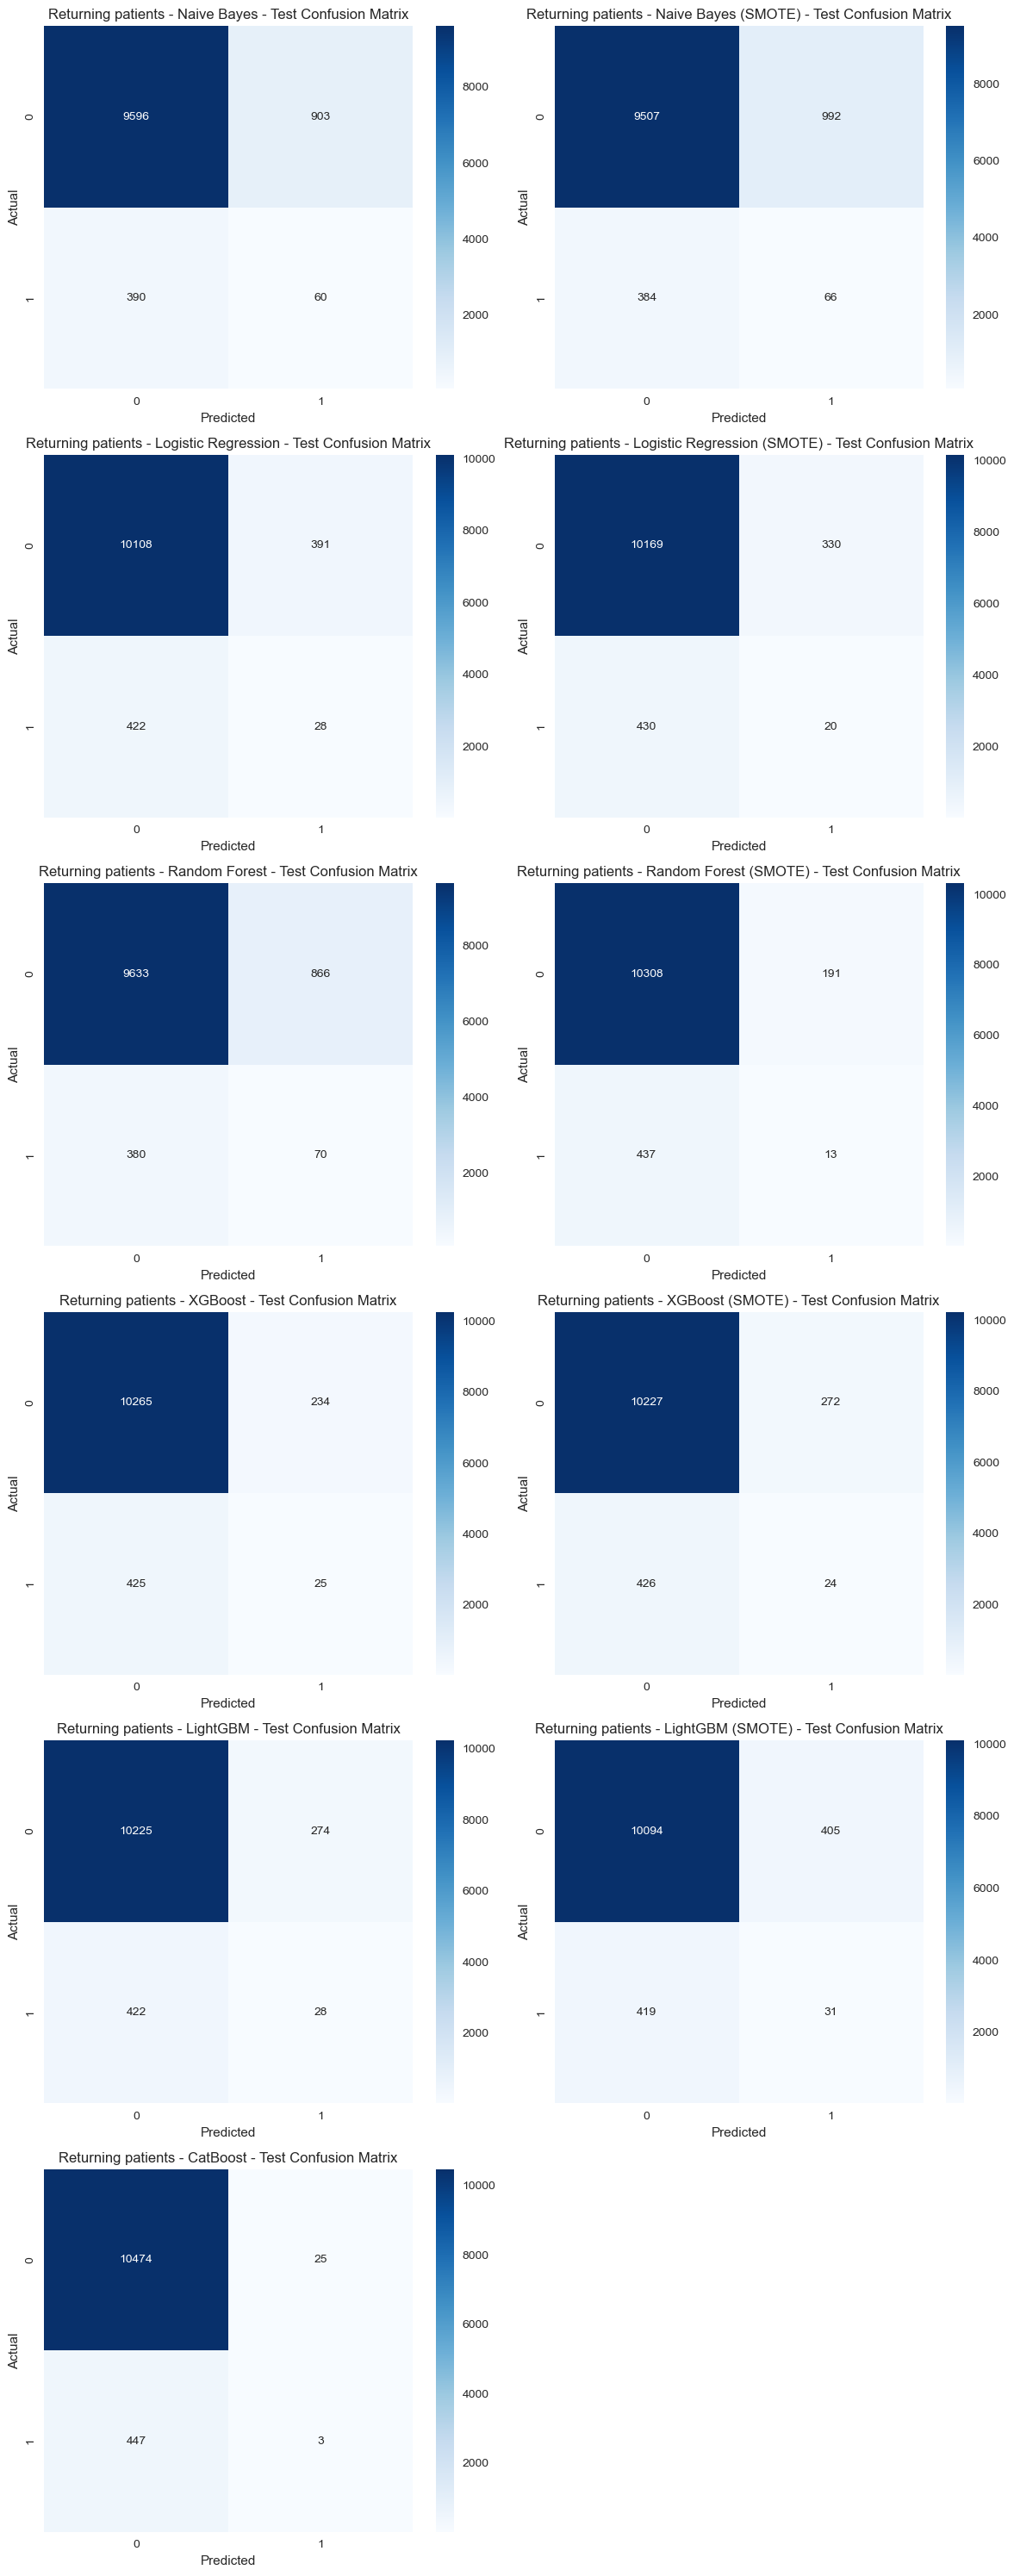

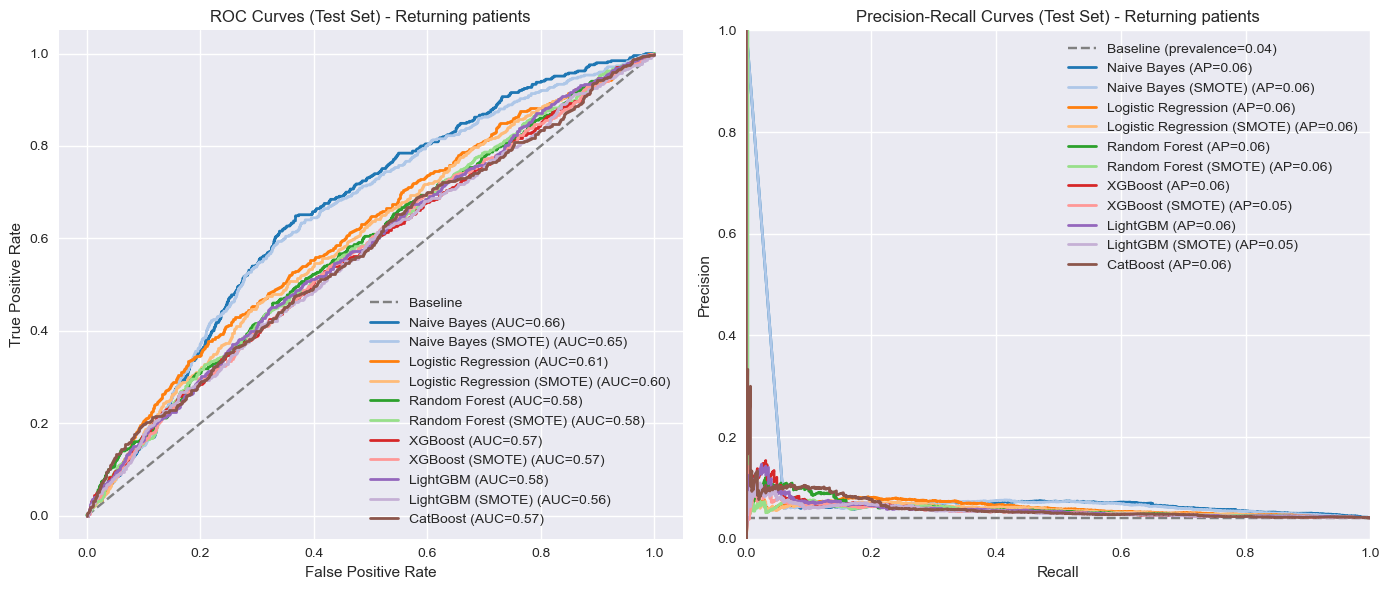

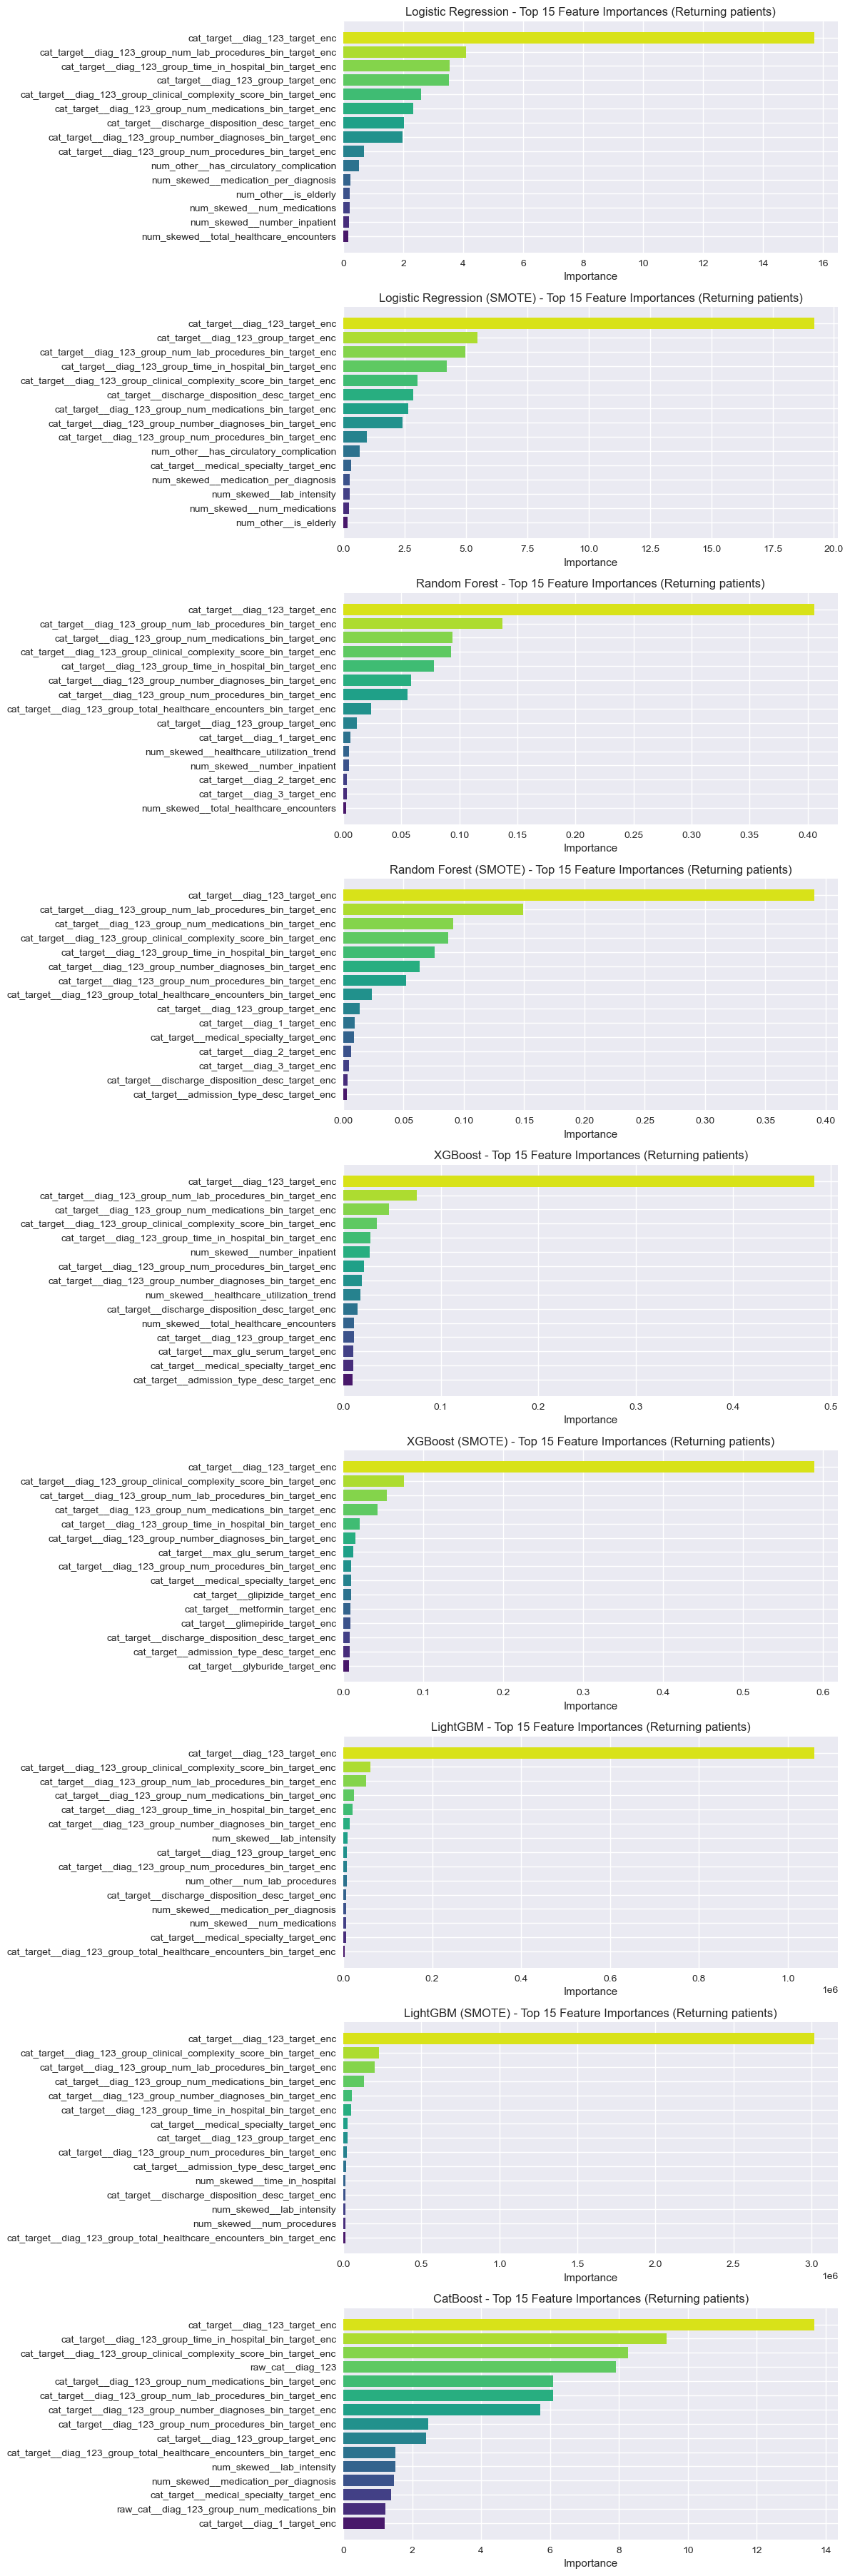

Detected model type: GaussianNB
Using general SHAP Explainer
SHAP.Explainer failed (The passed model is not callable and cannot be analyzed directly with the given masker! Model: GaussianNB()); falling back to TreeExplainer...
All SHAP methods failed: Model type not yet supported by TreeExplainer: <class 'sklearn.naive_bayes.GaussianNB'>
   Model type: GaussianNB
   X_test shape: (10949, 38)
   X_train shape: (43796, 38)


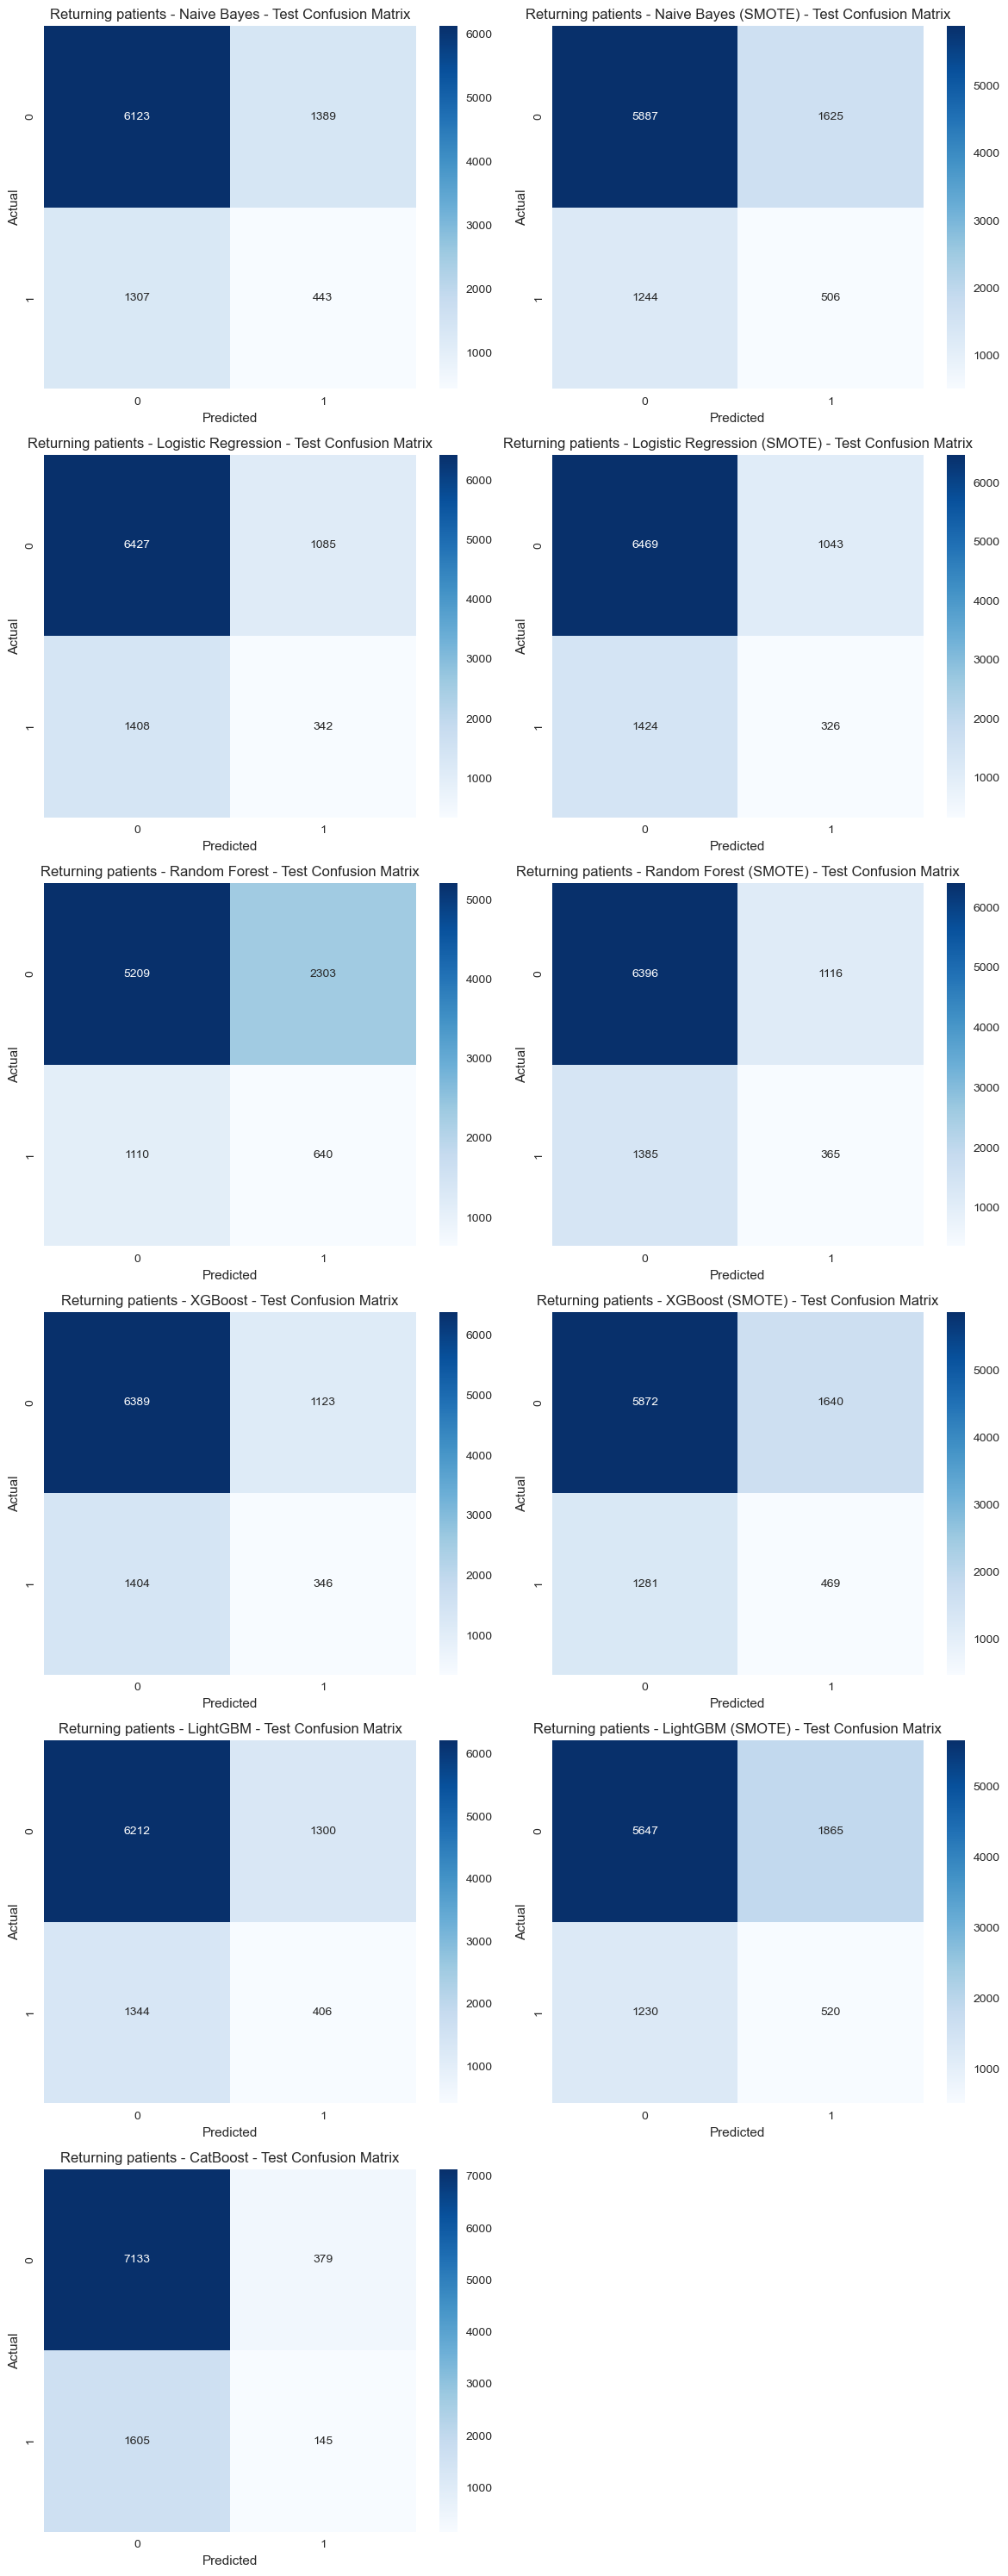

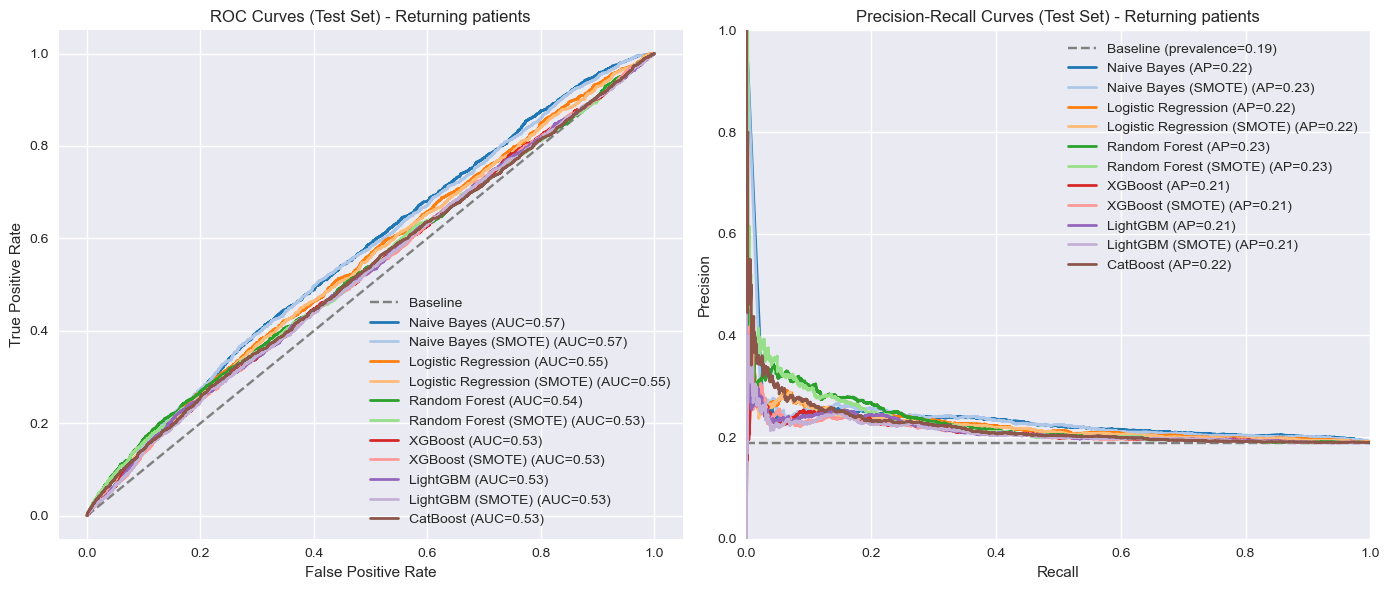

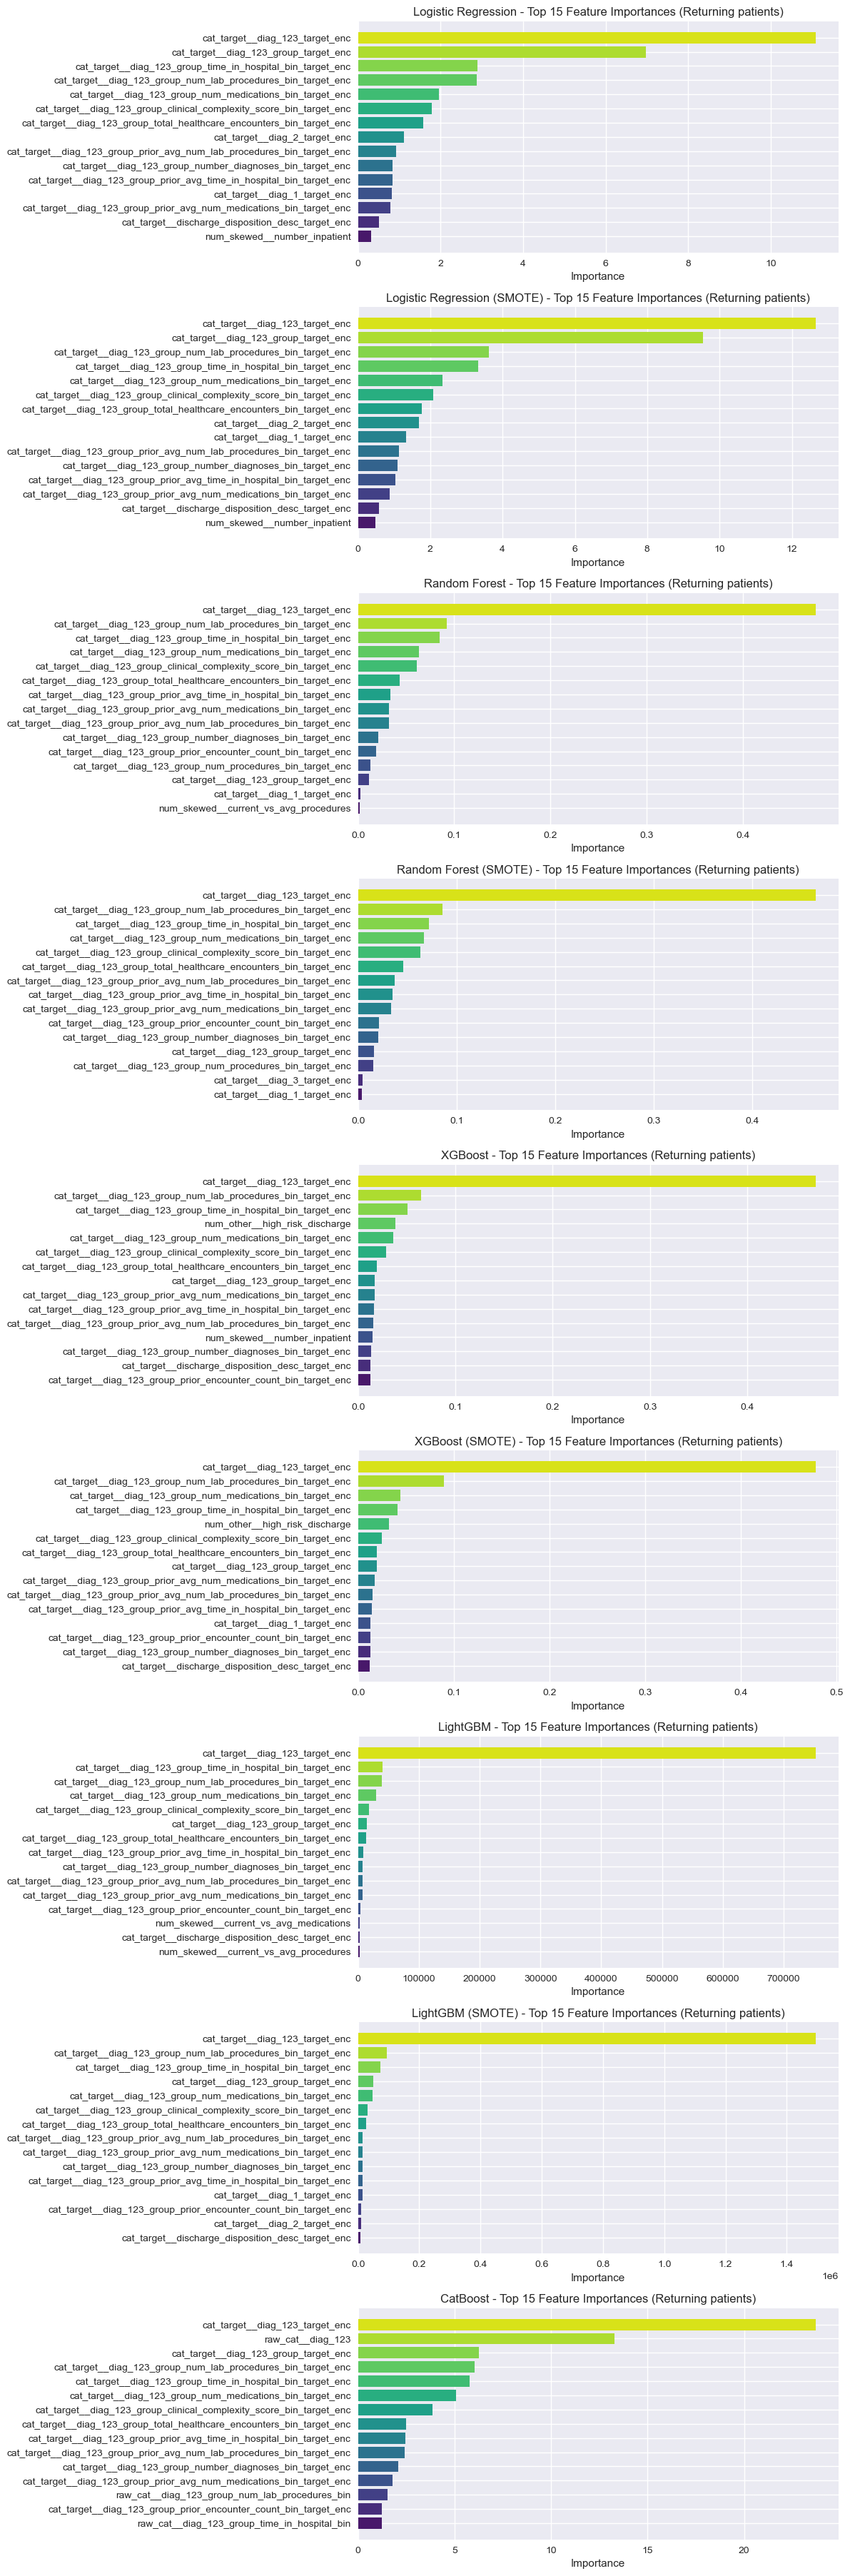

Detected model type: GaussianNB
Using general SHAP Explainer
SHAP.Explainer failed (The passed model is not callable and cannot be analyzed directly with the given masker! Model: GaussianNB()); falling back to TreeExplainer...
All SHAP methods failed: Model type not yet supported by TreeExplainer: <class 'sklearn.naive_bayes.GaussianNB'>
   Model type: GaussianNB
   X_test shape: (9262, 34)
   X_train shape: (37697, 34)


In [ ]:
for group, payload in group_results.items():
    results = payload["results"]
    y_test = payload["y_test"]
    X_train_final = payload["X_train_final"]
    X_test_final = payload["X_test_final"]
    selected_features = payload["selected_features"]
    best_model_name = payload["best_model_name"]
    best_model_payload = payload["best_model_payload"]
    run_display_summary(results, group_name, y_test, X_train_final, X_test_final, selected_features, best_model_name, best_model_payload)

In [ ]:
selector = group_results['Single-encounter patients']['feature_selector']
len(selector.selected_features_), selector.selected_features_[:5]

(38,
 ['num_skewed__discharge_disposition_id',
  'num_skewed__time_in_hospital',
  'num_skewed__num_procedures',
  'num_skewed__num_medications',
  'num_skewed__number_inpatient'])

In [ ]:
best_model_summary = []
for group, payload in group_results.items():
    best_name = payload['best_model_name']
    best_metrics = payload['results'][best_name]['test']
    best_model_summary.append({
        'group': group,
        'best_model': best_name,
        'precision': best_metrics['precision'],
        'recall': best_metrics['recall'],
        'f1': best_metrics['f1'],
        'roc_auc': best_metrics['roc_auc'],
        'avg_precision': best_metrics['average_precision'],
        'accuracy': best_metrics['accuracy'],
        'balanced_accuracy': best_metrics['balanced_accuracy'],
        'specificity': best_metrics['specificity']
    })
pd.DataFrame(best_model_summary)

group   best_model  precision    recall        f1  \
0  Single-encounter patients  Naive Bayes   0.062305  0.133333  0.084926   
1         Returning patients  Naive Bayes   0.241812  0.253143  0.247348   

    roc_auc  avg_precision  accuracy  balanced_accuracy  specificity  
0  0.656193       0.063813  0.881907           0.523663     0.913992  
1  0.568506       0.224687  0.708918           0.534119     0.815096

In [ ]:
# Performance analysis breakdown by selected features
for group, payload in group_results.items():
    X_test_final = payload['X_test_final']
    y_test = payload['y_test']
    best_estimator = payload['best_model_payload']['estimator']
    test_metadata = df.loc[X_test_final.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]
    print(f'==={group} CONFUSION MATRIX ANALYSIS BY FEATURE===')
    for feature in test_metadata.columns:
        print(f"\nConfusion breakdown by {feature}:")
        display(confusion_breakdown(best_estimator, X_test_final, y_test, test_metadata, feature))

===Single-encounter patients CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support    TN   FP   FN  TP  f1_score  precision  \
3        Caucasian     7946  6957  667  279  43  0.083333   0.060563   
1  AfricanAmerican     2407  2116  190   85  16  0.104235   0.077670   
4         Hispanic      203   182   13    7   1  0.090909   0.071429   
0                ?      194   169   16    9   0  0.000000   0.000000   
5            Other      153   136   11    6   0  0.000000   0.000000   
2            Asian       46    36    6    4   0  0.000000   0.000000   

     recall  specificity   roc_auc  
3  0.133540     0.912513  0.523027  
1  0.158416     0.917606  0.538011  
4  0.125000     0.933333  0.529167  
0  0.000000     0.913514  0.456757  
5  0.000000     0.925170  0.462585  
2  0.000000     0.857143  0.428571


Confusion breakdown by age:


age  support    TN   FP   FN  TP  f1_score  precision    recall  \
7   [70-80)     2905  2546  241  101  17  0.090426   0.065891  0.144068   
6   [60-70)     2395  2103  205   75  12  0.078947   0.055300  0.137931   
5   [50-60)     2006  1766  147   78  15  0.117647   0.092593  0.161290   
8   [80-90)     1337  1160  124   47   6  0.065574   0.046154  0.113208   
4   [40-50)     1177  1027  104   40   6  0.076923   0.054545  0.130435   
3   [30-40)      492   439   31   20   2  0.072727   0.060606  0.090909   
9  [90-100)      192   167   13   12   0  0.000000   0.000000  0.000000   
1   [10-20)      190   163   19    6   2  0.137931   0.095238  0.250000   
2   [20-30)      184   161   14    9   0  0.000000   0.000000  0.000000   
0    [0-10)       71    64    5    2   0  0.000000   0.000000  0.000000   

   specificity   roc_auc  
7     0.913527  0.528797  
6     0.911179  0.524555  
5     0.923157  0.542224  
8     0.903427  0.508317  
4     0.908046  0.519240  
3     0.934043  0.512476  
9     0.927778  0.463889  
1     0.895604  0.572802  
2     0.920000  0.460000  
0     0.927536  0.463768


Confusion breakdown by diag_1_group:


diag_1_group  support    TN   FP  \
0                                         Circulatory     3947  3473  335   
10                                        Respiratory     1267  1106  100   
1                                            Diabetes     1061   935   80   
2                                           Digestive      904   790   68   
6                                              Injury      696   609   62   
7                                     Musculoskeletal      473   413   38   
4                                       Genitourinary      447   390   38   
8                                           Neoplasms      384   333   35   
17        symptoms, signs, and ill-defined conditions      309   267   31   
16                                   mental disorders      305   273   18   
3   Endocrine, nutritional and metabolic diseases,...      228   194   25   
15       diseases of the skin and subcutaneous tissue      220   190   23   
5                   Infectious and parasitic diseases      201   182   14   
9                                               Other      187   157   19   
14    diseases of the nervous system and sense organs      112   100    7   
11  complications of pregnancy, childbirth, and th...      107    96    5   
13     diseases of the blood and blood-forming organs       97    84    5   
12                               congenital anomalies        4     4    0   

     FN  TP  f1_score  precision    recall  specificity   roc_auc  
0   125  14  0.057377   0.040115  0.100719     0.912027  0.506373  
10   51  10  0.116959   0.090909  0.163934     0.917081  0.540508  
1    38   8  0.119403   0.090909  0.173913     0.921182  0.547548  
2    34  12  0.190476   0.150000  0.260870     0.920746  0.590808  
6    25   0  0.000000   0.000000  0.000000     0.907601  0.453800  
7    19   3  0.095238   0.073171  0.136364     0.915743  0.526053  
4    15   4  0.131148   0.095238  0.210526     0.911215  0.560871  
8    16   0  0.000000   0.000000  0.000000     0.904891  0.452446  
17   11   0  0.000000   0.000000  0.000000     0.895973  0.447987  
16   12   2  0.117647   0.100000  0.142857     0.938144  0.540501  
3     7   2  0.111111   0.074074  0.222222     0.885845  0.554033  
15    6   1  0.064516   0.041667  0.142857     0.892019  0.517438  
5     5   0  0.000000   0.000000  0.000000     0.928571  0.464286  
9     8   3  0.181818   0.136364  0.272727     0.892045  0.582386  
14    4   1  0.153846   0.125000  0.200000     0.934579  0.567290  
11    6   0  0.000000   0.000000  0.000000     0.950495  0.475248  
13    8   0  0.000000   0.000000  0.000000     0.943820  0.471910  
12    0   0  0.000000        NaN       NaN     1.000000       NaN


Confusion breakdown by diag_2_group:


diag_2_group  support    TN   FP  \
0                                         Circulatory     3625  3185  303   
1                                            Diabetes     2039  1791  169   
10                                        Respiratory      994   868   87   
3   Endocrine, nutritional and metabolic diseases,...      792   690   64   
4                                       Genitourinary      620   533   52   
2                                           Digestive      413   360   38   
9                                               Other      333   292   27   
15       diseases of the skin and subcutaneous tissue      319   283   25   
8                                           Neoplasms      280   246   22   
13     diseases of the blood and blood-forming organs      269   231   20   
17        symptoms, signs, and ill-defined conditions      269   228   28   
16                                   mental disorders      258   244    9   
6                                              Injury      241   216   14   
5                   Infectious and parasitic diseases      202   180   16   
7                                     Musculoskeletal      132   107   18   
14    diseases of the nervous system and sense organs       95    82    9   
11  complications of pregnancy, childbirth, and th...       60    53    2   
12                               congenital anomalies        8     7    0   

     FN  TP  f1_score  precision    recall  specificity   roc_auc  
0   121  16  0.070175   0.050157  0.116788     0.913131  0.514960  
1    72   7  0.054902   0.039773  0.088608     0.913776  0.501192  
10   35   4  0.061538   0.043956  0.102564     0.908901  0.505732  
3    26  12  0.210526   0.157895  0.315789     0.915119  0.615454  
4    33   2  0.044944   0.037037  0.057143     0.911111  0.484127  
2    13   2  0.072727   0.050000  0.133333     0.904523  0.518928  
9    11   3  0.136364   0.100000  0.214286     0.915361  0.564823  
15   10   1  0.054054   0.038462  0.090909     0.918831  0.504870  
8    12   0  0.000000   0.000000  0.000000     0.917910  0.458955  
13   11   7  0.311111   0.259259  0.388889     0.920319  0.654604  
17   11   2  0.093023   0.066667  0.153846     0.890625  0.522236  
16    4   1  0.133333   0.100000  0.200000     0.964427  0.582213  
6    10   1  0.076923   0.066667  0.090909     0.939130  0.515020  
5     5   1  0.086957   0.058824  0.166667     0.918367  0.542517  
7     6   1  0.076923   0.052632  0.142857     0.856000  0.499429  
14    4   0  0.000000   0.000000  0.000000     0.901099  0.450549  
11    5   0  0.000000   0.000000  0.000000     0.963636  0.481818  
12    1   0  0.000000        NaN  0.000000     1.000000  0.500000


Confusion breakdown by diag_3_group:


diag_3_group  support    TN   FP  \
0                                         Circulatory     3317  2914  273   
1                                            Diabetes     2211  1920  200   
3   Endocrine, nutritional and metabolic diseases,...      843   736   77   
9                                               Other      805   715   60   
10                                        Respiratory      708   621   60   
4                                       Genitourinary      570   505   44   
2                                           Digestive      404   348   34   
16                                   mental disorders      342   305   19   
17        symptoms, signs, and ill-defined conditions      251   217   17   
13     diseases of the blood and blood-forming organs      227   196   21   
5                   Infectious and parasitic diseases      225   187   28   
15       diseases of the skin and subcutaneous tissue      220   201   10   
14    diseases of the nervous system and sense organs      214   192   14   
6                                              Injury      193   170   14   
8                                           Neoplasms      180   162   12   
7                                     Musculoskeletal      177   151   16   
11  complications of pregnancy, childbirth, and th...       53    50    1   
12                               congenital anomalies        9     6    3   

     FN  TP  f1_score  precision    recall  specificity   roc_auc  
0   116  14  0.067146   0.048780  0.107692     0.914340  0.511016  
1    76  15  0.098039   0.069767  0.164835     0.905660  0.535248  
3    26   4  0.072072   0.049383  0.133333     0.905289  0.519311  
9    27   3  0.064516   0.047619  0.100000     0.922581  0.511290  
10   25   2  0.044944   0.032258  0.074074     0.911894  0.492984  
4    18   3  0.088235   0.063830  0.142857     0.919854  0.531356  
2    16   6  0.193548   0.150000  0.272727     0.910995  0.591861  
16   14   4  0.195122   0.173913  0.222222     0.941358  0.581790  
17   15   2  0.111111   0.105263  0.117647     0.927350  0.522499  
13    9   1  0.062500   0.045455  0.100000     0.903226  0.501613  
5    10   0  0.000000   0.000000  0.000000     0.869767  0.434884  
15    8   1  0.100000   0.090909  0.111111     0.952607  0.531859  
14    8   0  0.000000   0.000000  0.000000     0.932039  0.466019  
6     8   1  0.083333   0.066667  0.111111     0.923913  0.517512  
8     4   2  0.200000   0.142857  0.333333     0.931034  0.632184  
7     8   2  0.142857   0.111111  0.200000     0.904192  0.552096  
11    2   0  0.000000   0.000000  0.000000     0.980392  0.490196  
12    0   0  0.000000   0.000000       NaN     0.666667       NaN

===Returning patients CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support    TN   FP   FN   TP  f1_score  precision  \
3        Caucasian     6690  4444  997  914  335  0.259589   0.251502   
1  AfricanAmerican     2059  1350  317  302   90  0.225282   0.221130   
0                ?      172   103   26   35    8  0.207792   0.235294   
4         Hispanic      168   108   25   31    4  0.125000   0.137931   
5            Other      132    94   14   18    6  0.272727   0.300000   
2            Asian       41    24   10    7    0  0.000000   0.000000   

     recall  specificity   roc_auc  
3  0.268215     0.816762  0.542488  
1  0.229592     0.809838  0.519715  
0  0.186047     0.798450  0.492248  
4  0.114286     0.812030  0.463158  
5  0.250000     0.870370  0.560185  
2  0.000000     0.705882  0.352941


Confusion breakdown by age:


age  support    TN   FP   FN   TP  f1_score  precision    recall  \
7   [70-80)     2456  1633  366  342  115  0.245203   0.239085  0.251641   
6   [60-70)     2000  1322  299  274  105  0.268199   0.259901  0.277045   
5   [50-60)     1716  1152  268  229   67  0.212361   0.200000  0.226351   
8   [80-90)     1145   754  162  166   63  0.277533   0.280000  0.275109   
4   [40-50)      999   637  154  167   41  0.203474   0.210256  0.197115   
3   [30-40)      411   280   46   60   25  0.320513   0.352113  0.294118   
9  [90-100)      164   106   29   20    9  0.268657   0.236842  0.310345   
1   [10-20)      162   108   25   22    7  0.229508   0.218750  0.241379   
2   [20-30)      144    88   25   21   10  0.303030   0.285714  0.322581   
0    [0-10)       65    43   15    6    1  0.086957   0.062500  0.142857   

   specificity   roc_auc  
7     0.816908  0.534275  
6     0.815546  0.546295  
5     0.811268  0.518809  
8     0.823144  0.549127  
4     0.805310  0.501213  
3     0.858896  0.576507  
9     0.785185  0.547765  
1     0.812030  0.526705  
2     0.778761  0.550671  
0     0.741379  0.442118


Confusion breakdown by diag_1_group:


diag_1_group  support    TN   FP  \
0                                         Circulatory     3345  2165  518   
10                                        Respiratory     1073   731  155   
1                                            Diabetes      914   593  150   
2                                           Digestive      749   499  114   
6                                              Injury      588   389   92   
7                                     Musculoskeletal      394   272   57   
4                                       Genitourinary      382   250   55   
8                                           Neoplasms      333   222   48   
16                                   mental disorders      254   169   37   
17        symptoms, signs, and ill-defined conditions      250   179   33   
3   Endocrine, nutritional and metabolic diseases,...      186   124   22   
15       diseases of the skin and subcutaneous tissue      182   117   26   
5                   Infectious and parasitic diseases      179   112   34   
9                                               Other      156   103   22   
14    diseases of the nervous system and sense organs      101    72   11   
11  complications of pregnancy, childbirth, and th...       93    68    7   
13     diseases of the blood and blood-forming organs       80    56    8   
12                               congenital anomalies        3     2    0   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   497  165  0.245353   0.241581  0.249245     0.806933  0.528089  
10  146   41  0.214099   0.209184  0.219251     0.825056  0.522154  
1   127   44  0.241096   0.226804  0.257310     0.798116  0.527713  
2    97   39  0.269896   0.254902  0.286765     0.814029  0.550397  
6    77   30  0.262009   0.245902  0.280374     0.808732  0.544553  
7    50   15  0.218978   0.208333  0.230769     0.826748  0.528758  
4    61   16  0.216216   0.225352  0.207792     0.819672  0.513732  
8    46   17  0.265625   0.261538  0.269841     0.822222  0.546032  
16   38   10  0.210526   0.212766  0.208333     0.820388  0.514361  
17   27   11  0.268293   0.250000  0.289474     0.844340  0.566907  
3    29   11  0.301370   0.333333  0.275000     0.849315  0.562158  
15   32    7  0.194444   0.212121  0.179487     0.818182  0.498834  
5    23   10  0.259740   0.227273  0.303030     0.767123  0.535077  
9    22    9  0.290323   0.290323  0.290323     0.824000  0.557161  
14   14    4  0.242424   0.266667  0.222222     0.867470  0.544846  
11    9    9  0.529412   0.562500  0.500000     0.906667  0.703333  
13   11    5  0.344828   0.384615  0.312500     0.875000  0.593750  
12    1    0  0.000000        NaN  0.000000     1.000000  0.500000


Confusion breakdown by diag_2_group:


diag_2_group  support    TN   FP  \
0                                         Circulatory     3081  1995  476   
1                                            Diabetes     1721  1155  242   
10                                        Respiratory      834   555  134   
3   Endocrine, nutritional and metabolic diseases,...      659   436  109   
4                                       Genitourinary      520   343   80   
2                                           Digestive      355   241   47   
9                                               Other      296   196   47   
15       diseases of the skin and subcutaneous tissue      274   187   25   
8                                           Neoplasms      244   150   40   
13     diseases of the blood and blood-forming organs      228   144   43   
16                                   mental disorders      215   159   26   
17        symptoms, signs, and ill-defined conditions      210   155   18   
6                                              Injury      207   132   36   
5                   Infectious and parasitic diseases      171   105   28   
7                                     Musculoskeletal      112    82   17   
14    diseases of the nervous system and sense organs       80    51   15   
11  complications of pregnancy, childbirth, and th...       50    34    5   
12                               congenital anomalies        5     3    1   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   440  170  0.270701   0.263158  0.278689     0.807365  0.543027  
1   267   57  0.182986   0.190635  0.175926     0.826772  0.501349  
10  105   40  0.250784   0.229885  0.275862     0.805515  0.540689  
3    86   28  0.223108   0.204380  0.245614     0.800000  0.522807  
4    68   29  0.281553   0.266055  0.298969     0.810875  0.554922  
2    48   19  0.285714   0.287879  0.283582     0.836806  0.560194  
9    40   13  0.230088   0.216667  0.245283     0.806584  0.525934  
15   49   13  0.260000   0.342105  0.209677     0.882075  0.545876  
8    41   13  0.242991   0.245283  0.240741     0.789474  0.515107  
13   30   11  0.231579   0.203704  0.268293     0.770053  0.519173  
16   25    5  0.163934   0.161290  0.166667     0.859459  0.513063  
17   23   14  0.405797   0.437500  0.378378     0.895954  0.637166  
6    29   10  0.235294   0.217391  0.256410     0.785714  0.521062  
5    32    6  0.166667   0.176471  0.157895     0.789474  0.473684  
7     8    5  0.285714   0.227273  0.384615     0.828283  0.606449  
14    9    5  0.294118   0.250000  0.357143     0.772727  0.564935  
11    6    5  0.476190   0.500000  0.454545     0.871795  0.663170  
12    1    0  0.000000   0.000000  0.000000     0.750000  0.375000


Confusion breakdown by diag_3_group:


diag_3_group  support    TN   FP  \
0                                         Circulatory     2801  1855  439   
1                                            Diabetes     1896  1227  304   
3   Endocrine, nutritional and metabolic diseases,...      696   450  118   
9                                               Other      685   459   94   
10                                        Respiratory      608   411   75   
4                                       Genitourinary      484   327   69   
2                                           Digestive      335   214   55   
16                                   mental disorders      274   173   46   
17        symptoms, signs, and ill-defined conditions      205   134   35   
13     diseases of the blood and blood-forming organs      191   127   29   
5                   Infectious and parasitic diseases      190   123   26   
15       diseases of the skin and subcutaneous tissue      187   126   18   
14    diseases of the nervous system and sense organs      179   128   20   
6                                              Injury      172   123   20   
7                                     Musculoskeletal      156   110   19   
8                                           Neoplasms      149    97   20   
11  complications of pregnancy, childbirth, and th...       47    35    1   
12                               congenital anomalies        7     4    1   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   377  130  0.241636   0.228471  0.256410     0.808631  0.532521  
1   267   98  0.255541   0.243781  0.268493     0.801437  0.534965  
3    96   32  0.230216   0.213333  0.250000     0.792254  0.521127  
9    95   37  0.281369   0.282443  0.280303     0.830018  0.555161  
10   94   28  0.248889   0.271845  0.229508     0.845679  0.537594  
4    70   18  0.205714   0.206897  0.204545     0.825758  0.515152  
2    47   19  0.271429   0.256757  0.287879     0.795539  0.541709  
16   38   17  0.288136   0.269841  0.309091     0.789954  0.549523  
17   31    5  0.131579   0.125000  0.138889     0.792899  0.465894  
13   30    5  0.144928   0.147059  0.142857     0.814103  0.478480  
5    37    4  0.112676   0.133333  0.097561     0.825503  0.461532  
15   32   11  0.305556   0.379310  0.255814     0.875000  0.565407  
14   19   12  0.380952   0.375000  0.387097     0.864865  0.625981  
6    23    6  0.218182   0.230769  0.206897     0.860140  0.533518  
7    21    6  0.230769   0.240000  0.222222     0.852713  0.537468  
8    21   11  0.349206   0.354839  0.343750     0.829060  0.586405  
11    7    4  0.500000   0.800000  0.363636     0.972222  0.667929  
12    2    0  0.000000   0.000000  0.000000     0.800000  0.400000

===Patient centric_All Patients CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support     TN    FP    FN   TP  f1_score  precision  \
3        Caucasian    14852  11256  1932  1312  352  0.178318   0.154116   
1  AfricanAmerican     4371   3343   536   400   92  0.164286   0.146497   
4         Hispanic      441    353    52    26   10  0.204082   0.161290   
0                ?      326    238    48    27   13  0.257426   0.213115   
5            Other      289    230    29    27    3  0.096774   0.093750   
2            Asian       75     53     8    11    3  0.240000   0.272727   

     recall  specificity   roc_auc  
3  0.211538     0.853503  0.532521  
1  0.186992     0.861820  0.524406  
4  0.277778     0.871605  0.574691  
0  0.325000     0.832168  0.578584  
5  0.100000     0.888031  0.494015  
2  0.214286     0.868852  0.541569


Confusion breakdown by age:


age  support    TN   FP   FN   TP  f1_score  precision    recall  \
7   [70-80)     5383  4087  689  492  115  0.163005   0.143035  0.189456   
6   [60-70)     4400  3332  577  404   87  0.150649   0.131024  0.177189   
5   [50-60)     3675  2805  449  334   87  0.181818   0.162313  0.206651   
8   [80-90)     2610  1984  342  225   59  0.172263   0.147132  0.207746   
4   [40-50)     2221  1701  288  180   52  0.181818   0.152941  0.224138   
3   [30-40)      933   701  133   70   29  0.222222   0.179012  0.292929   
9  [90-100)      366   272   43   31   20  0.350877   0.317460  0.392157   
2   [20-30)      332   250   40   33    9  0.197802   0.183673  0.214286   
1   [10-20)      324   255   30   27   12  0.296296   0.285714  0.307692   
0    [0-10)      110    86   14    7    3  0.222222   0.176471  0.300000   

   specificity   roc_auc  
7     0.855737  0.522597  
6     0.852392  0.514791  
5     0.862016  0.534333  
8     0.852966  0.530356  
4     0.855204  0.539671  
3     0.840528  0.566728  
9     0.863492  0.627824  
2     0.862069  0.538177  
1     0.894737  0.601215  
0     0.860000  0.580000


Confusion breakdown by diag_1_group:


diag_1_group  support    TN   FP  \
0                                         Circulatory     7091  5430  877   
10                                        Respiratory     2548  1913  346   
1                                            Diabetes     1930  1476  247   
2                                           Digestive     1731  1302  212   
6                                              Injury     1283   974  168   
7                                     Musculoskeletal      916   677  120   
4                                       Genitourinary      761   588   88   
8                                           Neoplasms      714   538  103   
17        symptoms, signs, and ill-defined conditions      596   457   76   
16                                   mental disorders      528   389   76   
3   Endocrine, nutritional and metabolic diseases,...      484   378   62   
15       diseases of the skin and subcutaneous tissue      448   346   59   
9                                               Other      391   292   52   
5                   Infectious and parasitic diseases      372   279   40   
14    diseases of the nervous system and sense organs      216   156   41   
13     diseases of the blood and blood-forming organs      171   132   24   
11  complications of pregnancy, childbirth, and th...      166   141   12   
12                               congenital anomalies        8     5    2   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   632  152  0.167678   0.147716  0.193878     0.860948  0.527413  
10  228   61  0.175287   0.149877  0.211073     0.846835  0.528954  
1   155   52  0.205534   0.173913  0.251208     0.856645  0.553927  
2   168   49  0.205021   0.187739  0.225806     0.859974  0.542890  
6   112   29  0.171598   0.147208  0.205674     0.852890  0.529282  
7   102   17  0.132812   0.124088  0.142857     0.849435  0.496146  
4    60   25  0.252525   0.221239  0.294118     0.869822  0.581970  
8    61   12  0.127660   0.104348  0.164384     0.839314  0.501849  
17   48   15  0.194805   0.164835  0.238095     0.857411  0.547753  
16   47   16  0.206452   0.173913  0.253968     0.836559  0.545264  
3    38    6  0.107143   0.088235  0.136364     0.859091  0.497727  
15   33   10  0.178571   0.144928  0.232558     0.854321  0.543440  
9    39    8  0.149533   0.133333  0.170213     0.848837  0.509525  
5    38   15  0.277778   0.272727  0.283019     0.874608  0.578814  
14   19    0  0.000000   0.000000  0.000000     0.791878  0.395939  
13   12    3  0.142857   0.111111  0.200000     0.846154  0.523077  
11   10    3  0.214286   0.200000  0.230769     0.921569  0.576169  
12    1    0  0.000000   0.000000  0.000000     0.714286  0.357143


Confusion breakdown by diag_2_group:


diag_2_group  support    TN   FP  \
0                                         Circulatory     6824  5183  883   
1                                            Diabetes     3608  2744  459   
10                                        Respiratory     1919  1490  219   
3   Endocrine, nutritional and metabolic diseases,...     1459  1129  182   
4                                       Genitourinary     1207   897  153   
2                                           Digestive      775   566  112   
15       diseases of the skin and subcutaneous tissue      642   488   85   
9                                               Other      588   457   68   
16                                   mental disorders      502   390   61   
17        symptoms, signs, and ill-defined conditions      484   370   56   
8                                           Neoplasms      474   348   82   
13     diseases of the blood and blood-forming organs      474   350   66   
6                                              Injury      460   351   57   
5                   Infectious and parasitic diseases      356   269   49   
7                                     Musculoskeletal      283   209   39   
14    diseases of the nervous system and sense organs      190   141   25   
11  complications of pregnancy, childbirth, and th...       93    76    8   
12                               congenital anomalies       16    15    1   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   602  156  0.173623   0.150144  0.205805     0.854435  0.530120  
1   321   84  0.177215   0.154696  0.207407     0.856697  0.532052  
10  171   39  0.166667   0.151163  0.185714     0.871855  0.528785  
3   108   40  0.216216   0.180180  0.270270     0.861175  0.565722  
4   129   28  0.165680   0.154696  0.178344     0.854286  0.516315  
2    68   29  0.243697   0.205674  0.298969     0.834808  0.566889  
15   53   16  0.188235   0.158416  0.231884     0.851658  0.541771  
9    52   11  0.154930   0.139241  0.174603     0.870476  0.522540  
16   39   12  0.193548   0.164384  0.235294     0.864745  0.550020  
17   47   11  0.176000   0.164179  0.189655     0.868545  0.529100  
8    38    6  0.090909   0.068182  0.136364     0.809302  0.472833  
13   49    9  0.135338   0.120000  0.155172     0.841346  0.498259  
6    40   12  0.198347   0.173913  0.230769     0.860294  0.545532  
5    32    6  0.129032   0.109091  0.157895     0.845912  0.501903  
7    28    7  0.172840   0.152174  0.200000     0.842742  0.521371  
14   18    6  0.218182   0.193548  0.250000     0.849398  0.549699  
11    8    1  0.111111   0.111111  0.111111     0.904762  0.507937  
12    0    0  0.000000   0.000000       NaN     0.937500       NaN


Confusion breakdown by diag_3_group:


diag_3_group  support    TN   FP  \
0                                         Circulatory     6156  4679  793   
1                                            Diabetes     4132  3165  525   
3   Endocrine, nutritional and metabolic diseases,...     1588  1192  212   
9                                               Other     1481  1147  169   
10                                        Respiratory     1382  1063  166   
4                                       Genitourinary     1043   793  152   
2                                           Digestive      778   568  110   
16                                   mental disorders      637   475   86   
17        symptoms, signs, and ill-defined conditions      471   357   57   
15       diseases of the skin and subcutaneous tissue      436   326   65   
13     diseases of the blood and blood-forming organs      417   305   51   
5                   Infectious and parasitic diseases      374   283   54   
14    diseases of the nervous system and sense organs      373   281   49   
7                                     Musculoskeletal      352   269   38   
6                                              Injury      341   260   35   
8                                           Neoplasms      293   226   36   
11  complications of pregnancy, childbirth, and th...       82    72    5   
12                               congenital anomalies       18    12    2   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   535  149  0.183272   0.158174  0.217836     0.855080  0.536458  
1   361   81  0.154580   0.133663  0.183258     0.857724  0.520491  
3   146   38  0.175115   0.152000  0.206522     0.849003  0.527762  
9   142   23  0.128852   0.119792  0.139394     0.871581  0.505487  
10  124   29  0.166667   0.148718  0.189542     0.864931  0.527237  
4    74   24  0.175182   0.136364  0.244898     0.839153  0.542026  
2    76   24  0.205128   0.179104  0.240000     0.837758  0.538879  
16   58   18  0.200000   0.173077  0.236842     0.846702  0.541772  
17   47   10  0.161290   0.149254  0.175439     0.862319  0.518879  
15   33   12  0.196721   0.155844  0.266667     0.833760  0.550213  
13   49   12  0.193548   0.190476  0.196721     0.856742  0.526731  
5    27   10  0.198020   0.156250  0.270270     0.839763  0.555016  
14   32   11  0.213592   0.183333  0.255814     0.851515  0.553665  
7    38    7  0.155556   0.155556  0.155556     0.876221  0.515889  
6    32   14  0.294737   0.285714  0.304348     0.881356  0.592852  
8    23    8  0.213333   0.181818  0.258065     0.862595  0.560330  
11    3    2  0.333333   0.285714  0.400000     0.935065  0.667532  
12    3    1  0.285714   0.333333  0.250000     0.857143  0.553571

===Encounter centric_All Patients CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support     TN    FP    FN   TP  f1_score  precision  \
3        Caucasian    14852  11375  1822  1299  356  0.185755   0.163453   
1  AfricanAmerican     4371   3329   550   399   93  0.163877   0.144635   
4         Hispanic      441    343    53    39    6  0.115385   0.101695   
0                ?      326    245    39    30   12  0.258065   0.235294   
5            Other      289    226    38    19    6  0.173913   0.136364   
2            Asian       75     51    12    10    2  0.153846   0.142857   

     recall  specificity   roc_auc  
3  0.215106     0.861938  0.538522  
1  0.189024     0.858211  0.523618  
4  0.133333     0.866162  0.499747  
0  0.285714     0.862676  0.574195  
5  0.240000     0.856061  0.548030  
2  0.166667     0.809524  0.488095


Confusion breakdown by age:


age  support    TN   FP   FN   TP  f1_score  precision    recall  \
7   [70-80)     5383  4082  669  508  124  0.174035   0.156368  0.196203   
6   [60-70)     4400  3364  549  373  114  0.198261   0.171946  0.234086   
5   [50-60)     3675  2825  445  311   94  0.199153   0.174397  0.232099   
8   [80-90)     2610  2013  312  220   65  0.196375   0.172414  0.228070   
4   [40-50)     2221  1730  265  195   31  0.118774   0.104730  0.137168   
3   [30-40)      933   684  135   85   29  0.208633   0.176829  0.254386   
9  [90-100)      366   283   43   35    5  0.113636   0.104167  0.125000   
2   [20-30)      332   247   42   37    6  0.131868   0.125000  0.139535   
1   [10-20)      324   252   42   25    5  0.129870   0.106383  0.166667   
0    [0-10)      110    89   12    7    2  0.173913   0.142857  0.222222   

   specificity   roc_auc  
7     0.859188  0.527695  
6     0.859698  0.546892  
5     0.863914  0.548007  
8     0.865806  0.546938  
4     0.867168  0.502168  
3     0.835165  0.544775  
9     0.868098  0.496549  
2     0.854671  0.497103  
1     0.857143  0.511905  
0     0.881188  0.551705


Confusion breakdown by diag_1_group:


diag_1_group  support    TN   FP  \
0                                         Circulatory     7091  5481  825   
10                                        Respiratory     2548  1949  340   
1                                            Diabetes     1930  1473  247   
2                                           Digestive     1731  1312  220   
6                                              Injury     1283   986  139   
7                                     Musculoskeletal      916   671  135   
4                                       Genitourinary      761   589   93   
8                                           Neoplasms      714   539   89   
17        symptoms, signs, and ill-defined conditions      596   453   84   
16                                   mental disorders      528   398   63   
3   Endocrine, nutritional and metabolic diseases,...      484   365   64   
15       diseases of the skin and subcutaneous tissue      448   338   51   
9                                               Other      391   288   57   
5                   Infectious and parasitic diseases      372   283   36   
14    diseases of the nervous system and sense organs      216   182   19   
13     diseases of the blood and blood-forming organs      171   134   27   
11  complications of pregnancy, childbirth, and th...      166   122   24   
12                               congenital anomalies        8     6    1   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   621  164  0.184893   0.165824  0.208917     0.869172  0.539045  
10  206   53  0.162577   0.134860  0.204633     0.851464  0.528048  
1   166   44  0.175649   0.151203  0.209524     0.856395  0.532960  
2   158   41  0.178261   0.157088  0.206030     0.856397  0.531214  
6   131   27  0.166667   0.162651  0.170886     0.876444  0.523665  
7    84   26  0.191882   0.161491  0.236364     0.832506  0.534435  
4    54   25  0.253807   0.211864  0.316456     0.863636  0.590046  
8    65   21  0.214286   0.190909  0.244186     0.858280  0.551233  
17   53    6  0.080537   0.066667  0.101695     0.843575  0.472635  
16   55   12  0.169014   0.160000  0.179104     0.863341  0.521223  
3    44   11  0.169231   0.146667  0.200000     0.850816  0.525408  
15   47   12  0.196721   0.190476  0.203390     0.868895  0.536142  
9    34   12  0.208696   0.173913  0.260870     0.834783  0.547826  
5    43   10  0.202020   0.217391  0.188679     0.887147  0.537913  
14   11    4  0.210526   0.173913  0.266667     0.905473  0.586070  
13    8    2  0.102564   0.068966  0.200000     0.832298  0.516149  
11   16    4  0.166667   0.142857  0.200000     0.835616  0.517808  
12    0    1  0.666667   0.500000  1.000000     0.857143  0.928571


Confusion breakdown by diag_2_group:


diag_2_group  support    TN   FP  \
0                                         Circulatory     6824  5249  806   
1                                            Diabetes     3608  2708  476   
10                                        Respiratory     1919  1459  237   
3   Endocrine, nutritional and metabolic diseases,...     1459  1140  171   
4                                       Genitourinary     1207   897  181   
2                                           Digestive      775   601   85   
15       diseases of the skin and subcutaneous tissue      642   493   76   
9                                               Other      588   460   70   
16                                   mental disorders      502   387   56   
17        symptoms, signs, and ill-defined conditions      484   363   72   
8                                           Neoplasms      474   362   64   
13     diseases of the blood and blood-forming organs      474   359   60   
6                                              Injury      460   359   47   
5                   Infectious and parasitic diseases      356   277   44   
7                                     Musculoskeletal      283   214   35   
14    diseases of the nervous system and sense organs      190   153   22   
11  complications of pregnancy, childbirth, and th...       93    75   10   
12                               congenital anomalies       16    13    2   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   604  165  0.189655   0.169928  0.214564     0.866887  0.540726  
1   340   84  0.170732   0.150000  0.198113     0.850503  0.524308  
10  172   51  0.199609   0.177083  0.228700     0.860259  0.544479  
3   119   29  0.166667   0.145000  0.195946     0.869565  0.532756  
4    98   31  0.181818   0.146226  0.240310     0.832096  0.536203  
2    72   17  0.178010   0.166667  0.191011     0.876093  0.533552  
15   58   15  0.182927   0.164835  0.205479     0.866432  0.535956  
9    49    9  0.131387   0.113924  0.155172     0.867925  0.511548  
16   44   15  0.230769   0.211268  0.254237     0.873589  0.563913  
17   43    6  0.094488   0.076923  0.122449     0.834483  0.478466  
8    40    8  0.133333   0.111111  0.166667     0.849765  0.508216  
13   41   14  0.217054   0.189189  0.254545     0.856802  0.555674  
6    45    9  0.163636   0.160714  0.166667     0.884236  0.525452  
5    25   10  0.224719   0.185185  0.285714     0.862928  0.574321  
7    26    8  0.207792   0.186047  0.235294     0.859438  0.547366  
14   13    2  0.102564   0.083333  0.133333     0.874286  0.503810  
11    6    2  0.200000   0.166667  0.250000     0.882353  0.566176  
12    1    0  0.000000   0.000000  0.000000     0.866667  0.433333


Confusion breakdown by diag_3_group:


diag_3_group  support    TN   FP  \
0                                         Circulatory     6156  4714  725   
1                                            Diabetes     4132  3209  485   
3   Endocrine, nutritional and metabolic diseases,...     1588  1191  205   
9                                               Other     1481  1138  193   
10                                        Respiratory     1382  1019  213   
4                                       Genitourinary     1043   800  132   
2                                           Digestive      778   584  105   
16                                   mental disorders      637   501   74   
17        symptoms, signs, and ill-defined conditions      471   364   52   
15       diseases of the skin and subcutaneous tissue      436   331   55   
13     diseases of the blood and blood-forming organs      417   328   43   
5                   Infectious and parasitic diseases      374   290   44   
14    diseases of the nervous system and sense organs      373   289   39   
7                                     Musculoskeletal      352   260   52   
6                                              Injury      341   263   37   
8                                           Neoplasms      293   213   44   
11  complications of pregnancy, childbirth, and th...       82    60   15   
12                               congenital anomalies       18    15    1   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   564  153  0.191850   0.174260  0.213389     0.866703  0.540046  
1   337  101  0.197266   0.172355  0.230594     0.868706  0.549650  
3   155   37  0.170507   0.152893  0.192708     0.853152  0.522930  
9   121   29  0.155914   0.130631  0.193333     0.854996  0.524165  
10  120   30  0.152672   0.123457  0.200000     0.827110  0.513555  
4    86   25  0.186567   0.159236  0.225225     0.858369  0.541797  
2    72   17  0.161137   0.139344  0.191011     0.847605  0.519308  
16   51   11  0.149660   0.129412  0.177419     0.871304  0.524362  
17   43   12  0.201681   0.187500  0.218182     0.875000  0.546591  
15   41    9  0.157895   0.140625  0.180000     0.857513  0.518756  
13   38    8  0.164948   0.156863  0.173913     0.884097  0.529005  
5    29   11  0.231579   0.200000  0.275000     0.868263  0.571632  
14   35   10  0.212766   0.204082  0.222222     0.881098  0.551660  
7    34    6  0.122449   0.103448  0.150000     0.833333  0.491667  
6    31   10  0.227273   0.212766  0.243902     0.876667  0.560285  
8    31    5  0.117647   0.102041  0.138889     0.828794  0.483841  
11    6    1  0.086957   0.062500  0.142857     0.800000  0.471429  
12    2    0  0.000000   0.000000  0.000000     0.937500  0.468750

Optimal threshold for f1: 0.110
Best f1 score: 0.089
===Single-encounter patients Optimal Threshold===
Default threshold: 0.5
Optimal threshold: 0.110
  Max F1 score: 0.089
  ROC-AUC score: 

Performance at optimal threshold:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     10499
           1       0.06      0.15      0.09       450

    accuracy                           0.88     10949
   macro avg       0.51      0.53      0.51     10949
weighted avg       0.92      0.88      0.90     10949


Confusion Matrix:
[[9526  973]
 [ 384   66]]


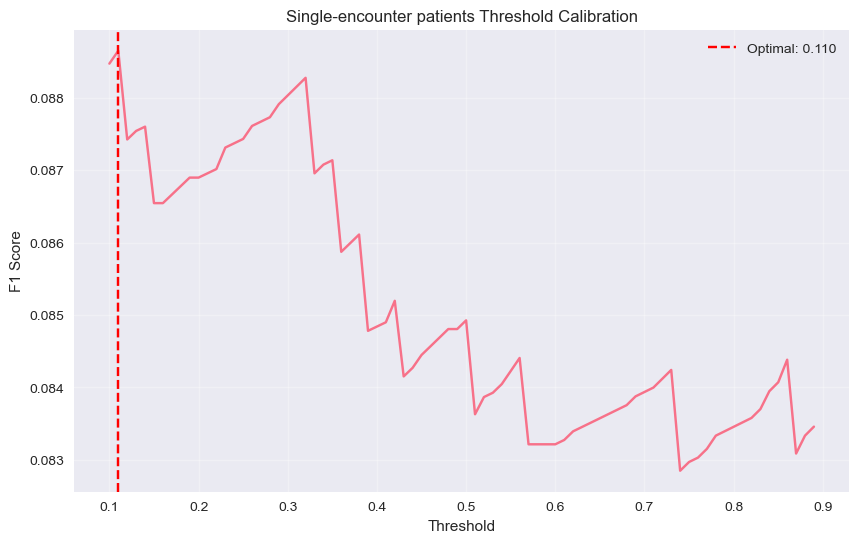

Optimal threshold for f1: 0.100
Best f1 score: 0.265
===Returning patients Optimal Threshold===
Default threshold: 0.5
Optimal threshold: 0.100
  Max F1 score: 0.265
  ROC-AUC score: 

Performance at optimal threshold:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      7512
           1       0.24      0.30      0.27      1750

    accuracy                           0.69      9262
   macro avg       0.53      0.54      0.53      9262
weighted avg       0.72      0.69      0.70      9262


Confusion Matrix:
[[5846 1666]
 [1228  522]]


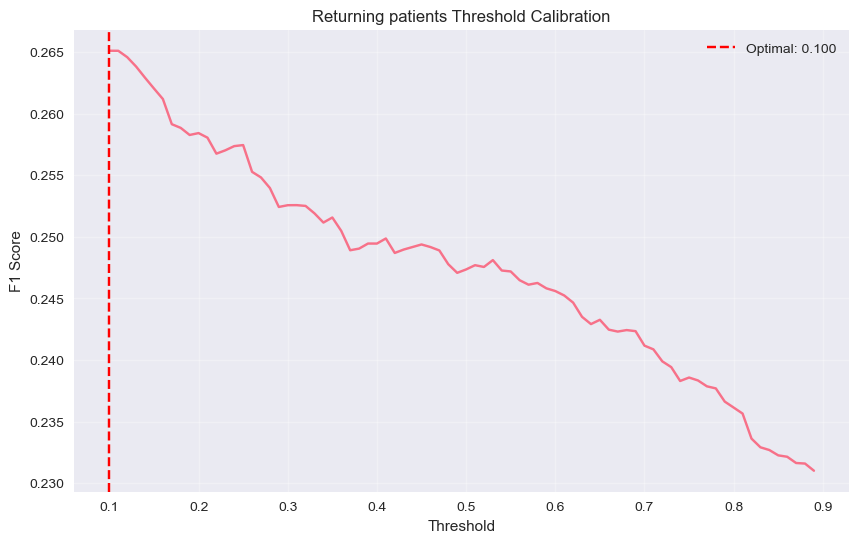

In [ ]:
# Threshold Calibration
for group, payload in group_results.items():
    best_model = payload['best_model_payload']['estimator']
    best_model_name = payload['best_model_name']
    X_test_final = payload['X_test_final']
    y_test = payload['y_test']
    display_optimal_thresholds(best_model, best_model_name, X_test_final, y_test, group)


# 2. patient-centric: all patients

In [ ]:
# Run the pipeline for this group
group_name = "Patient centric_All Patients"
pipeline_results = run_group_modeling_pipeline(
    df,
    group_name,
    target_col='readmitted_binary',
    test_size=0.2,
    random_state=42
)

group_results[group_name] = pipeline_results
group_summaries[group_name] = pipeline_results['summary']

print(f"\nAll DF pipeline completed successfully!")

# Print key results
best_model_name = pipeline_results['best_model_name']
best_estimator = pipeline_results['best_model_payload']['estimator']
best_f1 = pipeline_results['best_model_payload']['test']['f1']
print(f"   Best model: {best_model}")
print(f"   Best F1 score: {best_f1:.4f}")




======================================== PATIENT CENTRIC_ALL PATIENTS GROUP PIPELINE ========================================

Before any processing:
  Total rows: 101766
  Readmission rate: 0.112
  Readmission rate: 0.112
Creating patient history features (avoiding temporal leakage)...
Creating patient history features (avoiding temporal leakage)...
✓ Created 22 patient history features without data leakage
  - All features use only PRIOR encounters (via .shift(1))
  - First encounter for each patient has 0/NaN values (no prior history)
  - Uses readmitted_binary (30-day readmission) as target-aligned feature
  - Added 9 NEW advanced features for improved F1 score
  - Sample new features: has_diabetes_meds, healthcare_utilization_trend, high_risk_med_combo, high_risk_profile, historic_unique_diag_groups, is_returning_patient, log_num_procedures, log_prior_encounter_count, medication_count_change, polypharmacy_risk

=== Leakage Check ===
First encounters: 71500
Prior any readmission co

mutual_information
cat_target__diag_123_target_enc                               0.227186
cat_target__diag_123_group_num_lab_procedures_b...            0.071362
cat_target__diag_123_group_num_medications_bin_...            0.071348
cat_target__diag_123_group_clinical_complexity_...            0.071217
cat_target__diag_123_group_time_in_hospital_bin...            0.070720
cat_target__diag_123_group_number_diagnoses_bin...            0.056134
cat_target__diag_123_group_num_procedures_bin_t...            0.054662
cat_target__diag_123_group_total_healthcare_enc...            0.053883
cat_target__diag_123_group_prior_encounter_coun...            0.042198
cat_target__diag_123_group_prior_avg_num_lab_pr...            0.040152

PCA retained 54 components covering 95.28% variance and 74 original numeric features (>= 95% contribution).


pca_weighted_contribution
num_other__number_diagnoses                                  0.015284
num_skewed__current_vs_avg_hospitalization                   0.015278
num_skewed__medication_per_diagnosis                         0.015025
num_other__has_diabetes_meds                                 0.014890
num_other__high_risk_signature                               0.014691
num_skewed__current_vs_avg_procedures                        0.014656
num_other__primary_diabetes                                  0.014612
num_skewed__current_vs_avg_medications                       0.014531
num_other__insulin_changed                                   0.014519
num_other__risky_discharge_high_meds                         0.014504

Top 10 features by Random Forest importance:


rf_importance
cat_target__diag_123_target_enc                          0.368761
cat_target__diag_123_group_num_lab_procedures_b...       0.063814
cat_target__diag_123_group_time_in_hospital_bin...       0.054899
cat_target__diag_123_group_clinical_complexity_...       0.054478
cat_target__diag_123_group_num_medications_bin_...       0.053441
cat_target__diag_123_group_number_diagnoses_bin...       0.038064
cat_target__diag_123_group_num_procedures_bin_t...       0.030607
cat_target__diag_123_group_total_healthcare_enc...       0.029572
cat_target__diag_123_group_prior_encounter_coun...       0.019254
cat_target__diag_123_group_prior_avg_num_lab_pr...       0.015568

Feature selection summary:
  • Correlated features removed: 31
  • Features considered after decorrelation: 80
  • Selected features after voting (>=1 vote): 34
  • Final feature shapes (train/test): (81350, 34), (20354, 34)
Preparing CatBoost datasets with raw categorical features...
Raw ratio: 8.0:1
Adjusted ratio (factor=0.7): 5.6:1
Patient centric_All Patients Class imbalance ratio (neg:pos): 5.58:1
Building model registry...

Evaluating models for Patient centric_All Patients...
Detected class imbalance (minority ratio=0.111 < threshold=0.35). Evaluating baseline and SMOTE variants.
Raw ratio: 8.0:1
Adjusted ratio (factor=0.7): 5.6:1
Patient centric_All Patients Class imbalance ratio (neg:pos): 5.58:1
Building model registry...

Evaluating models for Patient centric_All Patients...
Detected class imbalance (minority ratio=0.111 < threshold=0.35). Evaluating baseline and SMOTE variants.
Numeric feature groups for preprocessing:
  • Total numeric columns: 73
  • Skew-corrected colum

Val Accuracy (CV)  Val Balanced Acc (CV)  \
model                                                                   
Random Forest                         0.675454               0.616881   
Naive Bayes (SMOTE)                   0.469329               0.546221   
LightGBM (SMOTE)                      0.681534               0.588514   
XGBoost (SMOTE)                       0.748633               0.571754   
Naive Bayes                           0.739684               0.563607   
LightGBM                              0.799937               0.587815   
Random Forest (SMOTE)                 0.802093               0.560364   
XGBoost                               0.840350               0.555160   
Logistic Regression                   0.633446               0.597868   
Logistic Regression (SMOTE)           0.633805               0.598045   
CatBoost                              0.820044               0.590130   

                             Val Precision (CV)  Val Recall (CV)  Val F1 (CV)  \
model                                                                           
Random Forest                          0.180939         0.541593     0.271176   
Naive Bayes (SMOTE)                    0.127938         0.645184     0.213464   
LightGBM (SMOTE)                       0.167804         0.468819     0.247132   
XGBoost (SMOTE)                        0.177360         0.344123     0.233975   
Naive Bayes                            0.167670         0.337023     0.223912   
LightGBM                               0.220942         0.314838     0.259619   
Random Forest (SMOTE)                  0.195905         0.249302     0.219215   
XGBoost                                0.232615         0.188159     0.207978   
Logistic Regression                    0.162698         0.552128     0.251325   
Logistic Regression (SMOTE)            0.162849         0.552062     0.251504   
CatBoost                               0.244335         0.294257     0.266905   

                             Val ROC-AUC (CV)  Val Avg Precision (CV)  \
model                                                                   
Random Forest                        0.660896                0.204550   
Naive Bayes (SMOTE)                  0.575032                0.143484   
LightGBM (SMOTE)                     0.631706                0.185120   
XGBoost (SMOTE)                      0.615946                0.173959   
Naive Bayes                          0.619270                0.154146   
LightGBM                             0.664497                0.210282   
Random Forest (SMOTE)                0.602117                0.168564   
XGBoost                              0.644255                0.192898   
Logistic Regression                  0.636658                0.172201   
Logistic Regression (SMOTE)          0.634754                0.171042   
CatBoost                             0.678899                0.228262   

                             Test Accuracy  Test Balanced Acc  \
model                                                           
Random Forest                     0.693525           0.538855   
Naive Bayes (SMOTE)               0.762848           0.540820   
LightGBM (SMOTE)                  0.731158           0.531429   
XGBoost (SMOTE)                   0.755085           0.529921   
Naive Bayes                       0.783433           0.531861   
LightGBM                          0.788788           0.532188   
Random Forest (SMOTE)             0.784121           0.530712   
XGBoost                           0.806623           0.529938   
Logistic Regression               0.813845           0.526131   
Logistic Regression (SMOTE)       0.817677           0.523487   
CatBoost                          0.860371           0.522175   

                             Test Specificity  ...  Test Recall   Test F1  \
model                                          ...                          
Random Forest                        0.738079  ...     0.339631  0.198613  


All DF pipeline completed successfully!
   Best model: GaussianNB()
   Best F1 score: 0.1767


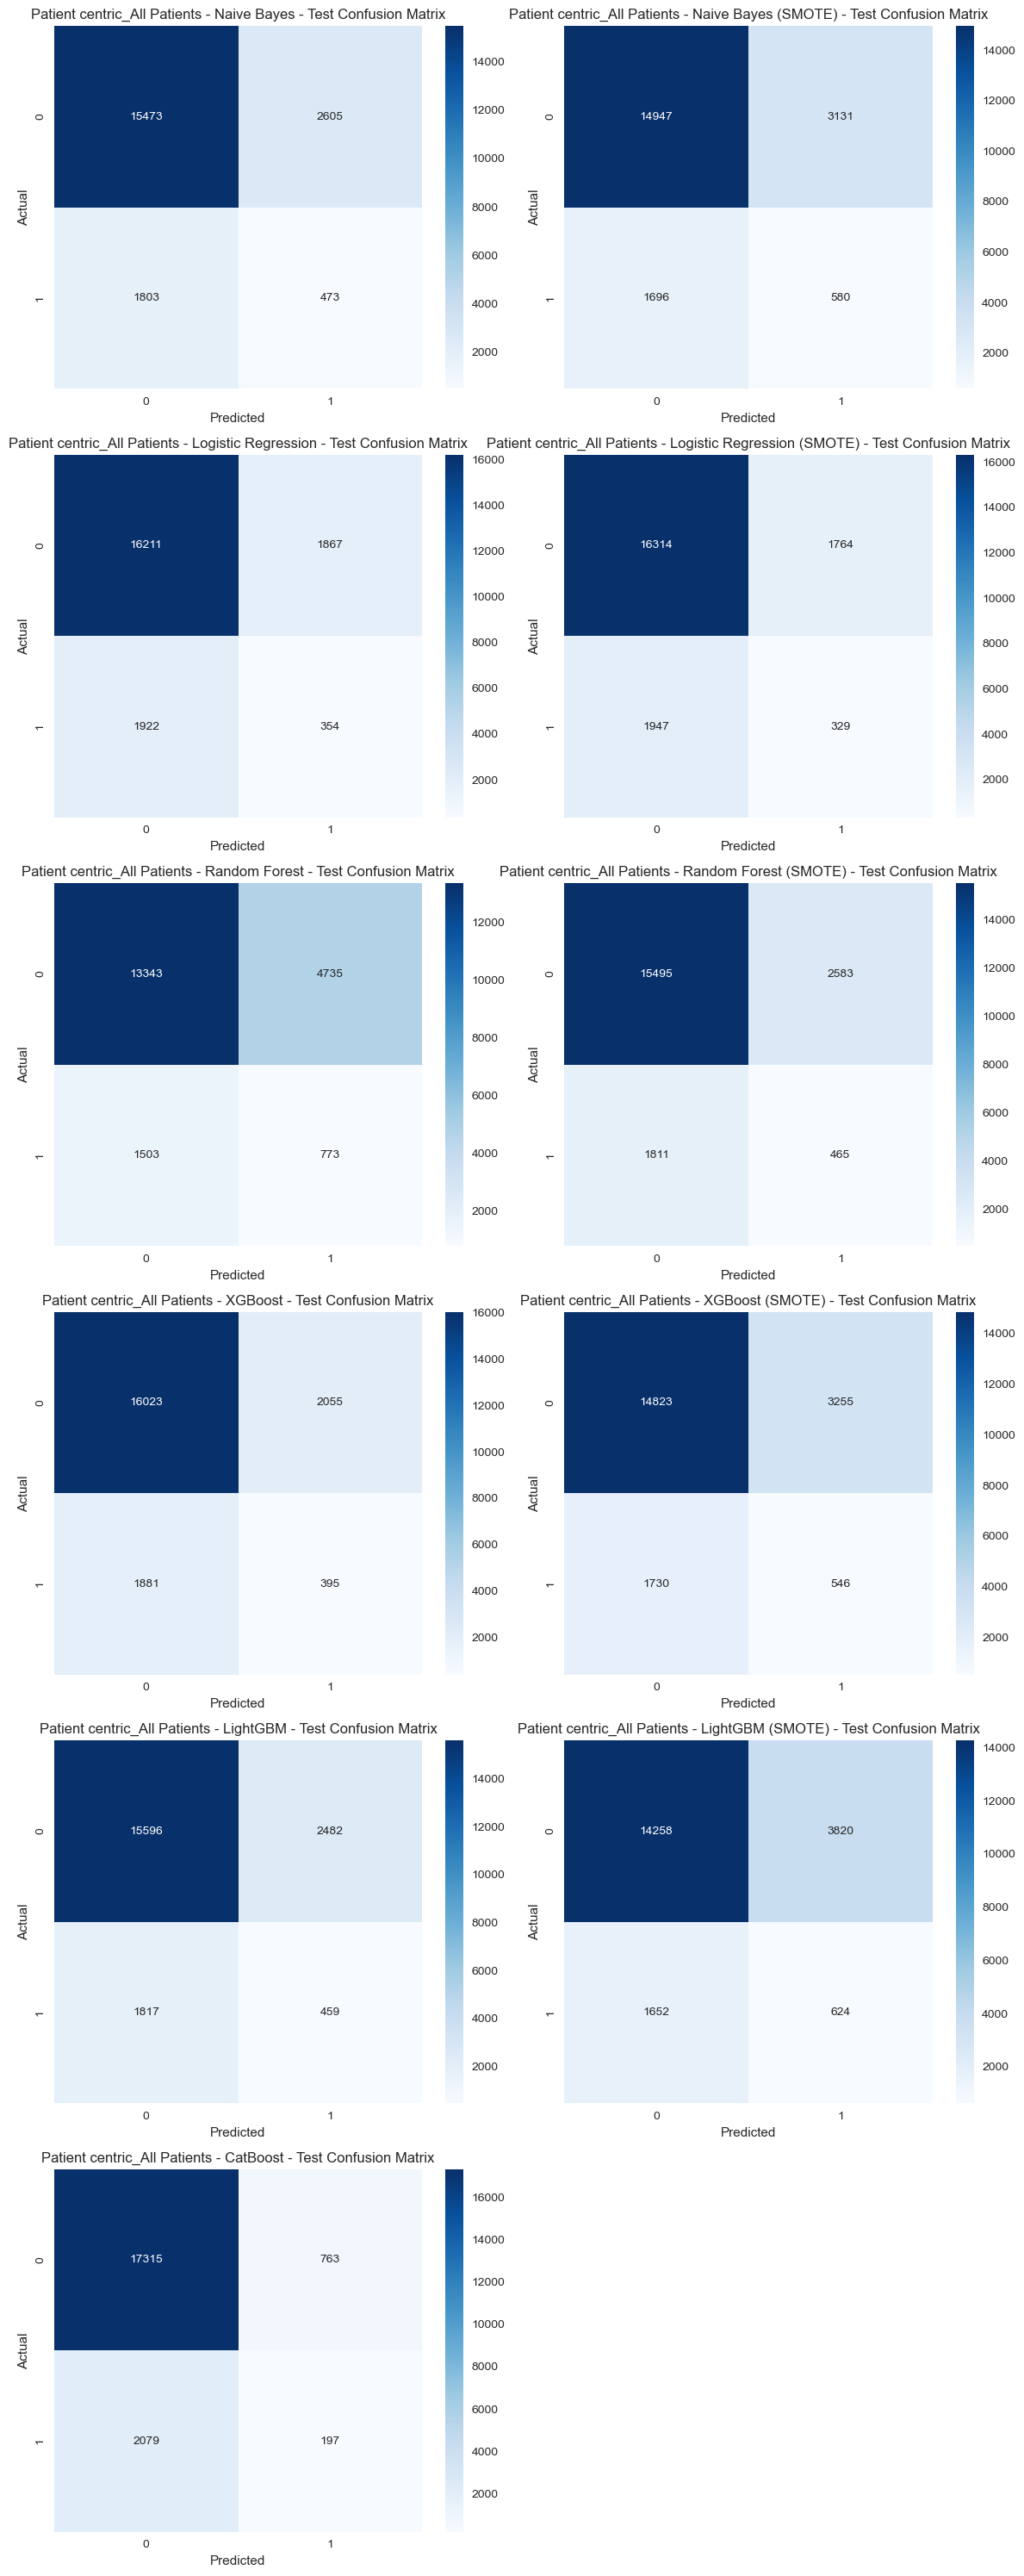

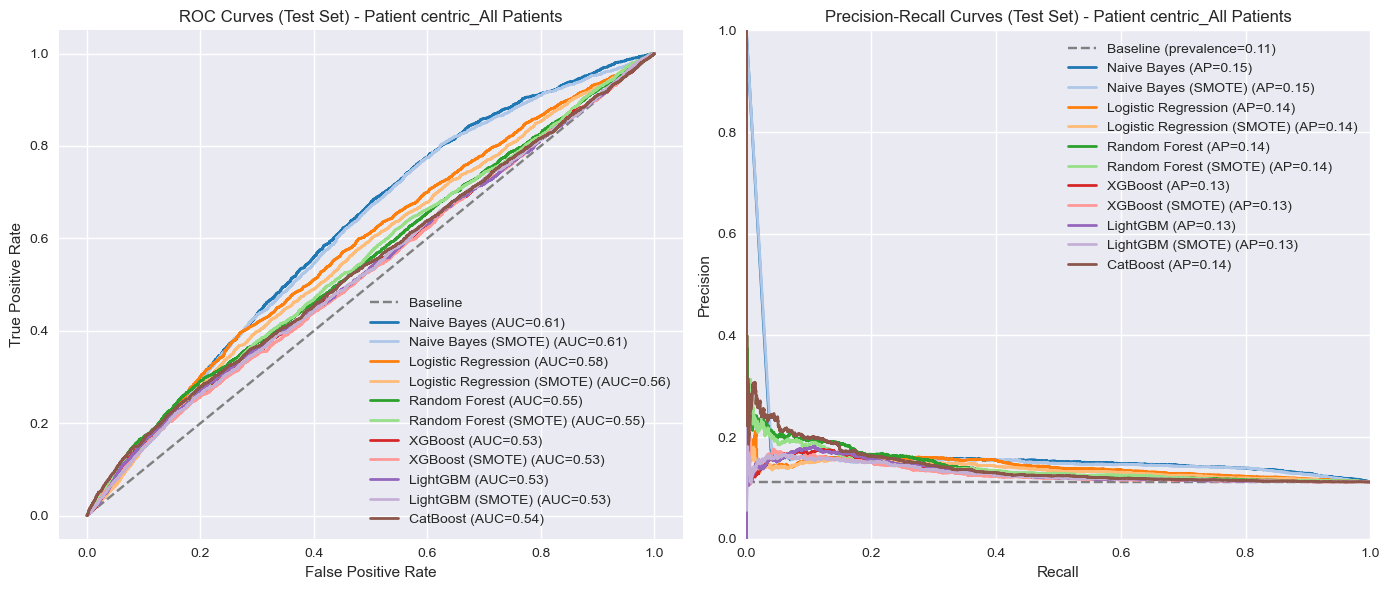

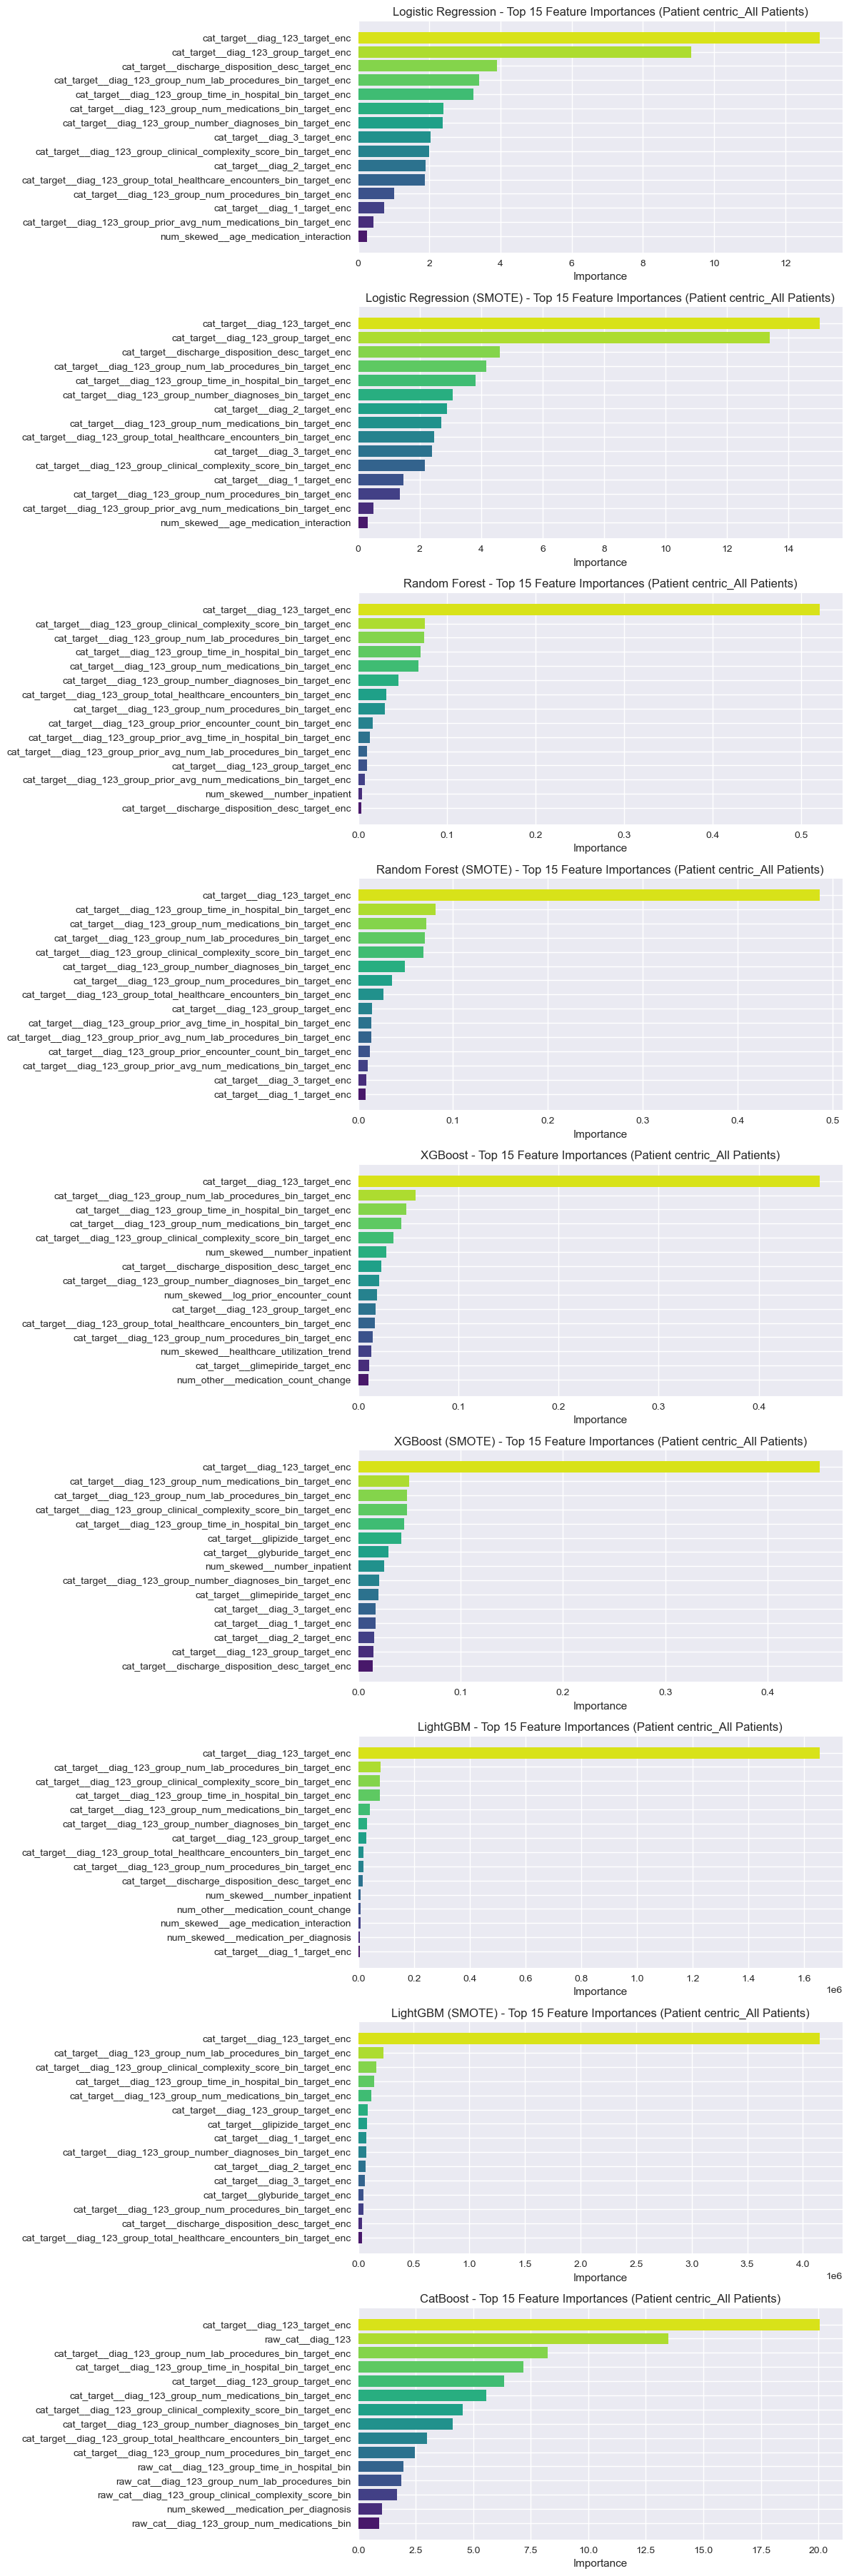

Detected model type: GaussianNB
Using general SHAP Explainer
SHAP.Explainer failed (The passed model is not callable and cannot be analyzed directly with the given masker! Model: GaussianNB()); falling back to TreeExplainer...
All SHAP methods failed: Model type not yet supported by TreeExplainer: <class 'sklearn.naive_bayes.GaussianNB'>
   Model type: GaussianNB
   X_test shape: (20354, 34)
   X_train shape: (81350, 34)


In [ ]:
results = pipeline_results["results"]
y_test = pipeline_results["y_test"]
X_train_final = pipeline_results["X_train_final"]
X_test_final = pipeline_results["X_test_final"]
selected_features = pipeline_results["selected_features"]
best_model_name = pipeline_results["best_model_name"]
best_model_payload = pipeline_results["best_model_payload"]
shap_results = run_display_summary(results, group_name, y_test, X_train_final, X_test_final, selected_features, best_model_name, best_model_payload)

In [ ]:
if 'error' not in shap_results['shap']:
    shap_type = shap_results['shap'].get('explainer_type', 'Unknown')
    print(f"   SHAP analysis: Success ({shap_type})")
else:
    print(f"   SHAP analysis: {shap_results['shap']['error']}")

   SHAP analysis: All SHAP methods failed: Model type not yet supported by TreeExplainer: <class 'sklearn.naive_bayes.GaussianNB'>


In [ ]:
# Performance analysis breakdown by selected features
best_model_name = pipeline_results['best_model_name']
best_estimator = pipeline_results['best_model_payload']['estimator']
X_test_final = pipeline_results['X_test_final']
y_test = pipeline_results['y_test']
test_metadata = df.loc[X_test_final.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]
print(f'===Patient Centric All Patients CONFUSION MATRIX ANALYSIS BY FEATURE===')
for feature in test_metadata.columns:
    print(f"\nConfusion breakdown by {feature}:")
    display(confusion_breakdown(best_estimator, X_test_final, y_test, test_metadata, feature))


===Patient Centric All Patients CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support     TN    FP    FN   TP  f1_score  precision  \
3        Caucasian    14852  11256  1932  1312  352  0.178318   0.154116   
1  AfricanAmerican     4371   3343   536   400   92  0.164286   0.146497   
4         Hispanic      441    353    52    26   10  0.204082   0.161290   
0                ?      326    238    48    27   13  0.257426   0.213115   
5            Other      289    230    29    27    3  0.096774   0.093750   
2            Asian       75     53     8    11    3  0.240000   0.272727   

     recall  specificity   roc_auc  
3  0.211538     0.853503  0.532521  
1  0.186992     0.861820  0.524406  
4  0.277778     0.871605  0.574691  
0  0.325000     0.832168  0.578584  
5  0.100000     0.888031  0.494015  
2  0.214286     0.868852  0.541569


Confusion breakdown by age:


age  support    TN   FP   FN   TP  f1_score  precision    recall  \
7   [70-80)     5383  4087  689  492  115  0.163005   0.143035  0.189456   
6   [60-70)     4400  3332  577  404   87  0.150649   0.131024  0.177189   
5   [50-60)     3675  2805  449  334   87  0.181818   0.162313  0.206651   
8   [80-90)     2610  1984  342  225   59  0.172263   0.147132  0.207746   
4   [40-50)     2221  1701  288  180   52  0.181818   0.152941  0.224138   
3   [30-40)      933   701  133   70   29  0.222222   0.179012  0.292929   
9  [90-100)      366   272   43   31   20  0.350877   0.317460  0.392157   
2   [20-30)      332   250   40   33    9  0.197802   0.183673  0.214286   
1   [10-20)      324   255   30   27   12  0.296296   0.285714  0.307692   
0    [0-10)      110    86   14    7    3  0.222222   0.176471  0.300000   

   specificity   roc_auc  
7     0.855737  0.522597  
6     0.852392  0.514791  
5     0.862016  0.534333  
8     0.852966  0.530356  
4     0.855204  0.539671  
3     0.840528  0.566728  
9     0.863492  0.627824  
2     0.862069  0.538177  
1     0.894737  0.601215  
0     0.860000  0.580000


Confusion breakdown by diag_1_group:


diag_1_group  support    TN   FP  \
0                                         Circulatory     7091  5430  877   
10                                        Respiratory     2548  1913  346   
1                                            Diabetes     1930  1476  247   
2                                           Digestive     1731  1302  212   
6                                              Injury     1283   974  168   
7                                     Musculoskeletal      916   677  120   
4                                       Genitourinary      761   588   88   
8                                           Neoplasms      714   538  103   
17        symptoms, signs, and ill-defined conditions      596   457   76   
16                                   mental disorders      528   389   76   
3   Endocrine, nutritional and metabolic diseases,...      484   378   62   
15       diseases of the skin and subcutaneous tissue      448   346   59   
9                                               Other      391   292   52   
5                   Infectious and parasitic diseases      372   279   40   
14    diseases of the nervous system and sense organs      216   156   41   
13     diseases of the blood and blood-forming organs      171   132   24   
11  complications of pregnancy, childbirth, and th...      166   141   12   
12                               congenital anomalies        8     5    2   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   632  152  0.167678   0.147716  0.193878     0.860948  0.527413  
10  228   61  0.175287   0.149877  0.211073     0.846835  0.528954  
1   155   52  0.205534   0.173913  0.251208     0.856645  0.553927  
2   168   49  0.205021   0.187739  0.225806     0.859974  0.542890  
6   112   29  0.171598   0.147208  0.205674     0.852890  0.529282  
7   102   17  0.132812   0.124088  0.142857     0.849435  0.496146  
4    60   25  0.252525   0.221239  0.294118     0.869822  0.581970  
8    61   12  0.127660   0.104348  0.164384     0.839314  0.501849  
17   48   15  0.194805   0.164835  0.238095     0.857411  0.547753  
16   47   16  0.206452   0.173913  0.253968     0.836559  0.545264  
3    38    6  0.107143   0.088235  0.136364     0.859091  0.497727  
15   33   10  0.178571   0.144928  0.232558     0.854321  0.543440  
9    39    8  0.149533   0.133333  0.170213     0.848837  0.509525  
5    38   15  0.277778   0.272727  0.283019     0.874608  0.578814  
14   19    0  0.000000   0.000000  0.000000     0.791878  0.395939  
13   12    3  0.142857   0.111111  0.200000     0.846154  0.523077  
11   10    3  0.214286   0.200000  0.230769     0.921569  0.576169  
12    1    0  0.000000   0.000000  0.000000     0.714286  0.357143


Confusion breakdown by diag_2_group:


diag_2_group  support    TN   FP  \
0                                         Circulatory     6824  5183  883   
1                                            Diabetes     3608  2744  459   
10                                        Respiratory     1919  1490  219   
3   Endocrine, nutritional and metabolic diseases,...     1459  1129  182   
4                                       Genitourinary     1207   897  153   
2                                           Digestive      775   566  112   
15       diseases of the skin and subcutaneous tissue      642   488   85   
9                                               Other      588   457   68   
16                                   mental disorders      502   390   61   
17        symptoms, signs, and ill-defined conditions      484   370   56   
8                                           Neoplasms      474   348   82   
13     diseases of the blood and blood-forming organs      474   350   66   
6                                              Injury      460   351   57   
5                   Infectious and parasitic diseases      356   269   49   
7                                     Musculoskeletal      283   209   39   
14    diseases of the nervous system and sense organs      190   141   25   
11  complications of pregnancy, childbirth, and th...       93    76    8   
12                               congenital anomalies       16    15    1   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   602  156  0.173623   0.150144  0.205805     0.854435  0.530120  
1   321   84  0.177215   0.154696  0.207407     0.856697  0.532052  
10  171   39  0.166667   0.151163  0.185714     0.871855  0.528785  
3   108   40  0.216216   0.180180  0.270270     0.861175  0.565722  
4   129   28  0.165680   0.154696  0.178344     0.854286  0.516315  
2    68   29  0.243697   0.205674  0.298969     0.834808  0.566889  
15   53   16  0.188235   0.158416  0.231884     0.851658  0.541771  
9    52   11  0.154930   0.139241  0.174603     0.870476  0.522540  
16   39   12  0.193548   0.164384  0.235294     0.864745  0.550020  
17   47   11  0.176000   0.164179  0.189655     0.868545  0.529100  
8    38    6  0.090909   0.068182  0.136364     0.809302  0.472833  
13   49    9  0.135338   0.120000  0.155172     0.841346  0.498259  
6    40   12  0.198347   0.173913  0.230769     0.860294  0.545532  
5    32    6  0.129032   0.109091  0.157895     0.845912  0.501903  
7    28    7  0.172840   0.152174  0.200000     0.842742  0.521371  
14   18    6  0.218182   0.193548  0.250000     0.849398  0.549699  
11    8    1  0.111111   0.111111  0.111111     0.904762  0.507937  
12    0    0  0.000000   0.000000       NaN     0.937500       NaN


Confusion breakdown by diag_3_group:


diag_3_group  support    TN   FP  \
0                                         Circulatory     6156  4679  793   
1                                            Diabetes     4132  3165  525   
3   Endocrine, nutritional and metabolic diseases,...     1588  1192  212   
9                                               Other     1481  1147  169   
10                                        Respiratory     1382  1063  166   
4                                       Genitourinary     1043   793  152   
2                                           Digestive      778   568  110   
16                                   mental disorders      637   475   86   
17        symptoms, signs, and ill-defined conditions      471   357   57   
15       diseases of the skin and subcutaneous tissue      436   326   65   
13     diseases of the blood and blood-forming organs      417   305   51   
5                   Infectious and parasitic diseases      374   283   54   
14    diseases of the nervous system and sense organs      373   281   49   
7                                     Musculoskeletal      352   269   38   
6                                              Injury      341   260   35   
8                                           Neoplasms      293   226   36   
11  complications of pregnancy, childbirth, and th...       82    72    5   
12                               congenital anomalies       18    12    2   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   535  149  0.183272   0.158174  0.217836     0.855080  0.536458  
1   361   81  0.154580   0.133663  0.183258     0.857724  0.520491  
3   146   38  0.175115   0.152000  0.206522     0.849003  0.527762  
9   142   23  0.128852   0.119792  0.139394     0.871581  0.505487  
10  124   29  0.166667   0.148718  0.189542     0.864931  0.527237  
4    74   24  0.175182   0.136364  0.244898     0.839153  0.542026  
2    76   24  0.205128   0.179104  0.240000     0.837758  0.538879  
16   58   18  0.200000   0.173077  0.236842     0.846702  0.541772  
17   47   10  0.161290   0.149254  0.175439     0.862319  0.518879  
15   33   12  0.196721   0.155844  0.266667     0.833760  0.550213  
13   49   12  0.193548   0.190476  0.196721     0.856742  0.526731  
5    27   10  0.198020   0.156250  0.270270     0.839763  0.555016  
14   32   11  0.213592   0.183333  0.255814     0.851515  0.553665  
7    38    7  0.155556   0.155556  0.155556     0.876221  0.515889  
6    32   14  0.294737   0.285714  0.304348     0.881356  0.592852  
8    23    8  0.213333   0.181818  0.258065     0.862595  0.560330  
11    3    2  0.333333   0.285714  0.400000     0.935065  0.667532  
12    3    1  0.285714   0.333333  0.250000     0.857143  0.553571

Optimal threshold for f1: 0.100
Best f1 score: 0.195
===Patient centric_All Patients Optimal Threshold===
Default threshold: 0.5
Optimal threshold: 0.100
  Max F1 score: 0.195
  ROC-AUC score: 

Performance at optimal threshold:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     18078
           1       0.16      0.25      0.19      2276

    accuracy                           0.77     20354
   macro avg       0.53      0.54      0.53     20354
weighted avg       0.82      0.77      0.79     20354


Confusion Matrix:
[[15050  3028]
 [ 1704   572]]


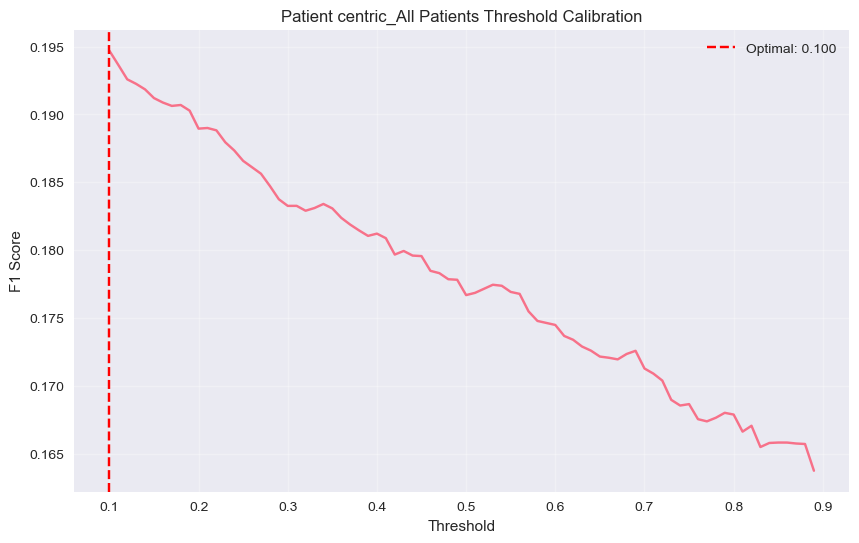

In [ ]:
# Threshold Calibration
display_optimal_thresholds(best_estimator, best_model_name, X_test_final, y_test, group_name)

# 3. Encounter-centric: all patients

In [27]:
# Run the pipeline for this group

group_name_e = "Encounter centric_All Patients"
pipeline_results_e = run_group_modeling_pipeline(
    df,
    group_name_e,
    target_col='readmitted_binary',
    test_size=0.2,
    random_state=42,
    patient_level=False
)

# group_results[group_name_e] = pipeline_results_e
# group_summaries[group_name_e] = pipeline_results_e['summary']

print(f"\nEncounter level All patients pipeline completed successfully!")

# Print key results
best_model_e = pipeline_results_e['best_model_name']
best_f1_e = pipeline_results_e['best_model_payload']['test']['f1']
print(f"   Best model: {best_model_e}")
print(f"   Best F1 score: {best_f1_e:.4f}")


======================================== ENCOUNTER CENTRIC_ALL PATIENTS GROUP PIPELINE ========================================

Before any processing:
  Total rows: 101766
  Readmission rate: 0.112
CREATING ADVANCED FEATURES

1️⃣  Creating domain-specific medical features...
   ✓ Created utilisation, intensity, and ratio features

2️⃣  Creating patient history interaction features...
   • Skipped (requires patient history features)

3️⃣  Creating diabetes medication combination features...
   ✓ Created diabetes medication interaction features

4️⃣  Creating age-related cross features...
   ✓ Created age cross features

5️⃣  Creating admission-discharge pattern features...
   ✓ Created admission/discharge risk indicators

6️⃣  Creating medication and lab heuristics...
   ✓ Created medication/lab heuristic features

7️⃣  Creating quantile-based binned features (n_bins=6)...
   ✓ Created 7 quantile-binned features

8️⃣  Creating diagnosis pattern features...
   ✓ Created diagnosis patter

mutual_information
cat_target__diag_123_target_enc                               0.229604
cat_target__diag_123_group_clinical_complexity_...            0.072520
cat_target__diag_123_group_num_lab_procedures_b...            0.072145
cat_target__diag_123_group_time_in_hospital_bin...            0.072124
cat_target__diag_123_group_num_medications_bin_...            0.071842
cat_target__diag_123_group_number_diagnoses_bin...            0.056988
cat_target__diag_123_group_num_procedures_bin_t...            0.055085
cat_target__diag_123_group_total_healthcare_enc...            0.052996
cat_target__diag_123_group_target_enc                         0.022149
num_skewed__number_inpatient                                  0.013146

PCA retained 47 components covering 95.29% variance and 61 original numeric features (>= 95% contribution).


pca_weighted_contribution
num_skewed__medication_per_diagnosis                   0.018637
num_other__has_diabetes_meds                           0.018097
num_other__insulin_changed                             0.017867
num_other__number_diagnoses                            0.017580
num_skewed__lab_intensity                              0.017559
cat_target__diag_3_group_target_enc                    0.017290
num_other__primary_diabetes                            0.017248
cat_target__diag_3_target_enc                          0.017152
num_other__diabetes_med_change_count                   0.017089
num_other__num_lab_procedures                          0.016982

Top 10 features by Random Forest importance:


rf_importance
cat_target__diag_123_target_enc                          0.413226
cat_target__diag_123_group_num_lab_procedures_b...       0.064421
cat_target__diag_123_group_time_in_hospital_bin...       0.063894
cat_target__diag_123_group_num_medications_bin_...       0.059789
cat_target__diag_123_group_clinical_complexity_...       0.056290
cat_target__diag_123_group_number_diagnoses_bin...       0.038582
cat_target__diag_123_group_total_healthcare_enc...       0.034839
cat_target__diag_123_group_num_procedures_bin_t...       0.031014
cat_target__diag_123_group_target_enc                    0.015487
num_skewed__lab_intensity                                0.011310

Feature selection summary:
  • Correlated features removed: 29
  • Features considered after decorrelation: 66
  • Selected features after voting (>=1 vote): 42
  • Final feature shapes (train/test): (81412, 42), (20354, 42)
Preparing CatBoost datasets with raw categorical features...
Raw ratio: 8.0:1
Adjusted ratio (factor=0.7): 5.6:1
Encounter centric_All Patients Class imbalance ratio (neg:pos): 5.57:1
Building model registry...

Evaluating models for Encounter centric_All Patients...
Detected class imbalance (minority ratio=0.112 < threshold=0.35). Evaluating baseline and SMOTE variants.
Numeric feature groups for preprocessing:
  • Total numeric columns: 61
  • Skew-corrected columns (> 1.0 skew & non-binary): 25
  • Remaining numeric columns: 36
Encoded feature counts:
  • Train: (65129, 95)
  • Test: (16283, 95)
Numeric feature groups for preprocessing:
  • Total numeric columns: 61
  • Skew-corrected columns (> 1.0 skew & non-binary): 25
  • Remaining numeric columns: 36
Encode

Val Accuracy (CV)  Val Balanced Acc (CV)  \
model                                                                   
Random Forest                         0.687908               0.613167   
Naive Bayes (SMOTE)                   0.415270               0.537865   
LightGBM (SMOTE)                      0.755699               0.603156   
XGBoost (SMOTE)                       0.795337               0.581919   
Naive Bayes                           0.792586               0.550153   
LightGBM                              0.802302               0.595221   
Random Forest (SMOTE)                 0.844495               0.541404   
XGBoost                               0.833587               0.566734   
Logistic Regression                   0.623360               0.593727   
Logistic Regression (SMOTE)           0.626185               0.593777   
CatBoost                              0.814266               0.596951   

                             Val Precision (CV)  Val Recall (CV)  Val F1 (CV)  \
model                                                                           
Random Forest                          0.182689         0.516948     0.269937   
Naive Bayes (SMOTE)                    0.123619         0.695686     0.209900   
LightGBM (SMOTE)                       0.203220         0.406780     0.270969   
XGBoost (SMOTE)                        0.212191         0.307176     0.250949   
Naive Bayes                            0.178443         0.238057     0.203523   
LightGBM                               0.230193         0.328636     0.270695   
Random Forest (SMOTE)                  0.218040         0.151221     0.178324   
XGBoost                                0.238109         0.223201     0.230303   
Logistic Regression                    0.159389         0.555579     0.247708   
Logistic Regression (SMOTE)            0.159845         0.552057     0.247908   
CatBoost                               0.244381         0.317192     0.275968   

                             Val ROC-AUC (CV)  Val Avg Precision (CV)  \
model                                                                   
Random Forest                        0.661626                0.208696   
Naive Bayes (SMOTE)                  0.564562                0.143901   
LightGBM (SMOTE)                     0.657504                0.208763   
XGBoost (SMOTE)                      0.645605                0.200536   
Naive Bayes                          0.608718                0.152641   
LightGBM                             0.665582                0.216553   
Random Forest (SMOTE)                0.608608                0.167318   
XGBoost                              0.654141                0.201073   
Logistic Regression                  0.632833                0.168466   
Logistic Regression (SMOTE)          0.630920                0.166472   
CatBoost                             0.675851                0.228510   

                             Test Accuracy  Test Balanced Acc  \
model                                                           
Random Forest                     0.686695           0.543947   
Naive Bayes (SMOTE)               0.761668           0.539745   
LightGBM (SMOTE)                  0.743588           0.536500   
XGBoost (SMOTE)                   0.769628           0.533443   
Naive Bayes                       0.788248           0.535067   
LightGBM                          0.780584           0.531908   
Random Forest (SMOTE)             0.802840           0.533075   
XGBoost                           0.796453           0.531791   
Logistic Regression               0.811880           0.521799   
Logistic Regression (SMOTE)       0.817382           0.519505   
CatBoost                          0.863024           0.519588   

                             Test Specificity  ...  Test Recall   Test F1  \
model                                          ...                          
Random Forest                        0.727700  ...     0.360194  0.204168  


Encounter level All patients pipeline completed successfully!
   Best model: Naive Bayes
   Best F1 score: 0.1806


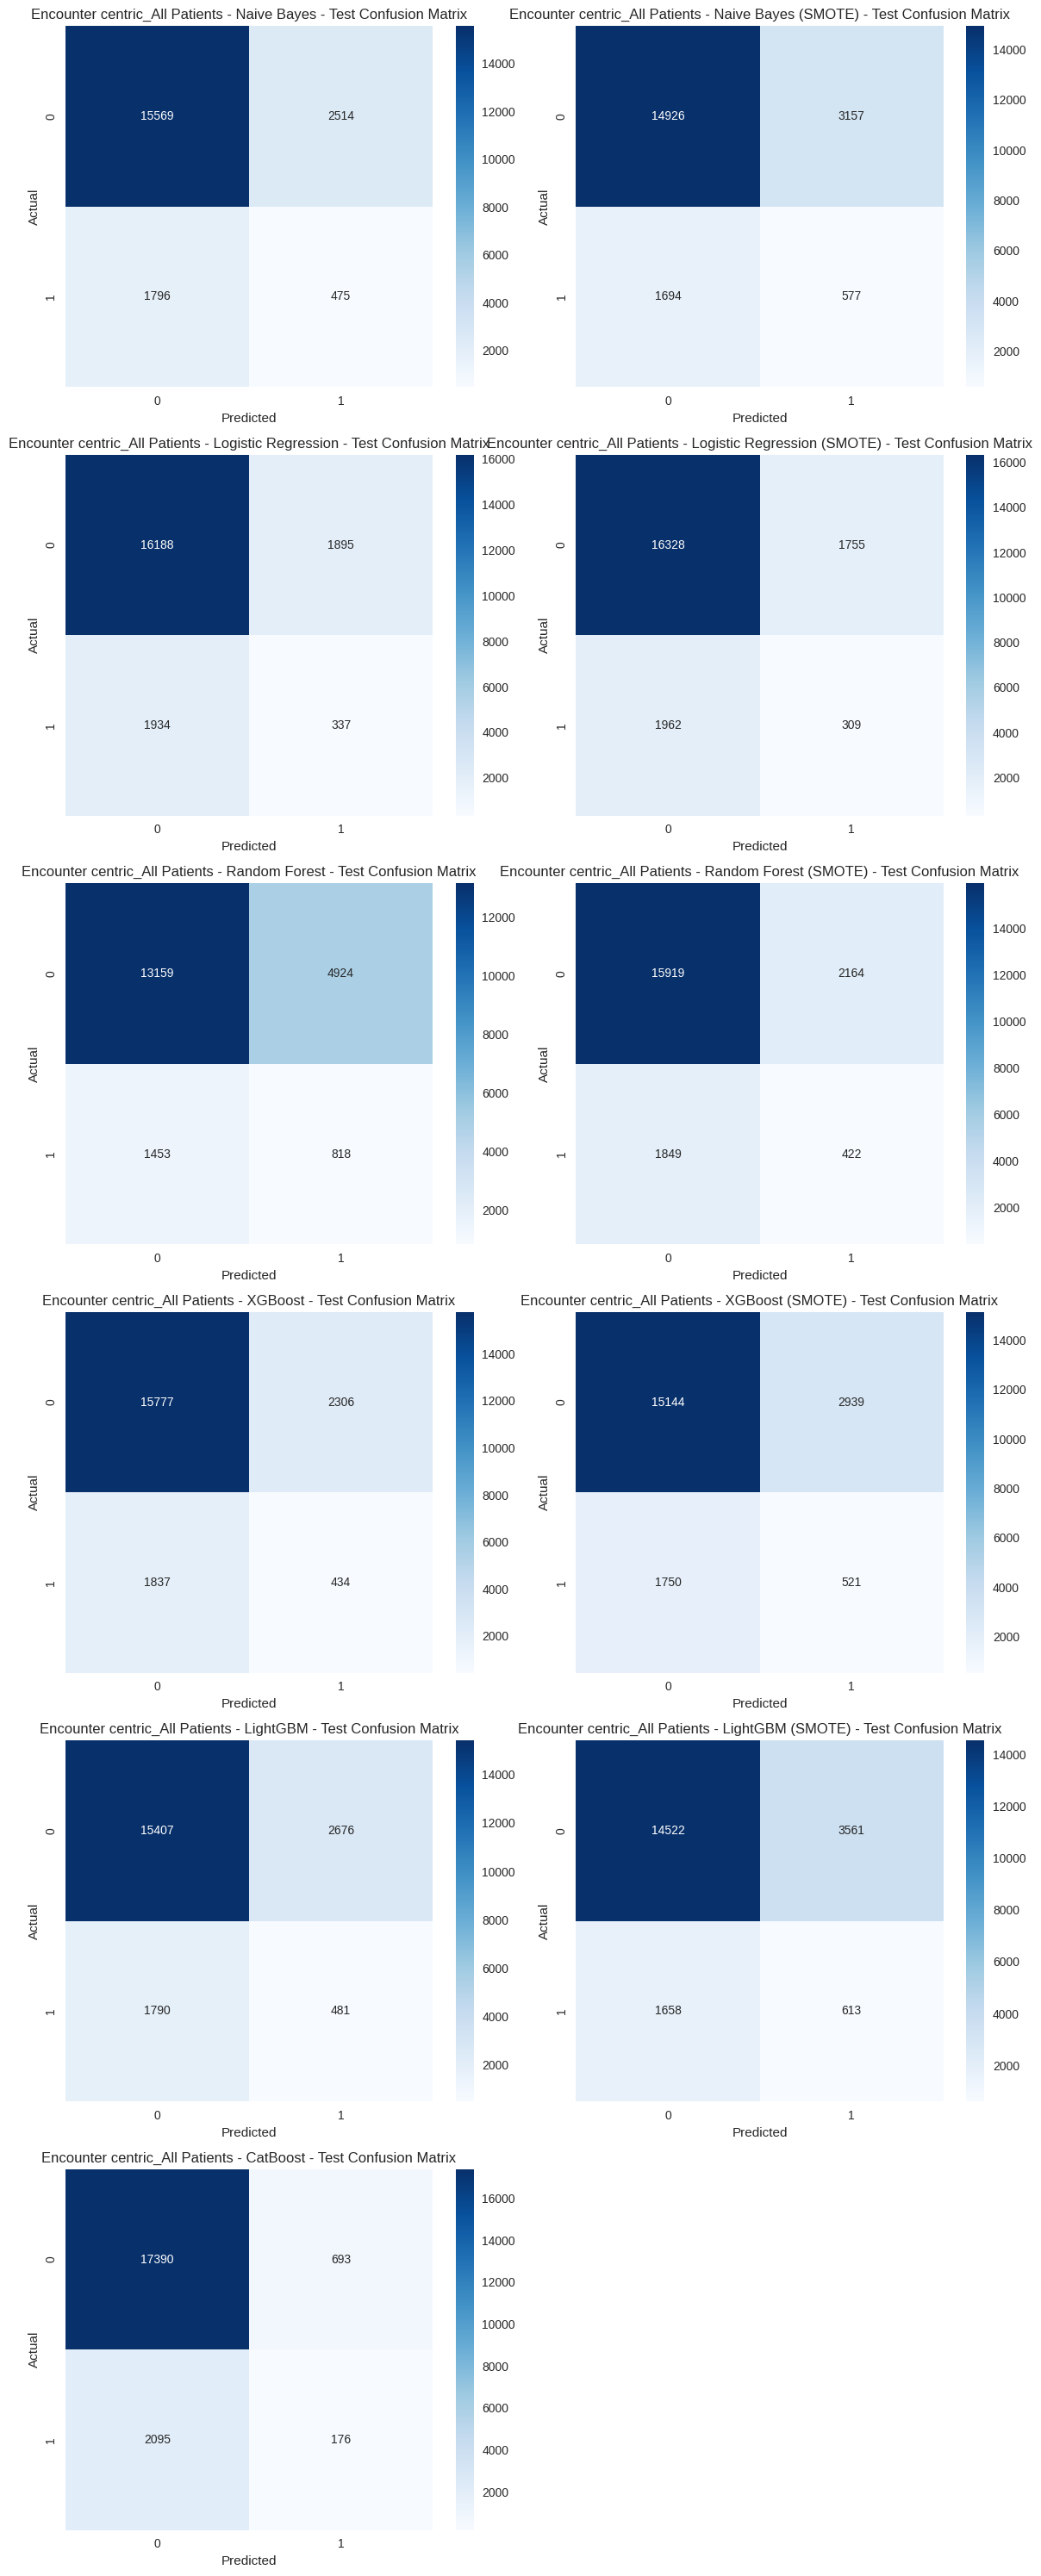

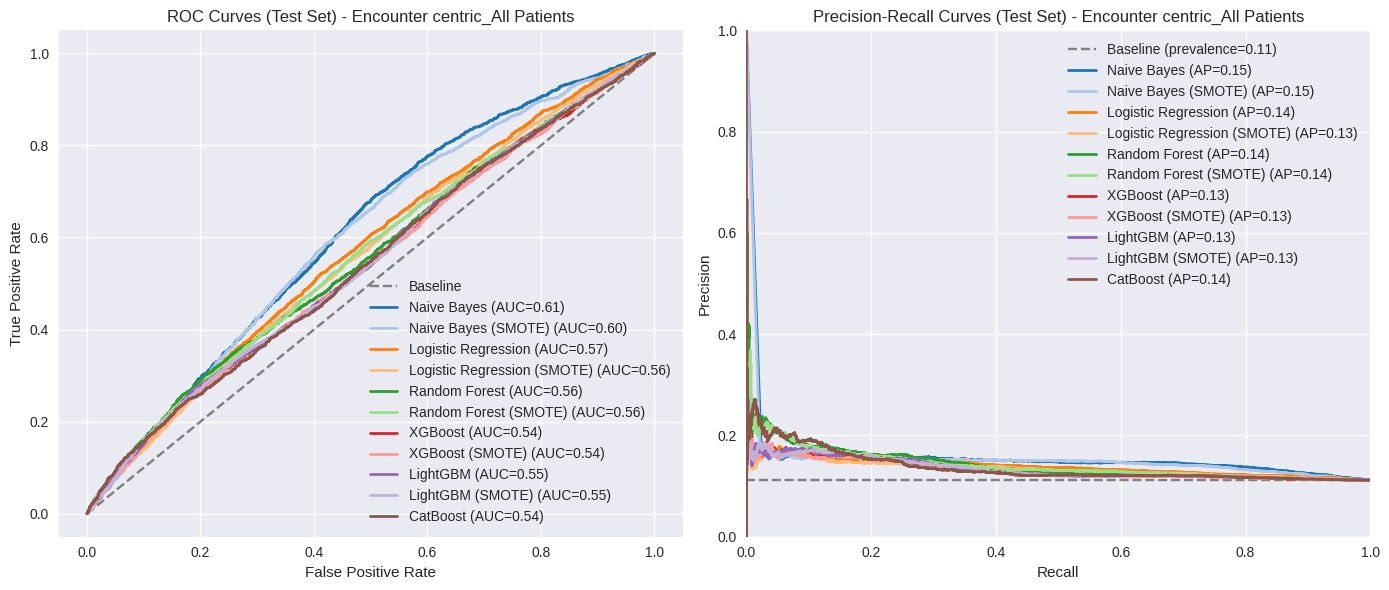

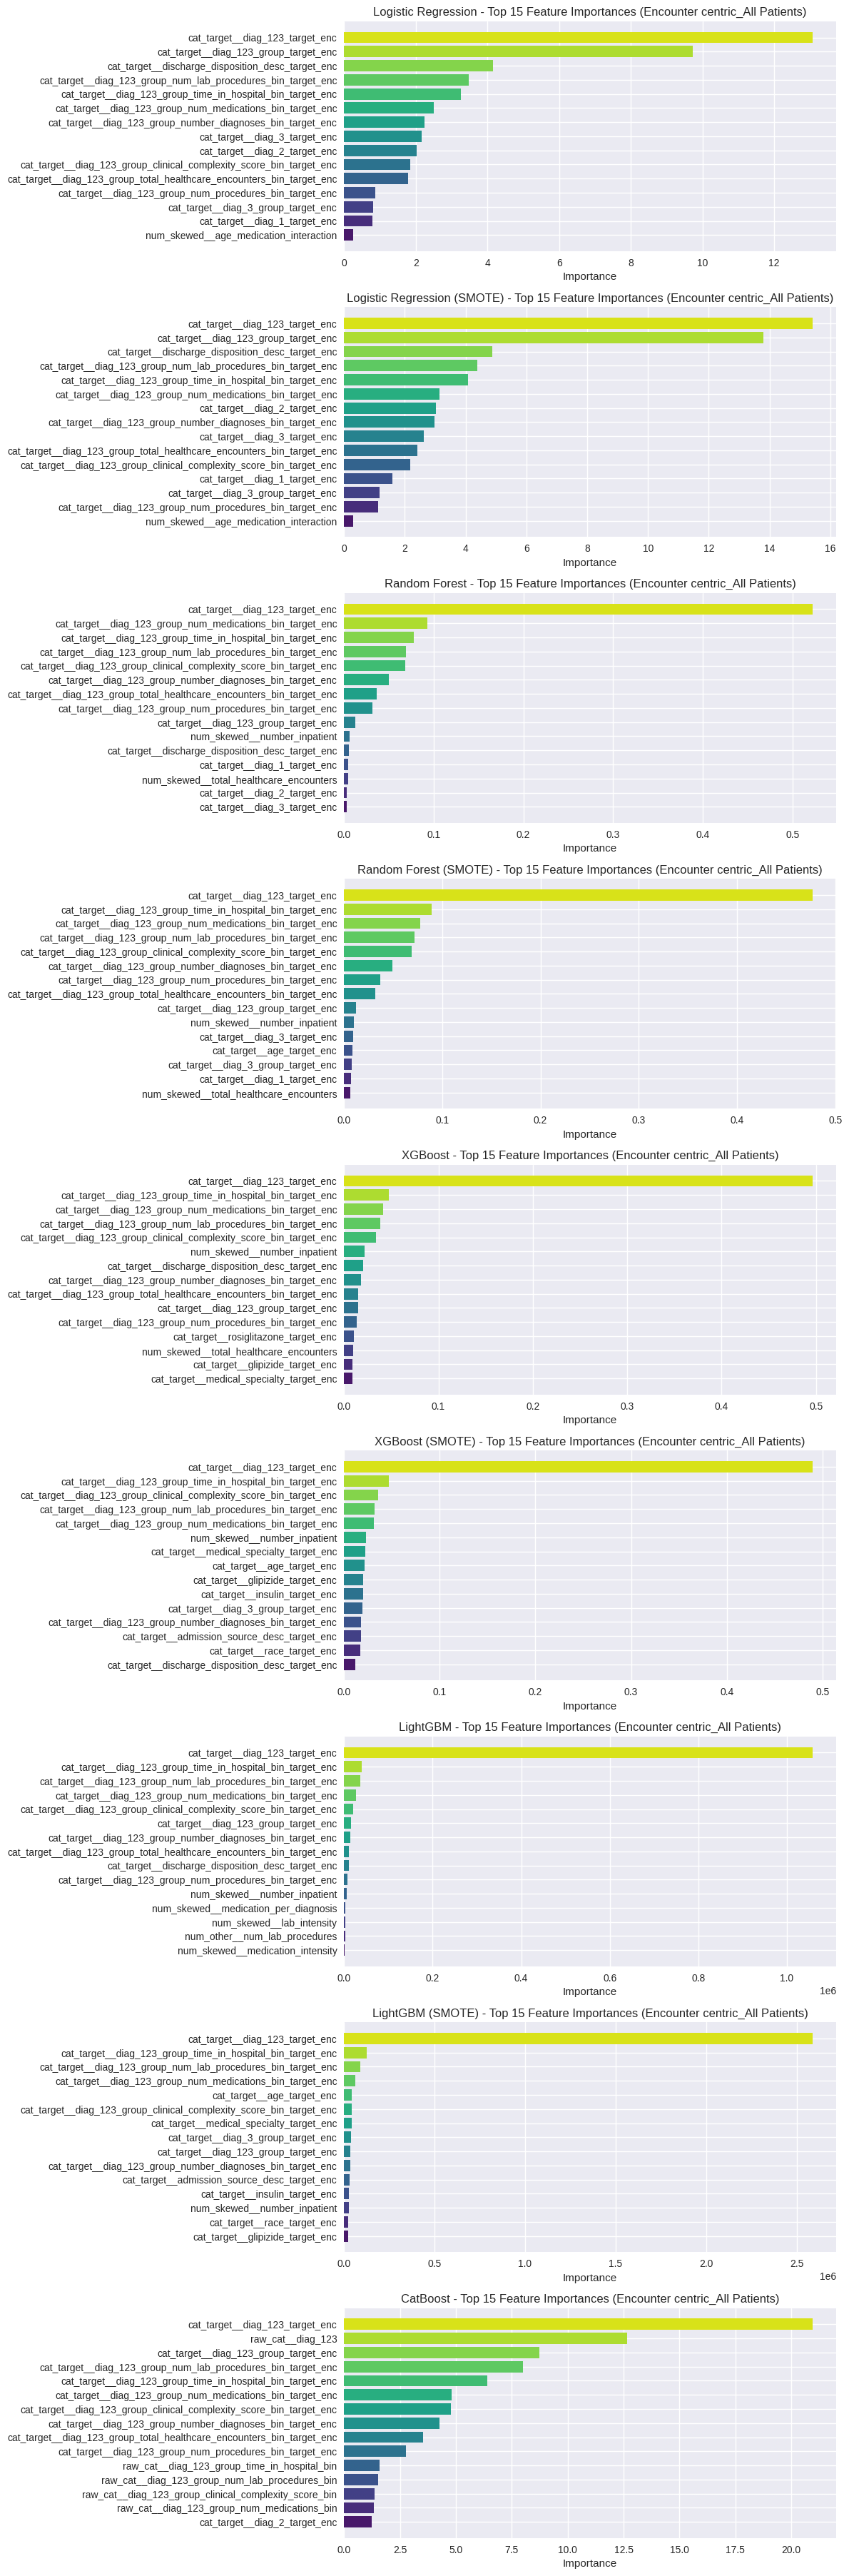

Detected model type: GaussianNB
Using general SHAP Explainer
SHAP.Explainer failed (The passed model is not callable and cannot be analyzed directly with the given masker! Model: GaussianNB()); falling back to TreeExplainer...
All SHAP methods failed: Model type not yet supported by TreeExplainer: <class 'sklearn.naive_bayes.GaussianNB'>
   Model type: GaussianNB
   X_test shape: (20354, 42)
   X_train shape: (81412, 42)


In [28]:
results = pipeline_results_e["results"]
y_test = pipeline_results_e["y_test"]
X_train_final = pipeline_results_e["X_train_final"]
X_test_final = pipeline_results_e["X_test_final"]
selected_features = pipeline_results_e["selected_features"]
best_model_name = pipeline_results_e["best_model_name"]
best_model_payload = pipeline_results_e["best_model_payload"]
shap_results_e = run_display_summary(results, group_name_e, y_test, X_train_final, X_test_final, selected_features, best_model_name, best_model_payload)

In [29]:
if 'error' not in shap_results_e['shap']:
    shap_type_e = shap_results_e['shap'].get('explainer_type', 'Unknown')
    print(f"   SHAP analysis: Success ({shap_type_e})")
else:
    print(f"   SHAP analysis: {shap_results_e['shap']['error']}")

   SHAP analysis: All SHAP methods failed: Model type not yet supported by TreeExplainer: <class 'sklearn.naive_bayes.GaussianNB'>


In [30]:
# Performance analysis breakdown by selected features
X_test_final_e = pipeline_results_e['X_test_final']
y_test_e = pipeline_results_e['y_test']
best_estimator_e = pipeline_results_e['best_model_payload']['estimator']
best_model_name_e = pipeline_results_e['best_model_name']
test_metadata_e = df.loc[X_test_final_e.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]
print(f'===ENCOUNTER LEVEL CONFUSION MATRIX ANALYSIS BY FEATURE===')
for feature in test_metadata_e.columns:
    print(f"\nConfusion breakdown by {feature}:")
    display(confusion_breakdown(best_estimator_e, X_test_final_e, y_test_e, test_metadata_e, feature))


===ENCOUNTER LEVEL CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support     TN    FP    FN   TP  f1_score  precision  \
3        Caucasian    14852  11375  1822  1299  356  0.185755   0.163453   
1  AfricanAmerican     4371   3329   550   399   93  0.163877   0.144635   
4         Hispanic      441    343    53    39    6  0.115385   0.101695   
0                ?      326    245    39    30   12  0.258065   0.235294   
5            Other      289    226    38    19    6  0.173913   0.136364   
2            Asian       75     51    12    10    2  0.153846   0.142857   

     recall  specificity   roc_auc  
3  0.215106     0.861938  0.538522  
1  0.189024     0.858211  0.523618  
4  0.133333     0.866162  0.499747  
0  0.285714     0.862676  0.574195  
5  0.240000     0.856061  0.548030  
2  0.166667     0.809524  0.488095


Confusion breakdown by age:


age  support    TN   FP   FN   TP  f1_score  precision    recall  \
7   [70-80)     5383  4082  669  508  124  0.174035   0.156368  0.196203   
6   [60-70)     4400  3364  549  373  114  0.198261   0.171946  0.234086   
5   [50-60)     3675  2825  445  311   94  0.199153   0.174397  0.232099   
8   [80-90)     2610  2013  312  220   65  0.196375   0.172414  0.228070   
4   [40-50)     2221  1730  265  195   31  0.118774   0.104730  0.137168   
3   [30-40)      933   684  135   85   29  0.208633   0.176829  0.254386   
9  [90-100)      366   283   43   35    5  0.113636   0.104167  0.125000   
2   [20-30)      332   247   42   37    6  0.131868   0.125000  0.139535   
1   [10-20)      324   252   42   25    5  0.129870   0.106383  0.166667   
0    [0-10)      110    89   12    7    2  0.173913   0.142857  0.222222   

   specificity   roc_auc  
7     0.859188  0.527695  
6     0.859698  0.546892  
5     0.863914  0.548007  
8     0.865806  0.546938  
4     0.867168  0.502168  
3     0.835165  0.544775  
9     0.868098  0.496549  
2     0.854671  0.497103  
1     0.857143  0.511905  
0     0.881188  0.551705


Confusion breakdown by diag_1_group:


diag_1_group  support    TN   FP  \
0                                         Circulatory     7091  5481  825   
10                                        Respiratory     2548  1949  340   
1                                            Diabetes     1930  1473  247   
2                                           Digestive     1731  1312  220   
6                                              Injury     1283   986  139   
7                                     Musculoskeletal      916   671  135   
4                                       Genitourinary      761   589   93   
8                                           Neoplasms      714   539   89   
17        symptoms, signs, and ill-defined conditions      596   453   84   
16                                   mental disorders      528   398   63   
3   Endocrine, nutritional and metabolic diseases,...      484   365   64   
15       diseases of the skin and subcutaneous tissue      448   338   51   
9                                               Other      391   288   57   
5                   Infectious and parasitic diseases      372   283   36   
14    diseases of the nervous system and sense organs      216   182   19   
13     diseases of the blood and blood-forming organs      171   134   27   
11  complications of pregnancy, childbirth, and th...      166   122   24   
12                               congenital anomalies        8     6    1   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   621  164  0.184893   0.165824  0.208917     0.869172  0.539045  
10  206   53  0.162577   0.134860  0.204633     0.851464  0.528048  
1   166   44  0.175649   0.151203  0.209524     0.856395  0.532960  
2   158   41  0.178261   0.157088  0.206030     0.856397  0.531214  
6   131   27  0.166667   0.162651  0.170886     0.876444  0.523665  
7    84   26  0.191882   0.161491  0.236364     0.832506  0.534435  
4    54   25  0.253807   0.211864  0.316456     0.863636  0.590046  
8    65   21  0.214286   0.190909  0.244186     0.858280  0.551233  
17   53    6  0.080537   0.066667  0.101695     0.843575  0.472635  
16   55   12  0.169014   0.160000  0.179104     0.863341  0.521223  
3    44   11  0.169231   0.146667  0.200000     0.850816  0.525408  
15   47   12  0.196721   0.190476  0.203390     0.868895  0.536142  
9    34   12  0.208696   0.173913  0.260870     0.834783  0.547826  
5    43   10  0.202020   0.217391  0.188679     0.887147  0.537913  
14   11    4  0.210526   0.173913  0.266667     0.905473  0.586070  
13    8    2  0.102564   0.068966  0.200000     0.832298  0.516149  
11   16    4  0.166667   0.142857  0.200000     0.835616  0.517808  
12    0    1  0.666667   0.500000  1.000000     0.857143  0.928571


Confusion breakdown by diag_2_group:


diag_2_group  support    TN   FP  \
0                                         Circulatory     6824  5249  806   
1                                            Diabetes     3608  2708  476   
10                                        Respiratory     1919  1459  237   
3   Endocrine, nutritional and metabolic diseases,...     1459  1140  171   
4                                       Genitourinary     1207   897  181   
2                                           Digestive      775   601   85   
15       diseases of the skin and subcutaneous tissue      642   493   76   
9                                               Other      588   460   70   
16                                   mental disorders      502   387   56   
17        symptoms, signs, and ill-defined conditions      484   363   72   
13     diseases of the blood and blood-forming organs      474   359   60   
8                                           Neoplasms      474   362   64   
6                                              Injury      460   359   47   
5                   Infectious and parasitic diseases      356   277   44   
7                                     Musculoskeletal      283   214   35   
14    diseases of the nervous system and sense organs      190   153   22   
11  complications of pregnancy, childbirth, and th...       93    75   10   
12                               congenital anomalies       16    13    2   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   604  165  0.189655   0.169928  0.214564     0.866887  0.540726  
1   340   84  0.170732   0.150000  0.198113     0.850503  0.524308  
10  172   51  0.199609   0.177083  0.228700     0.860259  0.544479  
3   119   29  0.166667   0.145000  0.195946     0.869565  0.532756  
4    98   31  0.181818   0.146226  0.240310     0.832096  0.536203  
2    72   17  0.178010   0.166667  0.191011     0.876093  0.533552  
15   58   15  0.182927   0.164835  0.205479     0.866432  0.535956  
9    49    9  0.131387   0.113924  0.155172     0.867925  0.511548  
16   44   15  0.230769   0.211268  0.254237     0.873589  0.563913  
17   43    6  0.094488   0.076923  0.122449     0.834483  0.478466  
13   41   14  0.217054   0.189189  0.254545     0.856802  0.555674  
8    40    8  0.133333   0.111111  0.166667     0.849765  0.508216  
6    45    9  0.163636   0.160714  0.166667     0.884236  0.525452  
5    25   10  0.224719   0.185185  0.285714     0.862928  0.574321  
7    26    8  0.207792   0.186047  0.235294     0.859438  0.547366  
14   13    2  0.102564   0.083333  0.133333     0.874286  0.503810  
11    6    2  0.200000   0.166667  0.250000     0.882353  0.566176  
12    1    0  0.000000   0.000000  0.000000     0.866667  0.433333


Confusion breakdown by diag_3_group:


diag_3_group  support    TN   FP  \
0                                         Circulatory     6156  4714  725   
1                                            Diabetes     4132  3209  485   
3   Endocrine, nutritional and metabolic diseases,...     1588  1191  205   
9                                               Other     1481  1138  193   
10                                        Respiratory     1382  1019  213   
4                                       Genitourinary     1043   800  132   
2                                           Digestive      778   584  105   
16                                   mental disorders      637   501   74   
17        symptoms, signs, and ill-defined conditions      471   364   52   
15       diseases of the skin and subcutaneous tissue      436   331   55   
13     diseases of the blood and blood-forming organs      417   328   43   
5                   Infectious and parasitic diseases      374   290   44   
14    diseases of the nervous system and sense organs      373   289   39   
7                                     Musculoskeletal      352   260   52   
6                                              Injury      341   263   37   
8                                           Neoplasms      293   213   44   
11  complications of pregnancy, childbirth, and th...       82    60   15   
12                               congenital anomalies       18    15    1   

     FN   TP  f1_score  precision    recall  specificity   roc_auc  
0   564  153  0.191850   0.174260  0.213389     0.866703  0.540046  
1   337  101  0.197266   0.172355  0.230594     0.868706  0.549650  
3   155   37  0.170507   0.152893  0.192708     0.853152  0.522930  
9   121   29  0.155914   0.130631  0.193333     0.854996  0.524165  
10  120   30  0.152672   0.123457  0.200000     0.827110  0.513555  
4    86   25  0.186567   0.159236  0.225225     0.858369  0.541797  
2    72   17  0.161137   0.139344  0.191011     0.847605  0.519308  
16   51   11  0.149660   0.129412  0.177419     0.871304  0.524362  
17   43   12  0.201681   0.187500  0.218182     0.875000  0.546591  
15   41    9  0.157895   0.140625  0.180000     0.857513  0.518756  
13   38    8  0.164948   0.156863  0.173913     0.884097  0.529005  
5    29   11  0.231579   0.200000  0.275000     0.868263  0.571632  
14   35   10  0.212766   0.204082  0.222222     0.881098  0.551660  
7    34    6  0.122449   0.103448  0.150000     0.833333  0.491667  
6    31   10  0.227273   0.212766  0.243902     0.876667  0.560285  
8    31    5  0.117647   0.102041  0.138889     0.828794  0.483841  
11    6    1  0.086957   0.062500  0.142857     0.800000  0.471429  
12    2    0  0.000000   0.000000  0.000000     0.937500  0.468750

Optimal threshold for f1: 0.100
Best f1 score: 0.194
===Encounter centric_All Patients Naive Bayes Optimal Threshold===
Default threshold: 0.5
Optimal threshold: 0.100
  Max F1 score: 0.194
  ROC-AUC score: 

Performance at optimal threshold:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     18083
           1       0.16      0.25      0.19      2271

    accuracy                           0.77     20354
   macro avg       0.53      0.54      0.53     20354
weighted avg       0.82      0.77      0.79     20354


Confusion Matrix:
[[15035  3048]
 [ 1699   572]]


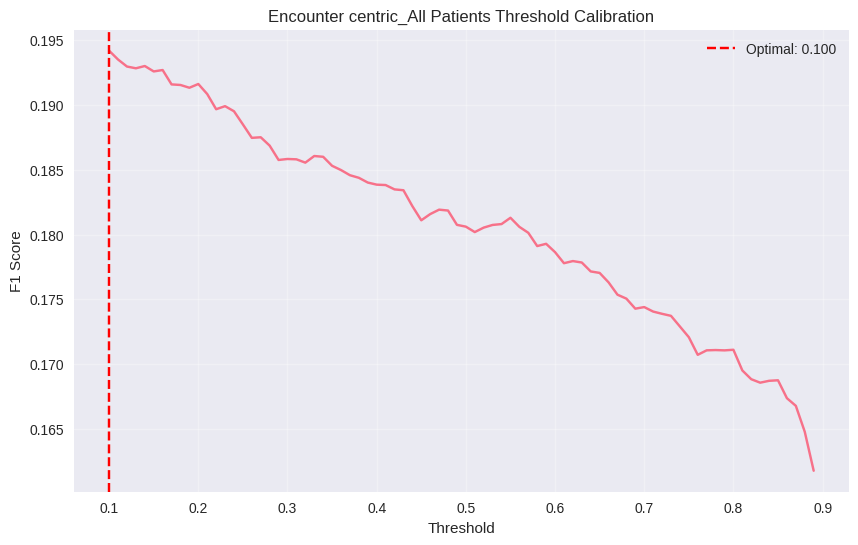

In [31]:
# Threshold Calibration
display_optimal_thresholds(best_estimator_e, best_model_name_e, X_test_final_e, y_test_e, group_name_e)